<a href="https://colab.research.google.com/github/samarranjit/Yield_Prediction/blob/main/MultiYear_Yield_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio
!pip install whitebox
!pip install tqdm
!pip install tqdm_joblib
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio.features
import rasterio.warp
import whitebox
from rasterio.enums import Resampling
from rasterio.io import MemoryFile
from rasterio.warp import reproject, calculate_default_transform
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import Point
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import uniform, randint, loguniform
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

/usr/local/lib/python3.12/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
#Let;s load all the fields' data:



# 👉 PATH TO ONE CROP FILE

# fn = r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\Raw Yield data\soybeans.parquet"
# fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/soybeans.parquet"
#Count the number of rows in the file
df = pd.read_parquet(fn)

print(f"Number of rows in the file: {len(df)}")

print(df.info())  # get a summary of the data

#count the number and name of unique fields
print(f"Number of unique fields: {df['field'].nunique()}")
print(f"Unique fields: {df['field'].unique()}")

total_rows = len(df)
missing_per_col = df.isna().sum().to_frame('NaN_count')
missing_per_col['percent'] = 100 * missing_per_col['NaN_count'] / total_rows
print(missing_per_col)

df_yield = df

NameError: name 'pd' is not defined

In [ ]:
df_yield.describe()

,x,y,yield,year
count,611315.000000,6.113150e+05,611315.000000,611315.000000
mean,337339.638666,4.321327e+06,46.694985,2019.207328
std,2571.816114,8.672437e+02,16.998010,2.978032
min,330893.532259,4.318616e+06,4.139045,2014.000000
25%,336099.599602,4.320616e+06,34.509420,2017.000000
50%,336840.073515,4.321341e+06,46.845428,2019.000000
75%,339214.129061,4.321947e+06,59.010979,2022.000000
max,342733.656286,4.323242e+06,116.790192,2024.000000


In [ ]:
df_map={}
df_map["2014-2024"] = df_yield.copy()
df_map["2014-2024"].describe()

,x,y,yield,year
count,611315.000000,6.113150e+05,611315.000000,611315.000000
mean,337339.638666,4.321327e+06,46.694985,2019.207328
std,2571.816114,8.672437e+02,16.998010,2.978032
min,330893.532259,4.318616e+06,4.139045,2014.000000
25%,336099.599602,4.320616e+06,34.509420,2017.000000
50%,336840.073515,4.321341e+06,46.845428,2019.000000
75%,339214.129061,4.321947e+06,59.010979,2022.000000
max,342733.656286,4.323242e+06,116.790192,2024.000000


In [ ]:
#Checking the accuracy of my input variables by comparing it against Annelise's

# df_2023 = pd.read_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_yield_with_elev.parquet")
# df_2023 = df_2023[df_2023['year'] == 2023]

df_yield = df_2023

# with rasterio.open(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/slope.tif") as slope_src:
#     coords = list(zip(df_yield['x'], df_yield['y']))
#     slope_vals = [val[0] for val in slope_src.sample(coords)]

# # with rasterio.open(r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\aspect.tif") as aspect_src:
# with rasterio.open(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/aspect.tif") as aspect_src:
#     coords = list(zip(df_yield['x'], df_yield['y']))
#     aspect_vals = [val[0] for val in aspect_src.sample(coords)]



# df_yield['slope'] = slope_vals
# df_yield['aspect'] = aspect_vals

# df_2023 = df_yield.copy()

# print("Df Yield describe: ",df_yield.describe())
# missing_slope = (df_yield['slope'] <= 0).sum()
# missing_aspect = (df_yield['aspect'] <= 0).sum()

# print("Rows with NoData slope (0):", missing_slope)
# print("Rows with NoData aspect (0):", missing_aspect)

# df_yield = df_yield[(df_yield['slope'] >= 0) & (df_yield['aspect'] >= 0)]

# df_2023 = df_yield.copy()

df_map[2023] = df_2023.copy()



df_2023.describe()

,x,y,yield,year,elevation,slope,aspect
count,47743.000000,4.774300e+04,47743.000000,47743.0,47743.000000,47743.000000,47743.000000
mean,338403.163795,4.321621e+06,48.842408,2023.0,38.447407,2.104362,187.598999
std,2257.715482,8.014336e+02,11.990427,0.0,4.949237,1.461204,92.718246
min,335649.194736,4.320101e+06,8.603782,2023.0,26.911303,0.010764,0.023555
25%,336335.033606,4.320876e+06,41.466496,2023.0,34.519690,0.998068,113.449806
50%,336892.071020,4.321642e+06,50.023865,2023.0,38.388027,1.729410,183.934357
75%,340408.262407,4.322216e+06,57.486563,2023.0,42.209253,2.875897,265.903992
max,342354.935931,4.323242e+06,81.252083,2023.0,53.912220,10.327113,359.987457


In [ ]:
df_map={}
df_map["2020-2023"] = df
df_map["2020-2023"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 227607 entries, 0 to 236865
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   x                        227607 non-null  float64
 1   y                        227607 non-null  float64
 2   yield                    227607 non-null  float64
 3   field                    227607 non-null  object 
 4   year                     227607 non-null  int64  
 5   elevation                227607 non-null  float32
 6   slope                    227607 non-null  float32
 7   aspect                   227607 non-null  float32
 8   aspect_southness         227607 non-null  float32
 9   slope_squared            227607 non-null  float32
 10  elevation_squared        227607 non-null  float32
 11  elev_slope               227607 non-null  float32
 12  elev_aspect              227607 non-null  float32
 13  slope_aspect             227607 non-null  float32
 14  ndvi_mean

In [ ]:
# fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_map_2020_2023_ndvi_lst_pr_ari.parquet"
# fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_map_2020_2023_ndvi_lst_pr_ari.parquet"
# fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_map_2014_2023Scaled.parquet"
fn = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_map_2014_2024_all_variables_absolute.parquet"
#Count the number of rows in the file
df_map ={}
df_map["2014-2024"] = pd.read_parquet(fn)

df_map["2014-2024"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611229 entries, 0 to 611228
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              611229 non-null  int64  
 1   x                  611229 non-null  float64
 2   y                  611229 non-null  float64
 3   yield              611229 non-null  float64
 4   field              611229 non-null  object 
 5   year               611229 non-null  int64  
 6   elevation          611229 non-null  float32
 7   slope              611229 non-null  float32
 8   aspect             611229 non-null  float32
 9   aspect_southness   611229 non-null  float32
 10  slope_squared      611229 non-null  float32
 11  elevation_squared  611229 non-null  float32
 12  elev_slope         611229 non-null  float32
 13  elev_aspect        611229 non-null  float32
 14  slope_aspect       611229 non-null  float32
 15  ndvi_mean          611229 non-null  float64
 16  nd

In [ ]:
df_map["2014-2024"].describe()

,index,x,y,yield,year,elevation,slope,aspect,aspect_southness,slope_squared,...,ndwi_range,tr_swir1_mean,tr_swir1_max,tr_swir1_range,tr_swir2_mean,tr_swir2_max,tr_swir2_range,theta_s,clay_pct,ksat
count,611229.000000,611229.000000,6.112290e+05,611229.000000,611229.000000,611229.000000,611229.000000,611229.000000,611229.000000,611229.000000,...,611229.000000,611229.000000,611229.000000,611229.000000,611229.000000,611229.000000,611229.000000,611229.000000,611229.000000,611229.000000
mean,28869.885784,337340.542897,4.321327e+06,46.697351,2019.207287,38.394703,2.341159,188.892471,0.501453,8.391222,...,0.572487,1.134234,2.182325,1.662681,2.662510,5.479179,4.452982,0.439664,14.223518,0.440030
std,17584.141564,2570.866923,8.671467e+02,16.997666,2.978234,6.978748,1.705738,103.343109,0.289057,60.132690,...,0.148679,0.296460,0.882726,0.887254,0.826830,2.008588,1.997251,0.014088,2.819429,0.213132
min,0.000000,330929.234646,4.318616e+06,4.139045,2014.000000,0.000000,0.003039,0.011794,0.000020,0.000009,...,0.000000,0.440797,0.440797,0.000000,0.869761,0.869761,0.000000,0.380911,3.079590,-0.488807
25%,13891.000000,336100.004450,4.320619e+06,34.512669,2017.000000,32.998447,1.187884,104.222939,0.248917,1.411067,...,0.489378,0.957110,1.640097,1.131601,2.171614,4.395431,3.401082,0.431961,12.445312,0.310833
50%,27783.000000,336840.073515,4.321341e+06,46.848888,2019.000000,38.238541,2.018469,195.382599,0.508849,4.074216,...,0.601618,1.070633,1.905641,1.408497,2.491720,4.983261,4.058541,0.438055,13.985926,0.440327
75%,42988.000000,339214.129061,4.321947e+06,59.013851,2022.000000,42.905262,3.151609,278.881500,0.750272,9.932640,...,0.672235,1.230411,2.498157,1.998280,2.916944,5.999605,4.943190,0.444904,15.837350,0.568091
max,72415.000000,342733.656286,4.323242e+06,116.790192,2024.000000,80.984177,82.644829,359.996460,0.999995,6830.167969,...,1.067333,5.699543,14.227441,12.912396,14.161614,34.718805,32.962507,0.524729,33.909420,1.437375


In [ ]:
#Drop rows with NA values
# df_map["2014-2023"].dropna(inplace=True)
df_map["2014-2023Abs"][df_map["2014-2023Abs"]['year'] == 2023]['evi_range'].describe()

,evi_range
count,4.774300e+04
mean,1.316376e+11
std,6.552853e+12
min,7.008060e-01
25%,3.273343e+00
50%,5.472509e+00
75%,1.126424e+01
max,5.134104e+14


In [ ]:
#drop the rows with na values
# df_map["2014-2019"].dropna(inplace=True)
print(df_map["2014-2019"].keys())

print("========================================")

print(df_map["2020-2023"].keys())
print("========================================")

print(df_map["2014-2019"].columns.difference(df_map["2020-2023"].columns))


KeyError: '2014-2019'

In [ ]:
common_fields = set(df_map["2020-2023"].loc[df_map["2020-2023"]["year"] == 2020, "field"]).intersection(
    df_map["2020-2023"].loc[df_map["2020-2023"]["year"] == 2021, "field"],
    # df_map["2020-2023"].loc[df_map["2020-2023"]["year"] == 2022, "field"],
    df_map["2020-2023"].loc[df_map["2020-2023"]["year"] == 2023, "field"]
)

print("Number of common fields:", len(common_fields))
print("Common fields:", common_fields)


Number of common fields: 2
Common fields: {'Central Farm_1-2A', 'Central Farm_1-2C'}


In [ ]:
# df_yield = df_yield[df_yield['year'] <= 2019 ].copy()
df_map["2014-2023"]['yield'].describe()

,yield
count,552516.000000
mean,47.585919
std,16.131593
min,4.826442
25%,35.902624
50%,46.916893
75%,59.284430
max,116.790192


In [ ]:
df_yield = df_map['2014-2024'].copy()
# dst_dem_resampled = r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\DEM_5m_UTM18.tif"
dst_dem_resampled = r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/DEM_5m_UTM18.tif"

# Step 1: Open the resampled DEM
with rasterio.open(dst_dem_resampled) as dem_src:

    # Step 2: Create list of (x, y) coordinate pairs
    coords = list(zip(df_yield['x'], df_yield['y']))

    # Step 3: Sample elevation values at those coordinates
    elevation_vals = [val[0] for val in dem_src.sample(coords)]

# Step 4: Add to DataFrame
df_yield['elevation'] = elevation_vals

df_map["2014-2024"] = df_yield.copy()

# Step 5: Preview
# print(df_map['2014-2019'].info())

In [ ]:
df_yield = df_map['2014-2024']
# with rasterio.open(r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\slope.tif") as slope_src:
with rasterio.open(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/slope.tif") as slope_src:
    coords = list(zip(df_yield['x'], df_yield['y']))
    slope_vals = [val[0] for val in slope_src.sample(coords)]

# with rasterio.open(r"C:\Users\acer\OneDrive - Texas State University\ChoLab\USDA Crop yield Stability Study\BARC_Yield_Analysis\Prediction\Data\aspect.tif") as aspect_src:
with rasterio.open(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/aspect.tif") as aspect_src:
    coords = list(zip(df_yield['x'], df_yield['y']))
    aspect_vals = [val[0] for val in aspect_src.sample(coords)]

df_yield['slope'] = slope_vals
df_yield['aspect'] = aspect_vals
df_yield.describe()

df_map['2014-2024'] = df_yield.copy()


In [ ]:
df_map["2014-2024"].describe()

,x,y,yield,year,elevation,slope,aspect
count,611315.000000,6.113150e+05,611315.000000,611315.000000,611315.000000,611315.000000,611315.000000
mean,337339.638666,4.321327e+06,46.694985,2019.207328,38.389294,0.518345,187.043304
std,2571.816114,8.672437e+02,16.998010,2.978032,6.993091,244.386002,266.547119
min,330893.532259,4.318616e+06,4.139045,2014.000000,0.000000,-32768.000000,-32768.000000
25%,336099.599602,4.320616e+06,34.509420,2017.000000,32.996063,1.187542,104.177971
50%,336840.073515,4.321341e+06,46.845428,2019.000000,38.237869,2.018188,195.362610
75%,339214.129061,4.321947e+06,59.010979,2022.000000,42.904743,3.151403,278.870316
max,342733.656286,4.323242e+06,116.790192,2024.000000,80.984177,82.644829,359.996460


In [ ]:
print("Df Yield describe: ",df_yield.describe())
missing_slope = (df_yield['slope'] <= 0).sum()
missing_aspect = (df_yield['aspect'] <= 0).sum()

print("Rows with NoData slope (0):", missing_slope)
print("Rows with NoData aspect (0):", missing_aspect)

df_yield = df_yield[(df_yield['slope'] >= 0) & (df_yield['aspect'] >= 0)]

# 3. Confirm
print("Remaining rows:", len(df_yield))

df_map["2014-2024"] = df_yield.copy()

Df Yield describe:                     x             y          yield           year  \
count  611315.000000  6.113150e+05  611315.000000  611315.000000   
mean   337339.638666  4.321327e+06      46.694985    2019.207328   
std      2571.816114  8.672437e+02      16.998010       2.978032   
min    330893.532259  4.318616e+06       4.139045    2014.000000   
25%    336099.599602  4.320616e+06      34.509420    2017.000000   
50%    336840.073515  4.321341e+06      46.845428    2019.000000   
75%    339214.129061  4.321947e+06      59.010979    2022.000000   
max    342733.656286  4.323242e+06     116.790192    2024.000000   

           elevation          slope         aspect  
count  611315.000000  611315.000000  611315.000000  
mean       38.389294       0.518345     187.043304  
std         6.993091     244.386002     266.547119  
min         0.000000  -32768.000000  -32768.000000  
25%        32.996063       1.187542     104.177971  
50%        38.237869       2.018188     195.36261

In [ ]:
# df_map ={
#     # 2020 : df_yield[df_yield['year'] == 2020].copy(),
#     # 2021 : df_yield[df_yield['year'] == 2021].copy(),
#     # 2022 : df_yield[df_yield['year'] == 2022].copy(),
#     # 2023 : df_yield[df_yield['year'] == 2023].copy(),
#     # 2024 : df_yield[df_yield['year'] == 2024].copy(),
#     2014 : df_map['2014-2019'][df_map['2014-2019']['year'] == 2014].copy(),
#     2015 : df_map['2014-2019'][df_map['2014-2019']['year'] == 2015].copy(),
#     2016 : df_map['2014-2019'][df_map['2014-2019']['year'] == 2016].copy(),
#     2017 : df_map['2014-2019'][df_map['2014-2019']['year'] == 2017].copy(),
#     2018 : df_map['2014-2019'][df_map['2014-2019']['year'] == 2018].copy(),
#     2019 : df_map['2014-2019'][df_map['2014-2019']['year'] == 2019].copy(),

# }

# df_map['2020-2022']  = pd.concat([df_map[2020], df_map[2021], df_map[2022]]).reset_index()
# df_map['2020-2023']  = pd.concat([df_map[2020], df_map[2021], df_map[2022], df_map[2023]]).reset_index()
# df_map['2014-2019']  = pd.concat([df_map[2014], df_map[2015], df_map[2016], df_map[2017], df_map[2018], df_map[2019]]).reset_index()
# df_map['2014-2019'].reset_index(drop=True)


# df_map[2014] = df_yield[df_yield['year'] == 2014].copy()
# df_map[2015] = df_yield[df_yield['year'] == 2015].copy()
# df_map[2016] = df_yield[df_yield['year'] == 2016].copy()
# df_map[2017] = df_yield[df_yield['year'] == 2017].copy()
# df_map[2018] = df_yield[df_yield['year'] == 2018].copy()
# df_map[2019] = df_yield[df_yield['year'] == 2019].copy()


# df_map["2014-2023"] = pd.concat([df_map["2014-2019"].drop(columns=['index']), df_map[2020].drop(columns=['level_0']), df_map[2021].drop(columns=['level_0']), df_map[2022].drop(columns=['level_0']),df_map[2023].drop(columns=['level_0'])]).reset_index()



# df_map['2014-2023'].info()

# df_map['2014-2019'].describe()

# for year in range(2014, 2025):  # includes 2024
#     mask = df_map["2014-2024"]["year"] == year
#     df_map[year] = df_map["2014-2024"].loc[mask].copy()

df_map["2014-2024"] = pd.concat([df_map[2014],
                                 df_map[2015],
                                 df_map[2016],
                                 df_map[2017],
                                 df_map[2018],
                                 df_map[2019] ,
                                 df_map[2020],
                                 df_map[2021],
                                 df_map[2022],
                                 df_map[2023],
                                 df_map[2024]]).reset_index()
df_map["2014-2024"].info()


# df_map.keys()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611229 entries, 0 to 611228
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              611229 non-null  int64  
 1   x                  611229 non-null  float64
 2   y                  611229 non-null  float64
 3   yield              611229 non-null  float64
 4   field              611229 non-null  object 
 5   year               611229 non-null  int64  
 6   elevation          611229 non-null  float32
 7   slope              611229 non-null  float32
 8   aspect             611229 non-null  float32
 9   aspect_southness   611229 non-null  float32
 10  slope_squared      611229 non-null  float32
 11  elevation_squared  611229 non-null  float32
 12  elev_slope         611229 non-null  float32
 13  elev_aspect        611229 non-null  float32
 14  slope_aspect       611229 non-null  float32
 15  ndvi_mean          611229 non-null  float64
 16  nd

In [ ]:
df_map["2014-2024"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611229 entries, 0 to 611228
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              611229 non-null  int64  
 1   x                  611229 non-null  float64
 2   y                  611229 non-null  float64
 3   yield              611229 non-null  float64
 4   field              611229 non-null  object 
 5   year               611229 non-null  int64  
 6   elevation          611229 non-null  float32
 7   slope              611229 non-null  float32
 8   aspect             611229 non-null  float32
 9   aspect_southness   611229 non-null  float32
 10  slope_squared      611229 non-null  float32
 11  elevation_squared  611229 non-null  float32
 12  elev_slope         611229 non-null  float32
 13  elev_aspect        611229 non-null  float32
 14  slope_aspect       611229 non-null  float32
 15  ndvi_mean          611229 non-null  float64
 16  nd

In [ ]:
df_map["2014-2023"].to_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_map_2014_2023_all_variables_absolute.parquet")

In [ ]:
df_map["2014-2024"].to_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_map_2014_2024_all_variables_absolute.parquet")

In [ ]:
# df_map['2014-2019'] = df_yield.copy()
# df_map['2014-2019'].describe()

df_map[2023][['evi_mean', 'evi_max', 'evi_range']].describe()

,evi_mean,evi_max,evi_range
count,47743.000000,47743.000000,47743.000000
mean,0.457202,0.998123,0.860825
std,0.054873,0.143879,0.167439
min,0.260012,0.401526,0.290832
25%,0.420736,0.930233,0.779064
50%,0.459979,1.012445,0.884701
75%,0.496466,1.076671,0.961502
max,0.655839,2.787500,2.646122


In [ ]:
df_map[2020] = df_map["2020-2023"][df_map["2020-2023"]['year'] == 2020]
df_map[2021] = df_map["2020-2023"][df_map["2020-2023"]['year'] == 2021]
df_map[2022] = df_map["2020-2023"][df_map["2020-2023"]['year'] == 2022]
df_map[2023] = df_map["2020-2023"][df_map["2020-2023"]['year'] == 2023]
# df_map[2024] = df_map["2020-2023"][df_map["2020-2023"]['year'] == 2024]

df_map[2021].info()

<class 'pandas.core.frame.DataFrame'>
Index: 54042 entries, 72416 to 126457
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              54042 non-null  int64  
 1   x                  54042 non-null  float64
 2   y                  54042 non-null  float64
 3   yield              54042 non-null  float64
 4   field              54042 non-null  object 
 5   year               54042 non-null  int64  
 6   elevation          54042 non-null  float32
 7   slope              54042 non-null  float32
 8   aspect             54042 non-null  float32
 9   aspect_southness   54042 non-null  float32
 10  slope_squared      54042 non-null  float32
 11  elevation_squared  54042 non-null  float32
 12  elev_slope         54042 non-null  float32
 13  elev_aspect        54042 non-null  float32
 14  slope_aspect       54042 non-null  float32
 15  ndvi_mean          54042 non-null  float64
 16  ndvi_max           540

In [ ]:
df_map.keys()
#save the dataframe as a parquet file
# df_map['2014-2019'].to_parquet(r"/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_map_2014_2019_all_variables.parquet")

dict_keys(['2014-2024', 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

In [ ]:

print(f"==================== Year: {year} ===========================")
# print(df_map[year].info())
# df_yield = df_map['2014-2019'].copy()

for year in range(2014, 2025):
  df_yield = df_map[year].copy()
  # Create aspect southness
  df_yield['aspect_southness'] = 1 - np.abs((df_yield['aspect'] - 180) / 180)

  # Add polynomial features
  df_yield['slope_squared'] = df_yield['slope'] ** 2
  df_yield['elevation_squared'] = df_yield['elevation'] ** 2

  # Add interaction features
  df_yield['elev_slope'] = df_yield['elevation'] * df_yield['slope']
  df_yield['elev_aspect'] = df_yield['elevation'] * df_yield['aspect_southness']
  df_yield['slope_aspect'] = df_yield['slope'] * df_yield['aspect_southness']

  df_map[year] = df_yield.copy()
  print(f"==================== Year: {year} ===========================")
  print(df_map[year].describe())

# df_map["2014-2019"] = df_yield.copy()
# print("=================================================================================")
# print(df_map['2014-2019'].info())


==================== Year: 2024 ===========================
==================== Year: 2014 ===========================
                   x             y         yield     year     elevation  \
count   28536.000000  2.853600e+04  28536.000000  28536.0  28536.000000   
mean   337788.122437  4.320974e+06     61.845449   2014.0     40.465748   
std      1691.344689  8.732457e+02     14.772483      0.0      6.299135   
min    333987.308554  4.318838e+06      5.316504   2014.0     26.588562   
25%    336590.859790  4.320320e+06     52.285303   2014.0     35.352853   
50%    338069.510344  4.321109e+06     63.074663   2014.0     40.183378   
75%    339188.882777  4.321719e+06     72.435942   2014.0     45.276463   
max    340280.651975  4.322372e+06    116.790192   2014.0     54.276974   

              slope        aspect  aspect_southness  slope_squared  \
count  28536.000000  28536.000000      28536.000000   28536.000000   
mean       2.671530    168.977936          0.450224       9.1719

In [ ]:
df_yield.describe()

,x,y,yield,year,elevation,slope,aspect,aspect_southness,slope_squared,elevation_squared,elev_slope,elev_aspect,slope_aspect
count,318831.000000,3.188310e+05,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000,318831.000000
mean,337301.521580,4.321302e+06,44.805640,2016.771776,38.533226,2.300173,189.000717,0.501145,8.156532,1538.110474,91.978058,19.064516,1.096774
std,2665.106368,8.294878e+02,15.989358,1.642396,7.300459,1.692802,103.306427,0.288185,59.606865,618.388367,80.654137,11.282164,1.130545
min,330929.234646,4.318631e+06,4.615487,2014.000000,0.000000,0.003039,0.011794,0.000020,0.000009,0.000000,0.000000,0.000000,0.000031
25%,335993.843619,4.320642e+06,33.664858,2015.000000,32.706348,1.142462,103.593857,0.251261,1.305220,1069.705200,40.336369,9.768792,0.360416
50%,336785.097795,4.321326e+06,43.767281,2017.000000,38.615799,1.983564,197.076782,0.507589,3.934524,1491.179932,70.928322,19.132524,0.779102
75%,339062.651353,4.321893e+06,54.966610,2018.000000,43.313557,3.107778,278.826324,0.749516,9.658284,1876.064209,123.184036,27.329494,1.471877
max,342733.656286,4.323242e+06,116.790192,2019.000000,80.984177,82.644829,359.996460,0.999995,6830.167969,6558.437012,5523.056152,79.058861,41.402943


In [ ]:
for year in [2020, 2021, 2022, 2023, 2024]:
  print(f"==================== Year: {year} ===========================")
  print(df_map[year].info())

==================== Year: 2020 ===========================
<class 'pandas.core.frame.DataFrame'>
Index: 72416 entries, 318874 to 391332
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  72416 non-null  float64
 1   y                  72416 non-null  float64
 2   yield              72416 non-null  float64
 3   field              72416 non-null  object 
 4   year               72416 non-null  int64  
 5   elevation          72416 non-null  float32
 6   slope              72416 non-null  float32
 7   aspect             72416 non-null  float32
 8   aspect_southness   72416 non-null  float32
 9   slope_squared      72416 non-null  float32
 10  elevation_squared  72416 non-null  float32
 11  elev_slope         72416 non-null  float32
 12  elev_aspect        72416 non-null  float32
 13  slope_aspect       72416 non-null  float32
dtypes: float32(9), float64(3), int64(1), object(1)
memory usa

In [ ]:

# Authenticate and initialize
ee.Authenticate()
# Replace 'your-google-cloud-project-id' with your actual Google Cloud Project ID
ee.Initialize(project='cho-lab-prj')

In [ ]:
import_year = 2023

# Create a GeoDataFrame from your pandas DataFrame
# The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
gdf_yield = gpd.GeoDataFrame(
    df_map[import_year],
    geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
    crs='EPSG:32618'  # Replace with the correct CRS for your data if different
)

# Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
# We also reset the index to a column so we can reliably merge later.
gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()



## NDVI Data Importing


In [ ]:
df_map["2014-2023"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561775 entries, 0 to 561774
Data columns (total 50 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   index                    561775 non-null  int64  
 1   x                        561775 non-null  float64
 2   y                        561775 non-null  float64
 3   yield                    561775 non-null  float64
 4   field                    561775 non-null  object 
 5   year                     561775 non-null  int64  
 6   elevation                561775 non-null  float64
 7   slope                    561775 non-null  float64
 8   aspect                   561775 non-null  float64
 9   aspect_southness         561775 non-null  float64
 10  slope_squared            561775 non-null  float64
 11  elevation_squared        561775 non-null  float64
 12  elev_slope               561775 non-null  float64
 13  elev_aspect              561775 non-null  float64
 14  slop

In [ ]:
#Landsat NDVI Dataset
def import_ndvi(import_year):


  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()


  print("============================================================================")
  print("Processing Year: ", import_year)
  print("============================================================================")
  # --------------------------------------------------------------------------------
  # Step 2: Define image processing functions for GEE
  # --------------------------------------------------------------------------------

  def add_ndvi(image):
      """
      A GEE server-side function to add a cloud mask and NDVI band to a Sentinel-2 image.
      This function is mapped over the entire image collection.
      """
      # Sentinnel:
      # qa = image.select('QA60')
      # cloud_bit_mask = 1 << 10
      # cirrus_bit_mask = 1 << 11
      # mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
      # image = image.updateMask(mask).divide(10000)
      # ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
      # return image.addBands(ndvi)

      #Landsat:
      qa = image.select('QA_PIXEL')
      mask = (qa.bitwiseAnd(1 << 1).eq(0)   # dilated cloud
              .And(qa.bitwiseAnd(1 << 3).eq(0))  # cloud
              .And(qa.bitwiseAnd(1 << 4).eq(0))  # cloud shadow
              .And(qa.bitwiseAnd(1 << 5).eq(0)))  # snow
              # .And(qa.bitwiseAnd(1 << 7).eq(0))) # water
      image = image.updateMask(mask)

      # NDVI from SR bands (scale factors cancel in the ratio)
      nir = image.select('SR_B5')
      red = image.select('SR_B4')
      ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
      return image.addBands(ndvi)


  # --------------------------------------------------------------------------------
  # Step 3: Process the data in batches to avoid server-side limits
  # --------------------------------------------------------------------------------

  batch_size = 5000  # You can adjust this value based on your internet speed and data density
  all_results = []
  num_rows = len(gdf_yield_wgs84)

  print(f"Starting to process {num_rows} points in batches of {batch_size}...")

  for start_index in range(0, num_rows, batch_size):
      try:
          end_index = min(start_index + batch_size, num_rows)
          batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

          # Convert the current batch of points to a GEE FeatureCollection
          ee_feature_collection = ee.FeatureCollection(batch_gdf.__geo_interface__)

          # Define the Sentinel-2 image collection and filter it by date and the batch's bounds

          # s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
          #     .filterDate(f'{import_year}-04-01', f'{import_year}-11-15') \
          #     .filterBounds(ee_feature_collection.geometry()) \
          #     .map(add_ndvi)

          s2_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
              .filterDate(f'{import_year}-04-01', f'{import_year}-10-31') \
              .filterBounds(ee_feature_collection.geometry()) \
              .map(add_ndvi)

          # 1) Build per-pixel annual NDVI stats (one image with multiple bands)
          ndvi_coll = s2_collection.select('NDVI')

          ndvi_mean_img = ndvi_coll.mean().rename('ndvi_mean')
          ndvi_max_img  = ndvi_coll.max().rename('ndvi_max')
          ndvi_min_img  = ndvi_coll.min().rename('ndvi_min')
          ndvi_range_img = ndvi_max_img.subtract(ndvi_min_img).rename('ndvi_range')


          # Compute the annual mean NDVI for each pixel over the entire time period.
          # This creates a single image where each pixel's value is the mean NDVI over the year.
          # ndvi_mean = s2_collection.select('NDVI').mean()

          # Stack into a single image: [ndvi_mean, ndvi_max, ndvi_range]
          ndvi_stats_img = ee.Image.cat([ndvi_mean_img, ndvi_max_img, ndvi_range_img])


          # 2) Sample the stats image at each point (faster & keeps band names)
          #    (You can also use reduceRegions with a combined reducer, but sampleRegions
          #     returns properties with band names directly.)
          results = ndvi_stats_img.sampleRegions(
              collection=ee_feature_collection,
              scale=10,
              # scale=30,
              geometries=False   # no need to carry geometries back to Python
          )

          # Download the results for this batch and store them
          result_list = results.getInfo()['features']
          ndvi_data_batch = []
          for feature in result_list:
            props = feature['properties']
            original_index = props.get('index')  # relies on your input features carrying 'index'
            ndvi_data_batch.append({
                'index'      : original_index,
                'ndvi_mean'  : props.get('ndvi_mean'),
                'ndvi_max'   : props.get('ndvi_max'),
                'ndvi_range' : props.get('ndvi_range')
            })

          df_ndvi_batch = pd.DataFrame(ndvi_data_batch)
          all_results.append(df_ndvi_batch)

          print(f"Batch {start_index} to {end_index} processed successfully.")

      except Exception as e:
          print(f"Error processing batch {start_index} to {end_index}: {e}")
          # Append an empty DataFrame to maintain consistency if a batch fails
          all_results.append(pd.DataFrame(columns=['index', 'ndvi_mean', 'ndvi_max', 'ndvi_range']))


  # --------------------------------------------------------------------------------
  # Step 4: Combine all batch results and merge with the original DataFrame
  # --------------------------------------------------------------------------------

  if all_results:
      # Concatenate all batch results into one master DataFrame
      df_all_ndvi = pd.concat(all_results, ignore_index=True)
  else:
      df_all_ndvi = pd.DataFrame(columns=['index', 'ndvi_mean', 'ndvi_max', 'ndvi_range'])

  # Merge the new NDVI data with your original DataFrame based on the index
  df_yield_with_index = df_map[import_year].reset_index()
  df_final = df_yield_with_index.merge(df_all_ndvi, on='index', how='left')
  df_final = df_final.set_index('index')
  df_map[import_year] = df_final.copy()
  # Final check of the DataFrame
  print("\nProcessing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:")
  print(df_final.head())
  print(f"\nFinal DataFrame shape: {df_final.shape}")

  df_map[import_year] = df_final.copy()
  df_map[import_year].head(50)


In [ ]:
#Sentinnel Dataset for NDVI Data:

def import_ndvi(import_year):


  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()


  print("============================================================================")
  print("Processing Year: ", import_year)
  print("============================================================================")
  # --------------------------------------------------------------------------------
  # Step 2: Define image processing functions for GEE
  # --------------------------------------------------------------------------------

  QA_BAND = 'cs_cdf'
  clear_threshold = 0.75
  def apply_cs_mask(img, clear_threshold=0.75):
    """
    If cs_cdf is present, mask to cs_cdf >= threshold.
    Else, fall back to QA60 (opaque cloud & cirrus cleared).
    """
    img = ee.Image(img)
    has_cs = img.bandNames().contains(QA_BAND)
    return ee.Image(ee.Algorithms.If(
        has_cs,
        img.updateMask(img.select(QA_BAND).gte(clear_threshold)),
        img.updateMask(
            img.select('QA60').bitwiseAnd(1 << 10).eq(0)  # opaque cloud
              .And(img.select('QA60').bitwiseAnd(1 << 11).eq(0))  # cirrus
        )
    ))

  def add_ndvi_s2(img):
      """
      Add NDVI band; normalizedDifference cancels scaling.
      """
      ndvi = ee.Image(img).normalizedDifference(['B8','B4']).rename('NDVI')
      return ee.Image(img).addBands(ndvi)


  # --------------------------------------------------------------------------------
  # Step 3: Process the data in batches to avoid server-side limits
  # --------------------------------------------------------------------------------

  batch_size = 2000  # You can adjust this value based on your internet speed and data density
  all_results = []
  num_rows = len(gdf_yield_wgs84)

  print(f"Starting to process {num_rows} points in batches of {batch_size}...")

  for start_index in range(0, num_rows, batch_size):
      try:
          end_index = min(start_index + batch_size, num_rows)
          batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

          # Convert the current batch of points to a GEE FeatureCollection
          ee_feature_collection = ee.FeatureCollection(batch_gdf.__geo_interface__)

          # Define the Sentinel-2 image collection and filter it by date and the batch's bounds

          s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
              .filterDate(f'{import_year}-04-01', f'{import_year}-10-31') \
              .filterBounds(ee_feature_collection.geometry())

          cs = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')\
                .filterDate(f'{import_year}-04-01', f'{import_year}-10-31') \
              .filterBounds(ee_feature_collection.geometry())

          s2_with_cs = s2_collection.linkCollection(cs, [QA_BAND])
          s2_masked  = s2_with_cs.map(lambda img: apply_cs_mask(img, clear_threshold))
          s2_masked_ =  s2_masked.map(add_ndvi_s2)


          # s2_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
          #     .filterDate(f'{import_year}-04-01', f'{import_year}-11-15') \
          #     .filterBounds(ee_feature_collection.geometry()) \
          #     .map(add_ndvi)

          # 1) Build per-pixel annual NDVI stats (one image with multiple bands)
          ndvi_coll = s2_masked_.select('NDVI')

          ndvi_mean_img = ndvi_coll.mean().rename('ndvi_mean')
          ndvi_max_img  = ndvi_coll.max().rename('ndvi_max')
          ndvi_min_img  = ndvi_coll.min().rename('ndvi_min')
          ndvi_range_img = ndvi_max_img.subtract(ndvi_min_img).rename('ndvi_range')


          # Compute the annual mean NDVI for each pixel over the entire time period.
          # This creates a single image where each pixel's value is the mean NDVI over the year.
          # ndvi_mean = s2_collection.select('NDVI').mean()

          # Stack into a single image: [ndvi_mean, ndvi_max, ndvi_range]
          ndvi_stats_img = ee.Image.cat([ndvi_mean_img, ndvi_max_img, ndvi_range_img])


          # 2) Sample the stats image at each point (faster & keeps band names)
          #    (You can also use reduceRegions with a combined reducer, but sampleRegions
          #     returns properties with band names directly.)
          results = ndvi_stats_img.sampleRegions(
              collection=ee_feature_collection,
              scale=10,
              # scale=30,
              geometries=False   # no need to carry geometries back to Python
          )

          # Download the results for this batch and store them
          result_list = results.getInfo()['features']
          ndvi_data_batch = []
          for feature in result_list:
            props = feature['properties']
            original_index = props.get('index')  # relies on your input features carrying 'index'
            ndvi_data_batch.append({
                'index'      : original_index,
                'ndvi_mean'  : props.get('ndvi_mean'),
                'ndvi_max'   : props.get('ndvi_max'),
                'ndvi_range' : props.get('ndvi_range')
            })

          df_ndvi_batch = pd.DataFrame(ndvi_data_batch)
          all_results.append(df_ndvi_batch)

          print(f"Batch {start_index} to {end_index} processed successfully.")

      except Exception as e:
          print(f"Error processing batch {start_index} to {end_index}: {e}")
          # Append an empty DataFrame to maintain consistency if a batch fails
          all_results.append(pd.DataFrame(columns=['index', 'ndvi_mean', 'ndvi_max', 'ndvi_range']))


  # --------------------------------------------------------------------------------
  # Step 4: Combine all batch results and merge with the original DataFrame
  # --------------------------------------------------------------------------------

  if all_results:
      # Concatenate all batch results into one master DataFrame
      df_all_ndvi = pd.concat(all_results, ignore_index=True)
  else:
      df_all_ndvi = pd.DataFrame(columns=['index', 'ndvi_mean', 'ndvi_max', 'ndvi_range'])

  # Merge the new NDVI data with your original DataFrame based on the index
  df_yield_with_index = df_map[import_year].reset_index()
  df_final = df_yield_with_index.merge(df_all_ndvi, on='index', how='left')
  df_final = df_final.set_index('index')
  df_map[import_year] = df_final.copy()
  # Final check of the DataFrame
  print("\nProcessing complete. The final DataFrame with unique NDVI scores for each pixel looks like this:")
  print(df_final.head())
  print(f"\nFinal DataFrame shape: {df_final.shape}")

  df_map[import_year] = df_final.copy()
  df_map[import_year].head(50)



In [ ]:
for year in [2023]:
# for year in [ 2014, 2015,2016,2017,2018]:
# for year in [2023]:
  import_ndvi(year)

Processing Year:  2023
Starting to process 47743 points in batches of 2000...
Batch 0 to 2000 processed successfully.
Batch 2000 to 4000 processed successfully.
Batch 4000 to 6000 processed successfully.
Batch 6000 to 8000 processed successfully.
Batch 8000 to 10000 processed successfully.
Batch 10000 to 12000 processed successfully.
Batch 12000 to 14000 processed successfully.
Batch 14000 to 16000 processed successfully.
Batch 16000 to 18000 processed successfully.
Batch 18000 to 20000 processed successfully.
Batch 20000 to 22000 processed successfully.
Batch 22000 to 24000 processed successfully.
Batch 24000 to 26000 processed successfully.
Batch 26000 to 28000 processed successfully.
Batch 28000 to 30000 processed successfully.
Batch 30000 to 32000 processed successfully.
Batch 32000 to 34000 processed successfully.
Batch 34000 to 36000 processed successfully.
Batch 36000 to 38000 processed successfully.
Batch 38000 to 40000 processed successfully.
Batch 40000 to 42000 processed suc

In [ ]:
df_map[2023].info()

<class 'pandas.core.frame.DataFrame'>
Index: 47743 entries, 0 to 47742
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  47743 non-null  float64
 1   y                  47743 non-null  float64
 2   yield              47743 non-null  float64
 3   field              47743 non-null  object 
 4   year               47743 non-null  int64  
 5   elevation          47743 non-null  float32
 6   slope              47743 non-null  float32
 7   aspect             47743 non-null  float32
 8   aspect_southness   47743 non-null  float32
 9   slope_squared      47743 non-null  float32
 10  elevation_squared  47743 non-null  float32
 11  elev_slope         47743 non-null  float32
 12  elev_aspect        47743 non-null  float32
 13  slope_aspect       47743 non-null  float32
 14  lst_median_k       44141 non-null  float64
 15  lst_range_k        44141 non-null  float64
 16  lst_max_k          44141 no

In [ ]:
df_map[2023] = df_map[2023].drop(columns= ["ndvi_mean", "ndvi_max", "ndvi_range"], axis = 1)
# for years in range(2014, 2025):
#   df_map[years].info()
df_map[2023].info()


<class 'pandas.core.frame.DataFrame'>
Index: 47743 entries, 0 to 47742
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  47743 non-null  float64
 1   y                  47743 non-null  float64
 2   yield              47743 non-null  float64
 3   field              47743 non-null  object 
 4   year               47743 non-null  int64  
 5   elevation          47743 non-null  float32
 6   slope              47743 non-null  float32
 7   aspect             47743 non-null  float32
 8   aspect_southness   47743 non-null  float32
 9   slope_squared      47743 non-null  float32
 10  elevation_squared  47743 non-null  float32
 11  elev_slope         47743 non-null  float32
 12  elev_aspect        47743 non-null  float32
 13  slope_aspect       47743 non-null  float32
 14  lst_median_k       44141 non-null  float64
 15  lst_range_k        44141 non-null  float64
 16  lst_max_k          44141 no

In [ ]:
# Which LST columns to try to fill (only those present will be used)
LST_CANDIDATES = ['lst_median_k', 'lst_mean_k', 'lst_max_k', 'lst_range_k']

def fill_missing_lst_for_year(df_year):
    df = df_year.copy()
    # Find existing LST cols in this year
    lst_cols = [c for c in LST_CANDIDATES if c in df.columns]
    if not lst_cols:
        return df  # nothing to fill

    # 1) Within-field median (per column)
    if 'field' in df.columns:
        for c in lst_cols:
            df[c] = df[c].fillna(df.groupby('field')[c].transform('median'))
    else:
        print("Warning: 'field' column not found; skipping within-field fill.")



    return df

# --------- Run for all years 2014–2024 ----------
for yr in range(2014, 2025):
    if yr not in df_map:
        print(f"Year {yr} not in df_map; skipping.")
        continue

    # Step 1 & 2: within-field then yearwide median
    df_map[yr] = fill_missing_lst_for_year(df_map[yr])



In [ ]:
print("2024: ",df_map[2024].keys())
print("2023: ",df_map[2023].keys())



2024:  Index(['x', 'y', 'yield', 'field', 'year', 'elevation', 'slope', 'aspect',
       'aspect_southness', 'slope_squared', 'elevation_squared', 'elev_slope',
       'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max', 'ndvi_range',
       'lst_median_k', 'lst_range_k', 'lst_max_k', 'pr_season_mm',
       'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day', 'aridity',
       'theta_s', 'clay_pct', 'ksat'],
      dtype='object')
2023:  Index(['x', 'y', 'yield', 'field', 'year', 'elevation', 'slope', 'aspect',
       'aspect_southness', 'slope_squared', 'elevation_squared', 'elev_slope',
       'elev_aspect', 'slope_aspect', 'lst_median_k', 'lst_range_k',
       'lst_max_k', 'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day',
       'pr_range_mm_day', 'aridity', 'evi_mean', 'evi_max', 'evi_range',
       'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range',
       'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean',
       'tr_swir2_max', 'tr_swir2_r

In [ ]:
def import_lst(import_year):
    print("#===================================================================================================")
    print("Processing Year:", import_year)
    print("#===================================================================================================")

    # 1) Points -> GeoDataFrame -> WGS84 (for EE)
    gdf_yield = gpd.GeoDataFrame(
        df_map[import_year],
        geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
        crs='EPSG:32618'  # change if your points use a different CRS
    )
    gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()

    # 2) Per-image processing: QA mask (cloud/shadow/cirrus) + convert to Kelvin
    def add_lst(image):
        qa = image.select('QA_PIXEL')
        cloud  = qa.bitwiseAnd(1 << 3).eq(0)  # clouds
        shadow = qa.bitwiseAnd(1 << 4).eq(0)  # cloud shadows
        cirrus = qa.bitwiseAnd(1 << 2).eq(0)  # cirrus
        mask = cloud.And(shadow).And(cirrus)

        lst_k = image.select('ST_B10').multiply(0.00341802).add(149).rename('LST_K')
        return (image.addBands(lst_k)
                     .updateMask(mask)
                     .select('LST_K')
                     .copyProperties(image, ['system:time_start','system:index']))

    # 3) Gap-fill masked pixels: two-pass focal mean (7x7), write ONLY where masked
    def fill_gaps_focal_mean(img):
        lst = ee.Image(img).select('LST_K')
        orig_mask = lst.mask()
        fm1 = lst.focal_mean(radius=3, units='pixels', kernelType='square')
        fm2 = fm1.focal_mean(radius=3, units='pixels', kernelType='square')
        filled = lst.where(orig_mask.Not(), fm2).rename('LST_K')
        return ee.Image(img).addBands(filled, overwrite=True) \
                            .copyProperties(img, ['system:time_start','system:index'])

    batch_size = 5000
    all_results = []
    num_rows = len(gdf_yield_wgs84)

    print(f"Starting to process {num_rows} points in batches of {batch_size}...")

    for start_index in range(0, num_rows, batch_size):
        print(f"Processing batch {start_index} to {start_index + batch_size}")
        try:
            end_index = min(start_index + batch_size, num_rows)
            batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index].reset_index()

            # FeatureCollection (carry 'index' through)
            ee_feature_collection = ee.FeatureCollection([
                ee.Feature(ee.Geometry.Point(row.geometry.x, row.geometry.y),
                           {'index': int(row['index'])})
                for _, row in batch_gdf.iterrows()
            ])

            collection_id = 'LANDSAT/LC08/C02/T1_L2' if import_year < 2022 else 'LANDSAT/LC09/C02/T1_L2'

            # Landsat ST collection (Annelise window Apr 1 – Oct 31)
            landsat_filled = (ee.ImageCollection(collection_id)
                              .filterDate(f'{import_year}-04-01', f'{import_year}-10-31')
                              .filterBounds(ee_feature_collection.geometry())
                              # .filter(ee.Filter.lt('CLOUD_COVER', 20))  # optional: match her scene filter
                              .map(add_lst)
                              .map(fill_gaps_focal_mean))

            # Stats from the FILLED stack (consistent with her approach)
            lst_coll = landsat_filled.select('LST_K')
            lst_median_img = lst_coll.median().toFloat().rename('lst_median_k')
            lst_max_img    = lst_coll.max().toFloat().rename('lst_max_k')
            lst_min_img    = lst_coll.min().toFloat().rename('lst_min_k')
            lst_range_img  = lst_max_img.subtract(lst_min_img).rename('lst_range_k')

            # Only the three you asked for (+ min only used to compute range)
            lst_stats_img = ee.Image.cat([lst_median_img, lst_range_img, lst_max_img])

            # Sample at points (30 m)
            results = lst_stats_img.sampleRegions(
                collection=ee_feature_collection,
                scale=30,
                geometries=False
            )

            # Bring to client
            result_list = results.getInfo()['features']
            rows = []
            for f in result_list:
                p = f['properties']
                rows.append({
                    'index'        : p.get('index'),
                    'lst_median_k' : p.get('lst_median_k'),
                    'lst_range_k'  : p.get('lst_range_k'),
                    'lst_max_k'    : p.get('lst_max_k')
                })
            all_results.append(pd.DataFrame(rows))
            print(f"Batch {start_index} to {end_index} processed successfully.")

        except Exception as e:
            print(f"Error processing batch {start_index} to {end_index}: {e}")
            all_results.append(pd.DataFrame(columns=['index','lst_median_k','lst_range_k','lst_max_k']))

    # Merge back ONLY these three variables
    df_all = (pd.concat(all_results, ignore_index=True) if all_results
              else pd.DataFrame(columns=['index','lst_median_k','lst_range_k','lst_max_k']))
    df_all = (df_all.dropna(subset=['index'])
                    .astype({'index':'int64'})
                    .drop_duplicates('index', keep='last'))

    left = df_map[import_year].reset_index().copy()
    left['index'] = left['index'].astype('int64')

    for col in ['lst_median_k','lst_range_k','lst_max_k']:
        left[col] = left['index'].map(df_all.set_index('index')[col])

    df_final = left.set_index('index')
    print(df_final[['lst_median_k','lst_range_k','lst_max_k']].describe())

    df_map[import_year] = df_final.copy()
    return df_map[import_year]


In [ ]:
# df_2023 = df_map["2014-2023"][df_map["2014-2023"]["year"] == 2023].describe()
df_map[2024].describe()

,x,y,yield,year,elevation,slope,aspect,ndvi_mean,ndvi_max,ndvi_range
count,55532.000000,5.553200e+04,55532.000000,55532.0,55532.000000,55532.000000,55532.000000,55532.000000,55532.000000,55532.000000
mean,338081.707425,4.320959e+06,29.444536,2024.0,37.023224,2.218217,186.630615,0.450479,0.822097,0.630630
std,1692.102886,9.018642e+02,13.765698,0.0,6.393013,1.319666,110.783684,0.052048,0.068814,0.084449
min,335433.379739,4.318616e+06,4.139045,2024.0,24.658588,0.008818,0.011794,0.300327,0.464238,0.213289
25%,336460.372351,4.320425e+06,18.786759,2024.0,32.099257,1.291150,82.611914,0.417789,0.786502,0.587479
50%,337884.091290,4.320836e+06,27.316112,2024.0,35.825977,1.998574,202.341164,0.447729,0.835693,0.645660
75%,339812.527180,4.321545e+06,38.852936,2024.0,41.351044,2.869591,284.116203,0.481502,0.872708,0.691897
max,340376.575184,4.323242e+06,82.715904,2024.0,54.276974,11.168645,359.996460,0.818070,0.951427,0.837534


In [ ]:
for year in range(2014,2025):
  import_lst(year)

#===================================================================================================
Processing Year: 2014
#===================================================================================================
Starting to process 28536 points in batches of 5000...
Processing batch 0 to 5000
Batch 0 to 5000 processed successfully.
Processing batch 5000 to 10000
Batch 5000 to 10000 processed successfully.
Processing batch 10000 to 15000
Batch 10000 to 15000 processed successfully.
Processing batch 15000 to 20000
Batch 15000 to 20000 processed successfully.
Processing batch 20000 to 25000
Batch 20000 to 25000 processed successfully.
Processing batch 25000 to 30000
Batch 25000 to 28536 processed successfully.
       lst_median_k   lst_range_k     lst_max_k
count  27307.000000  27307.000000  27307.000000
mean     299.571650     11.793904    307.487419
std        2.061454      2.408479      2.783936
min      295.060547      6.224243    302.465668
25%      298.130768     10.1549

In [ ]:
df_map[2014].info()

<class 'pandas.core.frame.DataFrame'>
Index: 28536 entries, 0 to 28535
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  28536 non-null  float64
 1   y                  28536 non-null  float64
 2   yield              28536 non-null  float64
 3   field              28536 non-null  object 
 4   year               28536 non-null  int64  
 5   elevation          28536 non-null  float32
 6   slope              28536 non-null  float32
 7   aspect             28536 non-null  float32
 8   aspect_southness   28536 non-null  float32
 9   slope_squared      28536 non-null  float32
 10  elevation_squared  28536 non-null  float32
 11  elev_slope         28536 non-null  float32
 12  elev_aspect        28536 non-null  float32
 13  slope_aspect       28536 non-null  float32
 14  ndvi_mean          28536 non-null  float64
 15  ndvi_max           28536 non-null  float64
 16  ndvi_range         28536 no

In [ ]:
def import_precipitation(import_year):
  print("#===================================================================================================")
  print("Processing Year:", import_year)
  print("#===================================================================================================")

  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()



  # Create a GeoDataFrame from your pandas DataFrame
  # The coordinates are assumed to be in a projected system (e.g., UTM Zone 17N)
  gdf_yield = gpd.GeoDataFrame(
      df_map[import_year],
      geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
      crs='EPSG:32618'  # Replace with the correct CRS for your data if different
  )

  # Convert the GeoDataFrame to WGS84 (EPSG:4326), which is the standard CRS for GEE
  # We also reset the index to a column so we can reliably merge later.
  gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index()

  # --- One-time prep: make a stable row id ('index') ONCE ---
  gdf_yield_wgs84 = gdf_yield_wgs84.reset_index(drop=True).copy()
  gdf_yield_wgs84['index'] = gdf_yield_wgs84.index.astype(int)

  batch_size = 5000
  all_results = []
  num_rows = len(gdf_yield_wgs84)

  # --- Crop window (same as your example; change as needed) ---
  start_mmdd = '04-01'
  end_mmdd   = '10-31'
  start_date = f'{import_year}-{start_mmdd}'
  end_date   = f'{import_year}-{end_mmdd}'

  # --- Precompute seasonal precip & aridity ONCE for the year (faster) ---
  gridmet = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate(start_date, end_date)
  pr_coll = gridmet.select('pr')  # daily precip (mm/day)

  # ── Precip stats ────────────────────────────────────────────────
  pr_season_mm    = pr_coll.sum().rename('pr_season_mm').toFloat()       # total (mm) over season
  pr_mean_mm_day  = pr_coll.mean().rename('pr_mean_mm_day').toFloat()    # daily mean (mm/day)
  pr_max_mm_day   = pr_coll.max().rename('pr_max_mm_day').toFloat()      # daily max (mm/day)
  pr_min_mm_day   = pr_coll.min().rename('pr_min_mm_day').toFloat()
  pr_range_mm_day = pr_max_mm_day.subtract(pr_min_mm_day).rename('pr_range_mm_day')

  # ── Aridity (precip sum / eto sum) ──────────────────────────────
  eto_sum = gridmet.select('eto').sum().toFloat()
  aridity = pr_season_mm.divide(eto_sum).rename('aridity')

  # Stack everything
  stack = ee.Image.cat([
      pr_season_mm,
      pr_mean_mm_day,
      pr_max_mm_day,
      pr_range_mm_day,
      aridity
  ])

  print(f"Starting to process {num_rows} points in batches of {batch_size}...")

  for start_index in range(0, num_rows, batch_size):
      end_index = min(start_index + batch_size, num_rows)
      print(f"Processing batch {start_index} to {end_index}")
      try:
          batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

          # Points → ee.FeatureCollection with 'index'
          ee_feature_collection = ee.FeatureCollection([
              ee.Feature(
                  ee.Geometry.Point(row.geometry.x, row.geometry.y),
                  {'index': int(row['index'])}
              )
              for _, row in batch_gdf.iterrows()
          ])

          # Sample BOTH pr_season_mm and aridity at native GRIDMET scale
          samples = stack.sampleRegions(
              collection=ee_feature_collection,
              scale=100,          # GRIDMET native resolution
              geometries=False
          )

          # Download this batch
          result_list = samples.getInfo()['features']
          rows = []
          for ft in result_list:
              p = ft['properties']
              rows.append({
                  'index'          : p.get('index'),
                  'pr_season_mm'   : p.get('pr_season_mm'),
                  'pr_mean_mm_day' : p.get('pr_mean_mm_day'),
                  'pr_max_mm_day'  : p.get('pr_max_mm_day'),
                  'pr_range_mm_day': p.get('pr_range_mm_day'),
                  'aridity'        : p.get('aridity')
              })

          all_results.append(pd.DataFrame(rows))
          print(f"Batch {start_index} to {end_index} processed successfully.")

      except Exception as e:
          print(f"Error processing batch {start_index} to {end_index}: {e}")
          all_results.append(pd.DataFrame(
              columns=['index','pr_season_mm','pr_mean_mm_day','pr_max_mm_day','pr_range_mm_day','aridity']
          ))

  # ---- Combine batches & merge back to your year table -------------------
  df_all_climate = (pd.concat(all_results, ignore_index=True)
                    if all_results else pd.DataFrame(columns=['index','pr_season_mm','pr_mean_mm_day','pr_max_mm_day','pr_range_mm_day','aridity']))

  df_all_climate = (df_all_climate.dropna(subset=['index'])
                                    .astype({'index':'int64'})
                                    .drop_duplicates('index', keep='last'))

  # If this table comes from the SAME base rows as gdf_yield_wgs84, carry the same 'index' over:
  left = df_map[import_year].copy()
  left = left.reset_index(drop=True)
  left['index'] = left.index.astype('int64')

  df_final = (left
              .merge(df_all_climate, on='index', how='left')
              .set_index('index'))
  df_map[import_year] = df_final.copy()
  print("=====================================================================")
  print("=====================================================================")
  print(df_map[import_year].describe())

  print("=====================================================================")
  print("=====================================================================")



for key in range(2014,2025):
  print("=====================================================================")
  print("Before the ppt data added:")
  print("=====================================================================")
  import_precipitation(key)
  print("=====================================================================")
  print(key, df_map[key].describe())




  # Optional: for modeling, you may want to z-score these per year:
  # for col in ['pr_season_mm', 'aridity']:
  #     df_final[col + '_z'] = df_final.groupby('year')[col].transform(lambda s: (s - s.mean()) / (s.std(ddof=0) + 1e-9))


Before the ppt data added:
#===================================================================================================
Processing Year: 2014
#===================================================================================================
Starting to process 28536 points in batches of 5000...
Processing batch 0 to 5000
Batch 0 to 5000 processed successfully.
Processing batch 5000 to 10000
Batch 5000 to 10000 processed successfully.
Processing batch 10000 to 15000
Batch 10000 to 15000 processed successfully.
Processing batch 15000 to 20000
Batch 15000 to 20000 processed successfully.
Processing batch 20000 to 25000
Batch 20000 to 25000 processed successfully.
Processing batch 25000 to 28536
Batch 25000 to 28536 processed successfully.
                   x             y         yield     year     elevation  \
count   28536.000000  2.853600e+04  28536.000000  28536.0  28536.000000   
mean   337788.122437  4.320974e+06     61.845449   2014.0     40.465748   
std      1691.34468

In [ ]:
#save this dataframe into dat


In [ ]:
# Using Sentinnel Data for NDWI, GI and EVI

def import_evi_gi_ndwi(import_year):
    # ----------------- Build GeoDataFrame & stable index -----------------
    gdf_yield = gpd.GeoDataFrame(
        df_map[import_year],
        geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
        crs='EPSG:32618'  # adjust if different
    )
    gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index(drop=True).copy()
    gdf_yield_wgs84['index'] = gdf_yield_wgs84.index.astype(int)

    print("============================================================================")
    print("Processing Year:", import_year)
    print("============================================================================")

    # ----------------- GEE helpers: mask + indices -----------------
    def add_indices(masked_img):
        """
        Assumes masking already applied. Scales SR to reflectance and adds EVI, GI, NDWI.
        """
        img = ee.Image(masked_img).divide(10000)  # S2 SR to reflectance [0..1]
        nir   = img.select('B8')
        red   = img.select('B4')
        green = img.select('B3')
        blue  = img.select('B2')
        swir1 = img.select('B11')
        swir2 = img.select('B12')

        eps = 1e-6

        # EVI = 2.5*(NIR-RED)/(NIR + 6*RED - 7.5*BLUE + 1)
        evi = (nir.subtract(red)).multiply(2.5).divide(
              nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1.0)
        ).rename('EVI')

        # GI = NIR / GREEN
        gi = nir.divide(green.add(eps)).rename('GI')

        # NDWI (Gao) = (NIR - SWIR1)/(NIR + SWIR1)
        ndwi = nir.subtract(swir1).divide(nir.add(swir1).add(eps)).rename('NDWI')

        # Kubelka–Munk transformed SWIR: Tr_SWIR = (1 - R)^2 / (2R)
        # (Good proxy for absorption; larger when reflectance is small)
        one = swir1.multiply(0).add(1.0)
        tr1 = (one.subtract(swir1)).pow(2).divide(swir1.add(eps).multiply(2.0)).rename('Tr_SWIR1')
        tr2 = (one.subtract(swir2)).pow(2).divide(swir2.add(eps).multiply(2.0)).rename('Tr_SWIR2')

        return img.addBands([evi, gi, ndwi, tr1, tr2])



    QA_BAND = 'cs_cdf'
    cs_threshold = 0.75
    def apply_cs_mask(img):
        """
        Prefer Cloud Score Plus (cs_cdf >= cs_threshold).
        Fallback to QA60 (opaque cloud + cirrus) if cs_cdf is absent.
        """
        img = ee.Image(img)
        has_cs = img.bandNames().contains(QA_BAND)
        return ee.Image(ee.Algorithms.If(
            has_cs,
            img.updateMask(img.select(QA_BAND).gte(cs_threshold)),
            img.updateMask(
                img.select('QA60').bitwiseAnd(1 << 10).eq(0)  # opaque cloud
                  .And(img.select('QA60').bitwiseAnd(1 << 11).eq(0))  # cirrus
            )
        ))



    # ----------------- Batch sampling -----------------
    batch_size = 1000
    all_results = []
    num_rows = len(gdf_yield_wgs84)
    print(f"Starting to process {num_rows} points in batches of {batch_size}...")

    for start_index in range(0, num_rows, batch_size):
        try:
            end_index = min(start_index + batch_size, num_rows)
            batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

            # Build EE FeatureCollection with explicit 'index' property
            ee_feature_collection = ee.FeatureCollection([
                ee.Feature(
                    ee.Geometry.Point(float(row.geometry.x), float(row.geometry.y)),
                    {'index': int(row['index'])}
                )
                for _, row in batch_gdf.iterrows()
            ])

            # Sentinel-2 SRH; same window as your NDVI code
            s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterDate(f'{import_year}-04-01', f'{import_year}-10-31')
                  .filterBounds(ee_feature_collection.geometry()))


            cs = ee.ImageCollection('GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED')\
                .filterDate(f'{import_year}-04-01', f'{import_year}-10-31') \
              .filterBounds(ee_feature_collection.geometry())

            s2_with_cs = s2.linkCollection(cs, [QA_BAND])
            s2_masked  = s2_with_cs.map(lambda img: apply_cs_mask(img))
            s2_masked_ =  s2_masked.map(add_indices)


            # Helper to build mean/max/range for a band name
            def stats_for(band):
                coll = s2_masked_.select(band)
                mean = coll.mean().rename(f'{band.lower()}_mean')
                _max = coll.max().rename(f'{band.lower()}_max')
                _min = coll.min().rename(f'{band.lower()}_min')
                _rng = _max.subtract(_min).rename(f'{band.lower()}_range')
                return ee.Image.cat([mean, _max, _rng])

            # Stack NDVI, EVI, GI, NDWI stats
            stats_img = ee.Image.cat([
                # stats_for('NDVI'),
                stats_for('EVI'),
                stats_for('GI'),
                stats_for('NDWI'),
                stats_for('Tr_SWIR1'),
                stats_for('Tr_SWIR2'),
            ])

            # Sample at 10 m (S2 native)
            results = stats_img.sampleRegions(
                collection=ee_feature_collection,
                scale=10,
                # scale=30,

                geometries=False
            )

            feats = results.getInfo().get('features', [])
            rows = []
            for ft in feats:
                p = ft['properties']
                rows.append({
                    'index'        : p.get('index'),
                    # NDVI
                    # 'ndvi_mean'    : p.get('ndvi_mean'),
                    # 'ndvi_max'     : p.get('ndvi_max'),
                    # 'ndvi_range'   : p.get('ndvi_range'),
                    # EVI
                    'evi_mean'     : p.get('evi_mean'),
                    'evi_max'      : p.get('evi_max'),
                    'evi_range'    : p.get('evi_range'),
                    # GI
                    'gi_mean'      : p.get('gi_mean'),
                    'gi_max'       : p.get('gi_max'),
                    'gi_range'     : p.get('gi_range'),
                    # NDWI
                    'ndwi_mean'    : p.get('ndwi_mean'),
                    'ndwi_max'     : p.get('ndwi_max'),
                    'ndwi_range'   : p.get('ndwi_range'),
                    'tr_swir1_mean'  : p.get('tr_swir1_mean'),
                    'tr_swir1_max'   : p.get('tr_swir1_max'),
                    'tr_swir1_range' : p.get('tr_swir1_range'),
                    'tr_swir2_mean'  : p.get('tr_swir2_mean'),
                    'tr_swir2_max'   : p.get('tr_swir2_max'),
                    'tr_swir2_range' : p.get('tr_swir2_range'),
                })
            all_results.append(pd.DataFrame(rows))
            print(f"Batch {start_index} to {end_index} processed successfully.")

        except Exception as e:
            print(f"Error processing batch {start_index} to {end_index}: {e}")
            all_results.append(pd.DataFrame(columns=[
                'index',
                # 'ndvi_mean','ndvi_max','ndvi_range',
                'evi_mean','evi_max','evi_range',
                'gi_mean','gi_max','gi_range',
                'ndwi_mean','ndwi_max','ndwi_range',
                'tr_swir1_mean','tr_swir1_max','tr_swir1_range',
                'tr_swir2_mean','tr_swir2_max','tr_swir2_range'
            ]))

    # ----------------- Merge back into df_map[year] -----------------
    df_all = (pd.concat(all_results, ignore_index=True)
              if all_results else pd.DataFrame(columns=[
                  'index',
                  # 'ndvi_mean','ndvi_max','ndvi_range',
                  'evi_mean','evi_max','evi_range',
                  'gi_mean','gi_max','gi_range',
                  'ndwi_mean','ndwi_max','ndwi_range',
                  'tr_swir1_mean','tr_swir1_max','tr_swir1_range',
                'tr_swir2_mean','tr_swir2_max','tr_swir2_range'
              ]))

    df_all = (df_all.dropna(subset=['index'])
                    .astype({'index':'int64'})
                    .drop_duplicates('index', keep='last'))

    base = df_map[import_year].reset_index()
    df_final = (base.merge(df_all, on='index', how='left')
                     .set_index('index'))

    df_map[import_year] = df_final.copy()

    print("\nProcessing complete. EVI, GI, NDWI stats added.")
    print(df_map[import_year][[
        # 'ndvi_mean','ndvi_max','ndvi_range',
        'evi_mean','evi_max','evi_range',
        'gi_mean','gi_max','gi_range',
        'ndwi_mean','ndwi_max','ndwi_range',
        'tr_swir1_mean','tr_swir1_max','tr_swir1_range',
                'tr_swir2_mean','tr_swir2_max','tr_swir2_range'
    ]].describe())

    return df_map[import_year]


for key in [2024]:
    print("=====================================================================")
    print("Before the evi, gi, ndwi data added:")
    print("=====================================================================")
    print(df_map[key].info())
    import_evi_gi_ndwi(key)
    print("=====================================================================")


Before the evi, gi, ndwi data added:
<class 'pandas.core.frame.DataFrame'>
Index: 55532 entries, 0 to 55531
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  55532 non-null  float64
 1   y                  55532 non-null  float64
 2   yield              55532 non-null  float64
 3   field              55532 non-null  object 
 4   year               55532 non-null  int64  
 5   elevation          55532 non-null  float32
 6   slope              55532 non-null  float32
 7   aspect             55532 non-null  float32
 8   aspect_southness   55532 non-null  float32
 9   slope_squared      55532 non-null  float32
 10  elevation_squared  55532 non-null  float32
 11  elev_slope         55532 non-null  float32
 12  elev_aspect        55532 non-null  float32
 13  slope_aspect       55532 non-null  float32
 14  ndvi_mean          55532 non-null  float64
 15  ndvi_max           55532 non-null  flo

In [ ]:
for year in range(2014,2025):
  print("==== ", year, "========")
  df_map[year].info()

====  2014 ========
<class 'pandas.core.frame.DataFrame'>
Index: 28536 entries, 0 to 28535
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  28536 non-null  float64
 1   y                  28536 non-null  float64
 2   yield              28536 non-null  float64
 3   field              28536 non-null  object 
 4   year               28536 non-null  int64  
 5   elevation          28536 non-null  float32
 6   slope              28536 non-null  float32
 7   aspect             28536 non-null  float32
 8   aspect_southness   28536 non-null  float32
 9   slope_squared      28536 non-null  float32
 10  elevation_squared  28536 non-null  float32
 11  elev_slope         28536 non-null  float32
 12  elev_aspect        28536 non-null  float32
 13  slope_aspect       28536 non-null  float32
 14  ndvi_mean          28536 non-null  float64
 15  ndvi_max           28536 non-null  float64
 16  ndvi_ra

In [ ]:
# Using Landsat Data for GI, EVI and NDWI

def import_evi_gi_ndwi(import_year):
    # ----------------- Build GeoDataFrame & stable index -----------------
    gdf_yield = gpd.GeoDataFrame(
        df_map[import_year],
        geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
        crs='EPSG:32618'  # adjust if different
    )
    gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index(drop=True).copy()
    gdf_yield_wgs84['index'] = gdf_yield_wgs84.index.astype(int)

    print("============================================================================")
    print("Processing Year:", import_year)
    print("============================================================================")

    # ----------------- GEE helpers: mask + indices -----------------
    def add_indices(image):
        """
        Mask clouds/shadow/snow/water using QA_PIXEL, convert SR to reflectance,
        then add EVI, GI, NDWI, Tr_SWIR1, Tr_SWIR2 bands.
        """
        qa = image.select('QA_PIXEL')
        dilated_cloud = qa.bitwiseAnd(1 << 1).eq(0)
        cirrus        = qa.bitwiseAnd(1 << 2).eq(0)
        cloud         = qa.bitwiseAnd(1 << 3).eq(0)
        shadow        = qa.bitwiseAnd(1 << 4).eq(0)
        snow          = qa.bitwiseAnd(1 << 5).eq(0)
        water         = qa.bitwiseAnd(1 << 7).eq(0)  # exclude water
        mask = dilated_cloud.And(cirrus).And(cloud).And(shadow).And(snow).And(water)

        img = image.updateMask(mask)

        # Landsat C2 L2 reflectance: refl = DN * 0.0000275 + (-0.2)
        def refl(band):
            return img.select(band).multiply(0.0000275).add(-0.2)

        nir   = refl('SR_B5')
        red   = refl('SR_B4')
        green = refl('SR_B3')
        blue  = refl('SR_B2')
        swir1 = refl('SR_B6')   # ~1.6 µm
        swir2 = refl('SR_B7')   # ~2.2 µm
        eps = 1e-6

        # EVI = 2.5*(NIR-RED)/(NIR + 6*RED - 7.5*BLUE + 1)
        evi = (nir.subtract(red)).multiply(2.5).divide(
              nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1.0)
        ).rename('EVI')

        # GI = NIR / GREEN  (unbounded)
        gi = nir.divide(green.add(eps)).rename('GI')

        # NDWI (Gao) = (NIR - SWIR1)/(NIR + SWIR1)
        ndwi = nir.subtract(swir1).divide(nir.add(swir1).add(eps)).rename('NDWI')

        # Kubelka–Munk transformed SWIR: Tr_SWIR = (1 - R)^2 / (2R)
        tr1 = (swir1.multiply(0).add(1.0).subtract(swir1)) \
                .pow(2).divide(swir1.add(eps).multiply(2.0)).rename('Tr_SWIR1')
        tr2 = (swir2.multiply(0).add(1.0).subtract(swir2)) \
                .pow(2).divide(swir2.add(eps).multiply(2.0)).rename('Tr_SWIR2')

        return img.addBands([evi, gi, ndwi, tr1, tr2])


    # ----------------- Batch sampling -----------------
    batch_size = 1000
    all_results = []
    num_rows = len(gdf_yield_wgs84)
    print(f"Starting to process {num_rows} points in batches of {batch_size}...")

    for start_index in range(0, num_rows, batch_size):
        try:
            end_index = min(start_index + batch_size, num_rows)
            batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

            # Build EE FeatureCollection with explicit 'index' property
            ee_feature_collection = ee.FeatureCollection([
                ee.Feature(
                    ee.Geometry.Point(float(row.geometry.x), float(row.geometry.y)),
                    {'index': int(row['index'])}
                )
                for _, row in batch_gdf.iterrows()
            ])




            # Landsat 8
            ls = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(f'{import_year}-04-01', f'{import_year}-11-15')
                  .filterBounds(ee_feature_collection.geometry())
                  .map(add_indices))


            # Helper to build mean/max/range for a band name
            def stats_for(band):
                coll = ls.select(band)
                mean = coll.mean().rename(f'{band.lower()}_mean')
                _max = coll.max().rename(f'{band.lower()}_max')
                _min = coll.min().rename(f'{band.lower()}_min')
                _rng = _max.subtract(_min).rename(f'{band.lower()}_range')
                return ee.Image.cat([mean, _max, _rng])

            # Stack NDVI, EVI, GI, NDWI stats
            stats_img = ee.Image.cat([
                # stats_for('NDVI'),
                stats_for('EVI'),
                stats_for('GI'),
                stats_for('NDWI'),
                stats_for('Tr_SWIR1'),
                stats_for('Tr_SWIR2')
            ])

            # Sample at 10 m (S2 native)
            results = stats_img.sampleRegions(
                collection=ee_feature_collection,
                # scale=10,
                scale=30,

                geometries=False
            )

            feats = results.getInfo().get('features', [])
            rows = []
            for ft in feats:
                p = ft['properties']
                rows.append({
                    'index'        : p.get('index'),
                    # NDVI
                    # 'ndvi_mean'    : p.get('ndvi_mean'),
                    # 'ndvi_max'     : p.get('ndvi_max'),
                    # 'ndvi_range'   : p.get('ndvi_range'),
                    # EVI
                    'evi_mean'     : p.get('evi_mean'),
                    'evi_max'      : p.get('evi_max'),
                    'evi_range'    : p.get('evi_range'),
                    # GI
                    'gi_mean'      : p.get('gi_mean'),
                    'gi_max'       : p.get('gi_max'),
                    'gi_range'     : p.get('gi_range'),
                    # NDWI
                    'ndwi_mean'    : p.get('ndwi_mean'),
                    'ndwi_max'     : p.get('ndwi_max'),
                    'ndwi_range'   : p.get('ndwi_range'),

                    'tr_swir1_mean'  : p.get('tr_swir1_mean'),
                    'tr_swir1_max'   : p.get('tr_swir1_max'),
                    'tr_swir1_range' : p.get('tr_swir1_range'),
                    'tr_swir2_mean'  : p.get('tr_swir2_mean'),
                    'tr_swir2_max'   : p.get('tr_swir2_max'),
                    'tr_swir2_range' : p.get('tr_swir2_range'),
                })
            all_results.append(pd.DataFrame(rows))
            print(f"Batch {start_index} to {end_index} processed successfully.")

        except Exception as e:
            print(f"Error processing batch {start_index} to {end_index}: {e}")
            all_results.append(pd.DataFrame(columns=[
                'index',
                'evi_mean','evi_max','evi_range',
                'gi_mean','gi_max','gi_range',
                'ndwi_mean','ndwi_max','ndwi_range',
                'tr_swir1_mean','tr_swir1_max','tr_swir1_range',
                'tr_swir2_mean','tr_swir2_max','tr_swir2_range'
            ]))

    # ----------------- Merge back into df_map[year] -----------------
    df_all = (pd.concat(all_results, ignore_index=True)
              if all_results else pd.DataFrame(columns=[
                  'index',
                  # 'ndvi_mean','ndvi_max','ndvi_range',
                  'evi_mean','evi_max','evi_range',
                  'gi_mean','gi_max','gi_range',
                  'ndwi_mean','ndwi_max','ndwi_range',
                  'tr_swir1_mean','tr_swir1_max','tr_swir1_range',
                  'tr_swir2_mean','tr_swir2_max','tr_swir2_range'
              ]))

    df_all = (df_all.dropna(subset=['index'])
                    .astype({'index':'int64'})
                    .drop_duplicates('index', keep='last'))

    base = df_map[import_year].reset_index()
    df_final = (base.merge(df_all, on='index', how='left')
                     .set_index('index'))

    df_map[import_year] = df_final.copy()

    print("\nProcessing complete. EVI, GI, NDWI stats added.")
    print(df_map[import_year][[
        # 'ndvi_mean','ndvi_max','ndvi_range',
        'evi_mean','evi_max','evi_range',
        'gi_mean','gi_max','gi_range',
        'ndwi_mean','ndwi_max','ndwi_range',
         'tr_swir1_mean','tr_swir1_max','tr_swir1_range',
        'tr_swir2_mean','tr_swir2_max','tr_swir2_range'
    ]].describe())

    return df_map[import_year]


for key in range(2014,2019):
    print("=====================================================================")
    print("Before the evi, gi, ndwi data added:")
    print("=====================================================================")
    print(df_map[key].info())
    import_evi_gi_ndwi(key)
    print("=====================================================================")


Before the evi, gi, ndwi data added:
<class 'pandas.core.frame.DataFrame'>
Index: 28536 entries, 0 to 28535
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  28536 non-null  float64
 1   y                  28536 non-null  float64
 2   yield              28536 non-null  float64
 3   field              28536 non-null  object 
 4   year               28536 non-null  int64  
 5   elevation          28536 non-null  float32
 6   slope              28536 non-null  float32
 7   aspect             28536 non-null  float32
 8   aspect_southness   28536 non-null  float32
 9   slope_squared      28536 non-null  float32
 10  elevation_squared  28536 non-null  float32
 11  elev_slope         28536 non-null  float32
 12  elev_aspect        28536 non-null  float32
 13  slope_aspect       28536 non-null  float32
 14  ndvi_mean          28536 non-null  float64
 15  ndvi_max           28536 non-null  flo

Batch 11000 to 12000 processed successfully.
Batch 12000 to 13000 processed successfully.
Batch 13000 to 14000 processed successfully.
Batch 14000 to 15000 processed successfully.
Batch 15000 to 16000 processed successfully.
Batch 16000 to 17000 processed successfully.
Batch 17000 to 18000 processed successfully.
Batch 18000 to 19000 processed successfully.
Batch 19000 to 20000 processed successfully.
Batch 20000 to 21000 processed successfully.
Batch 21000 to 22000 processed successfully.
Batch 22000 to 23000 processed successfully.
Batch 23000 to 24000 processed successfully.
Batch 24000 to 25000 processed successfully.
Batch 25000 to 26000 processed successfully.
Batch 26000 to 27000 processed successfully.
Batch 27000 to 28000 processed successfully.
Batch 28000 to 29000 processed successfully.
Batch 29000 to 30000 processed successfully.
Batch 30000 to 31000 processed successfully.
Batch 31000 to 32000 processed successfully.
Batch 32000 to 33000 processed successfully.
Batch 3300

In [ ]:
# df_map[2023] = df_map[2023].drop(columns=["ndwi_mean", 'ndwi_range', 'ndwi_max', 'gi_mean', 'gi_max', 'gi_range','evi_mean', 'evi_range', 'evi_max']).reset_index()
df_map[2018].info()

<class 'pandas.core.frame.DataFrame'>
Index: 53371 entries, 0 to 53370
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  53371 non-null  float64
 1   y                  53371 non-null  float64
 2   yield              53371 non-null  float64
 3   field              53371 non-null  object 
 4   year               53371 non-null  int64  
 5   elevation          53371 non-null  float32
 6   slope              53371 non-null  float32
 7   aspect             53371 non-null  float32
 8   aspect_southness   53371 non-null  float32
 9   slope_squared      53371 non-null  float32
 10  elevation_squared  53371 non-null  float32
 11  elev_slope         53371 non-null  float32
 12  elev_aspect        53371 non-null  float32
 13  slope_aspect       53371 non-null  float32
 14  ndvi_mean          53371 non-null  float64
 15  ndvi_max           53371 non-null  float64
 16  ndvi_range         53371 no

In [ ]:
# Requirements (same as your precipitation function environment):
# import ee, geopandas as gpd, pandas as pd
# ee.Initialize() must have run before calling this function.

def import_soils(import_year,
                 batch_size=5000,
                 polaris_ids={
                     "theta_s": "projects/sat-io/open-datasets/polaris/theta_s_mean",
                     "clay"   : "projects/sat-io/open-datasets/polaris/clay_mean",
                     "ksat"   : "projects/sat-io/open-datasets/polaris/ksat_mean",
                 },
                 sample_scale_m=30,
                 resample_to_yield=False):
    """
    Imports static per-pixel soil covariates from POLARIS (Annelise-style: median across depths).
    Merges columns into df_map[import_year]:
        - theta_s, clay_pct, ksat

    Parameters
    ----------
    import_year : int
        Year key for df_map[...] used only to get the point locations (soil is static).
    batch_size : int
        Number of points per request batch.
    polaris_ids : dict
        GEE asset IDs for POLARIS variables.
    sample_scale_m : int
        Sampling scale in meters. Use ~30 for native POLARIS. (EE handles NN at finer points.)
    resample_to_yield : bool
        If True, force a resample/reproject of soils to 5 m (not recommended—adds fake precision).
    """

    print("#===================================================================================================")
    print("Soils | Processing Year (points source only):", import_year)
    print("#===================================================================================================")

    # ── 1) Build point GeoDataFrame from your df_map[import_year] ───────────────────────────────────
    gdf_yield = gpd.GeoDataFrame(
        df_map[import_year],
        geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
        crs='EPSG:32618'   # adjust to your projected CRS if different
    )

    # Reproject to WGS84 for GEE and create a stable integer index
    gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index(drop=True).copy()
    gdf_yield_wgs84["index"] = gdf_yield_wgs84.index.astype(int)

    num_rows = len(gdf_yield_wgs84)
    print(f"Total points to sample: {num_rows}")

    # ── 2) Build POLARIS soil stack (median across depth images, per-pixel) ─────────────────────────
    def _median_reduce(ic_id, out_name):
        ic = ee.ImageCollection(ic_id)
        img = ic.reduce(ee.Reducer.median()).rename(out_name).toFloat()
        return img

    theta_s_img = _median_reduce(polaris_ids["theta_s"], "theta_s")
    clay_img    = _median_reduce(polaris_ids["clay"],    "clay_pct")  # store as % (0–100)
    ksat_img    = _median_reduce(polaris_ids["ksat"],    "ksat")

    soil_stack = ee.Image.cat([theta_s_img, clay_img, ksat_img])

    # Optional: force resampling/reprojection to 5 m to exactly match yield pixel grid.
    # Not recommended for static 30 m soils—downsampling creates repeated values without real new info.
    if resample_to_yield:
        soil_stack = soil_stack.resample('nearest').reproject(crs='EPSG:4326', scale=5)

    # ── 3) Batch sample at native POLARIS scale (≈30 m) ────────────────────────────────────────────
    all_results = []
    print(f"Starting to process {num_rows} points in batches of {batch_size}...")

    for start_index in range(0, num_rows, batch_size):
        end_index = min(start_index + batch_size, num_rows)
        print(f"Processing batch {start_index} to {end_index}")

        try:
            batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

            # Build EE FeatureCollection of points with 'index'
            ee_fc = ee.FeatureCollection([
                ee.Feature(
                    ee.Geometry.Point(float(row.geometry.x), float(row.geometry.y)),
                    {"index": int(row["index"])}
                )
                for _, row in batch_gdf.iterrows()
            ])

            # Sample soil variables at each point
            samples = soil_stack.sampleRegions(
                collection=ee_fc,
                scale=sample_scale_m,   # 30 m for POLARIS
                geometries=False
            )

            # Pull results into Python
            result = samples.getInfo()
            feats = result.get("features", [])
            rows = []
            for ft in feats:
                p = ft["properties"]
                rows.append({
                    "index"   : p.get("index"),
                    "theta_s" : p.get("theta_s"),
                    "clay_pct": p.get("clay_pct"),
                    "ksat"    : p.get("ksat"),
                })

            all_results.append(pd.DataFrame(rows))
            print(f"Batch {start_index} to {end_index} processed successfully.")

        except Exception as e:
            print(f"Error processing batch {start_index} to {end_index}: {e}")
            all_results.append(pd.DataFrame(
                columns=["index", "theta_s", "clay_pct", "ksat"]
            ))

    # ── 4) Combine batches & merge back to df_map[import_year] ─────────────────────────────────────
    df_soils = (pd.concat(all_results, ignore_index=True)
                if all_results else pd.DataFrame(columns=["index","theta_s","clay_pct","ksat"]))

    df_soils = (df_soils.dropna(subset=["index"])
                        .astype({"index": "int64"})
                        .drop_duplicates("index", keep="last"))

    left = df_map[import_year].copy().reset_index(drop=True)
    left["index"] = left.index.astype("int64")

    df_final = (left.merge(df_soils, on="index", how="left")
                    .set_index("index"))

    # Write back
    df_map[import_year] = df_final.copy()

    print("=====================================================================")
    print("Soils merged. Summary:")
    print("=====================================================================")
    print(df_map[import_year][["theta_s","clay_pct","ksat"]].describe())

    return df_map[import_year]


# Example: run for multiple years (soil is static; running per-year just attaches to each table)
for key in range(2014 , 2025):
    print("=====================================================================")
    print("Before soils added:")
    print("=====================================================================")
    df_map[key] = import_soils(key)
    print("=====================================================================")
    print(key, df_map[key][["theta_s","clay_pct","ksat"]].head())


Before soils added:
#===================================================================================================
Soils | Processing Year (points source only): 2014
#===================================================================================================
Total points to sample: 28536
Starting to process 28536 points in batches of 5000...
Processing batch 0 to 5000
Batch 0 to 5000 processed successfully.
Processing batch 5000 to 10000
Batch 5000 to 10000 processed successfully.
Processing batch 10000 to 15000
Batch 10000 to 15000 processed successfully.
Processing batch 15000 to 20000
Batch 15000 to 20000 processed successfully.
Processing batch 20000 to 25000
Batch 20000 to 25000 processed successfully.
Processing batch 25000 to 28536
Batch 25000 to 28536 processed successfully.
Soils merged. Summary:
            theta_s      clay_pct          ksat
count  28536.000000  28536.000000  28536.000000
mean       0.440011     13.654612      0.476764
std        0.010877      

In [ ]:
df_map[2020].info()

<class 'pandas.core.frame.DataFrame'>
Index: 72416 entries, 0 to 72415
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   level_0            72416 non-null  int64  
 1   x                  72416 non-null  float64
 2   y                  72416 non-null  float64
 3   yield              72416 non-null  float64
 4   field              72416 non-null  object 
 5   year               72416 non-null  int64  
 6   elevation          72416 non-null  float32
 7   slope              72416 non-null  float32
 8   aspect             72416 non-null  float32
 9   aspect_southness   72416 non-null  float32
 10  slope_squared      72416 non-null  float32
 11  elevation_squared  72416 non-null  float32
 12  elev_slope         72416 non-null  float32
 13  elev_aspect        72416 non-null  float32
 14  slope_aspect       72416 non-null  float32
 15  ndvi_mean          72416 non-null  float64
 16  ndvi_max           72416 no

In [ ]:
#==================SWIR Variables using Landsat=================================================================


#importing swir2 variables
# Prereqs:
# import ee, geopandas as gpd, pandas as pd
# ee.Initialize() must be called before using this.

def import_swir(import_year,
                # sample_scale_m=20,
                sample_scale_m=30,
                start_mmdd='04-01',
                end_mmdd='10-31'):


    print("#===================================================================================================")
    print("SWIR | Processing Year:", import_year)
    print("#===================================================================================================")

    # -------------------- 1) Build point GeoDataFrame & stable index --------------------
    gdf_yield = gpd.GeoDataFrame(
        df_map[import_year],
        geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
        crs='EPSG:32618'  # adjust if your projected CRS is different
    )
    gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index(drop=True).copy()
    gdf_yield_wgs84['index'] = gdf_yield_wgs84.index.astype(int)

    num_rows = len(gdf_yield_wgs84)

    # -------------------- 2) Sentinel-2 SRH collection & masking ------------------------
    start_date = f"{import_year}-{start_mmdd}"
    end_date   = f"{import_year}-{end_mmdd}"

    s2 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
            .filterDate(start_date, end_date))


    def _mask_s2_sr(img):
        qa = img.select('QA_PIXEL')
        mask = (qa.bitwiseAnd(1 << 1).eq(0)   # dilated cloud
                .And(qa.bitwiseAnd(1 << 3).eq(0))  # cloud
                .And(qa.bitwiseAnd(1 << 4).eq(0))  # cloud shadow
                .And(qa.bitwiseAnd(1 << 5).eq(0)))  # snow
                # .And(qa.bitwiseAnd(1 << 7).eq(0))) # water
        img = img.updateMask(mask)

        # Scale SR_B6 (SWIR1 ~1.6um) and SR_B7 (SWIR2 ~2.2um) to reflectance and clamp.
        scale = 0.0000275
        offset = -0.2
        swir = (img.select(['SR_B6','SR_B7'])
                  .multiply(scale).add(offset)
                  .clamp(0, 1)
                  .rename(['SWIR1','SWIR2']))

        return img.addBands(swir, overwrite=True)

    s2_swir = s2.map(_mask_s2_sr)

    # -------------------- 3) Seasonal stats for SWIR1/2 (reflectance 0–1) ---------------
    def _band_stats(collection, band):
        coll_band = collection.select(band)
        b_mean = coll_band.mean().rename(f'{band}_mean').toFloat()
        b_max  = coll_band.max().rename(f'{band}_max').toFloat()
        b_min  = coll_band.min().rename(f'{band}_min').toFloat()
        b_rng  = b_max.subtract(b_min).rename(f'{band}_range')
        return ee.Image.cat([b_mean, b_max, b_min, b_rng])



    swir1_stats = _band_stats(s2_swir, 'SWIR1')  # SWIR1 (20 m)
    swir2_stats = _band_stats(s2_swir, 'SWIR2')  # SWIR2 (20 m)


    stack = ee.Image.cat([swir1_stats, swir2_stats])

    # -------------------- 4) Batch sampling ---------------------------------------------
    batch_size = 5000
    all_results = []
    print(f"Starting to process {num_rows} points in batches of {batch_size}...")

    for start_index in range(0, num_rows, batch_size):
        end_index = min(start_index + batch_size, num_rows)
        print(f"Processing batch {start_index} to {end_index}")
        try:
            batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

            ee_fc = ee.FeatureCollection([
                ee.Feature(
                    ee.Geometry.Point(float(row.geometry.x), float(row.geometry.y)),
                    {'index': int(row['index'])}
                )
                for _, row in batch_gdf.iterrows()
            ])

            samples = stack.sampleRegions(
                collection=ee_fc,
                scale=sample_scale_m,  # 20 m native for SWIR
                geometries=False
            )

            result_list = samples.getInfo().get('features', [])
            rows = []
            for ft in result_list:
                p = ft['properties']
                rows.append({
                    'index'       : p.get('index'),
                    'swir1_mean'  : p.get('swir1_mean'),
                    'swir1_max'   : p.get('swir1_max'),
                    'swir1_min'   : p.get('swir1_min'),
                    'swir1_range' : p.get('swir1_range'),
                    'swir2_mean'  : p.get('swir2_mean'),
                    'swir2_max'   : p.get('swir2_max'),
                    'swir2_min'   : p.get('swir2_min'),
                    'swir2_range' : p.get('swir2_range'),
                })
            all_results.append(pd.DataFrame(rows))
            print(f"Batch {start_index} to {end_index} processed successfully.")

        except Exception as e:
            print(f"Error processing batch {start_index} to {end_index}: {e}")
            all_results.append(pd.DataFrame(
                columns=['index','swir1_mean','swir1_max','swir1_min','swir1_range',
                         'swir2_mean','swir2_max','swir2_min','swir2_range']
            ))

    # -------------------- 5) Merge back into df_map[import_year] ------------------------
    df_swir = (pd.concat(all_results, ignore_index=True)
               if all_results else pd.DataFrame(columns=[
                    'index','swir1_mean','swir1_max','swir1_min','swir1_range',
                    'swir2_mean','swir2_max','swir2_min','swir2_range'
               ]))
    df_swir = (df_swir.dropna(subset=['index'])
                     .astype({'index':'int64'})
                     .drop_duplicates('index', keep='last'))

    left = df_map[import_year].copy().reset_index(drop=True)
    left['index'] = left.index.astype('int64')

    df_final = (left
                .merge(df_swir, on='index', how='left')
                .set_index('index'))

    print("=====================================================================")
    print("SWIR merged. Summary:")
    print("=====================================================================")
    print(df_final)

    return df_final



In [ ]:
#================== SWIR Variables using Sentinnel =================================================================


#importing swir2 variables
# Prereqs:
# import ee, geopandas as gpd, pandas as pd
# ee.Initialize() must be called before using this.

def import_swir(import_year,
                # sample_scale_m=20,
                sample_scale_m=30,
                start_mmdd='04-01',
                end_mmdd='10-31'):
    """
    Compute seasonal SWIR1/2 statistics from Sentinel-2 SR Harmonized and merge into df_map[import_year].
    Stats (reflectance 0–1): mean, max, min, range for SWIR1 (B11) and SWIR2 (B12).

    Parameters
    ----------
    import_year : int
        Year key for df_map[...] (used for coordinates and date window).
    sample_scale_m : int
        Sampling scale in meters. Use 20 (native SWIR). Use 5 for nearest-neighbor to yield grid.
    start_mmdd, end_mmdd : str
        Growing season window (inclusive start, inclusive end).
    """

    print("#===================================================================================================")
    print("SWIR | Processing Year:", import_year)
    print("#===================================================================================================")

    # -------------------- 1) Build point GeoDataFrame & stable index --------------------
    gdf_yield = gpd.GeoDataFrame(
        df_map[import_year],
        geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
        crs='EPSG:32618'  # adjust if your projected CRS is different
    )
    gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index(drop=True).copy()
    gdf_yield_wgs84['index'] = gdf_yield_wgs84.index.astype(int)

    num_rows = len(gdf_yield_wgs84)

    # -------------------- 2) Sentinel-2 SRH collection & masking ------------------------
    start_date = f"{import_year}-{start_mmdd}"
    end_date   = f"{import_year}-{end_mmdd}"

    # s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    #         .filterDate(start_date, end_date))



    s2 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
            .filterDate(start_date, end_date))
#


    def _mask_s2_sr(img):
        # ------------------------- Sentinnel---------------------------------
        # # QA60 cloud/cirrus mask
        # qa  = img.select('QA60')
        # cloud_bit_mask  = 1 << 10
        # cirrus_bit_mask = 1 << 11
        # mask_clouds = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
        #               qa.bitwiseAnd(cirrus_bit_mask).eq(0))

        # # SCL: keep vegetation(4) & bare soil(5)
        # scl = img.select('SCL')
        # mask_scl = scl.eq(4).Or(scl.eq(5))

        # # Scale SWIR bands to reflectance 0–1 and apply masks
        # scaled = img.select(['B11','B12']).divide(10000.0)
        # return scaled.updateMask(mask_clouds).updateMask(mask_scl)

        qa = img.select('QA_PIXEL')
        mask = (qa.bitwiseAnd(1 << 1).eq(0)   # dilated cloud
                .And(qa.bitwiseAnd(1 << 3).eq(0))  # cloud
                .And(qa.bitwiseAnd(1 << 4).eq(0))  # cloud shadow
                .And(qa.bitwiseAnd(1 << 5).eq(0))  # snow
                .And(qa.bitwiseAnd(1 << 7).eq(0))) # water
        img = img.updateMask(mask)

        # Scale SR_B6 (SWIR1 ~1.6um) and SR_B7 (SWIR2 ~2.2um) to reflectance and clamp.
        scale = 0.0000275
        offset = -0.2
        swir = (img.select(['SR_B6','SR_B7'])
                  .multiply(scale).add(offset)
                  .clamp(0, 1)
                  .rename(['SWIR1','SWIR2']))

        return img.addBands(swir, overwrite=True)

    s2_swir = s2.map(_mask_s2_sr)

    # -------------------- 3) Seasonal stats for SWIR1/2 (reflectance 0–1) ---------------
    def _band_stats(collection, band):
        coll_band = collection.select(band)
        b_mean = coll_band.mean().rename(f'{band}_mean').toFloat()
        b_max  = coll_band.max().rename(f'{band}_max').toFloat()
        b_min  = coll_band.min().rename(f'{band}_min').toFloat()
        b_rng  = b_max.subtract(b_min).rename(f'{band}_range')
        return ee.Image.cat([b_mean, b_max, b_min, b_rng])

    # swir1_stats = _band_stats(s2_swir, 'B11')  # SWIR1 (20 m)
    # swir2_stats = _band_stats(s2_swir, 'B12')  # SWIR2 (20 m)


    swir1_stats = _band_stats(s2_swir, 'SWIR1')  # SWIR1 (20 m)
    swir2_stats = _band_stats(s2_swir, 'SWIR2')  # SWIR2 (20 m)


    #--------------sentinnel--------------------
    # Rename bands to friendly names (swir1_*, swir2_*)
    # rename_map = {
    #     'B11_mean':'swir1_mean','B11_max':'swir1_max','B11_min':'swir1_min','B11_range':'swir1_range',
    #     'B12_mean':'swir2_mean','B12_max':'swir2_max','B12_min':'swir2_min','B12_range':'swir2_range'
    # }


    stack = ee.Image.cat([swir1_stats, swir2_stats])
    #--------------sentinnel--------------------
                # .rename(list(rename_map.values())))  # rename order matches concatenation above

    # -------------------- 4) Batch sampling ---------------------------------------------
    batch_size = 5000
    all_results = []
    print(f"Starting to process {num_rows} points in batches of {batch_size}...")

    for start_index in range(0, num_rows, batch_size):
        end_index = min(start_index + batch_size, num_rows)
        print(f"Processing batch {start_index} to {end_index}")
        try:
            batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

            ee_fc = ee.FeatureCollection([
                ee.Feature(
                    ee.Geometry.Point(float(row.geometry.x), float(row.geometry.y)),
                    {'index': int(row['index'])}
                )
                for _, row in batch_gdf.iterrows()
            ])

            samples = stack.sampleRegions(
                collection=ee_fc,
                scale=sample_scale_m,  # 20 m native for SWIR
                geometries=False
            )

            result_list = samples.getInfo().get('features', [])
            rows = []
            for ft in result_list:
                p = ft['properties']
                rows.append({
                    'index'       : p.get('index'),
                    'swir1_mean'  : p.get('swir1_mean'),
                    'swir1_max'   : p.get('swir1_max'),
                    'swir1_min'   : p.get('swir1_min'),
                    'swir1_range' : p.get('swir1_range'),
                    'swir2_mean'  : p.get('swir2_mean'),
                    'swir2_max'   : p.get('swir2_max'),
                    'swir2_min'   : p.get('swir2_min'),
                    'swir2_range' : p.get('swir2_range'),
                })
            all_results.append(pd.DataFrame(rows))
            print(f"Batch {start_index} to {end_index} processed successfully.")

        except Exception as e:
            print(f"Error processing batch {start_index} to {end_index}: {e}")
            all_results.append(pd.DataFrame(
                columns=['index','swir1_mean','swir1_max','swir1_min','swir1_range',
                         'swir2_mean','swir2_max','swir2_min','swir2_range']
            ))

    # -------------------- 5) Merge back into df_map[import_year] ------------------------
    df_swir = (pd.concat(all_results, ignore_index=True)
               if all_results else pd.DataFrame(columns=[
                    'index','swir1_mean','swir1_max','swir1_min','swir1_range',
                    'swir2_mean','swir2_max','swir2_min','swir2_range'
               ]))
    df_swir = (df_swir.dropna(subset=['index'])
                     .astype({'index':'int64'})
                     .drop_duplicates('index', keep='last'))

    left = df_map[import_year].copy().reset_index(drop=True)
    left['index'] = left.index.astype('int64')

    df_final = (left
                .merge(df_swir, on='index', how='left')
                .set_index('index'))

    print("=====================================================================")
    print("SWIR merged. Summary:")
    print("=====================================================================")
    print(df_final)

    return df_final



In [ ]:
for key in [2020,2021,2022,2023]:
    print("=====================================================================")
    print("Before swir data added:")
    print(df_map[key].info())
    print("=====================================================================")
    df_map[key]= import_swir(key)
    # print("=====================================================================")
    # print(key, df_map[key][["theta_s","clay_pct","ksat"]].head())

Before swir data added:
<class 'pandas.core.frame.DataFrame'>
Index: 72416 entries, 0 to 72415
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   level_0            72416 non-null  int64  
 1   x                  72416 non-null  float64
 2   y                  72416 non-null  float64
 3   yield              72416 non-null  float64
 4   field              72416 non-null  object 
 5   year               72416 non-null  int64  
 6   elevation          72416 non-null  float32
 7   slope              72416 non-null  float32
 8   aspect             72416 non-null  float32
 9   aspect_southness   72416 non-null  float32
 10  slope_squared      72416 non-null  float32
 11  elevation_squared  72416 non-null  float32
 12  elev_slope         72416 non-null  float32
 13  elev_aspect        72416 non-null  float32
 14  slope_aspect       72416 non-null  float32
 15  ndvi_mean          72416 non-null  float64
 16  ndv

In [ ]:
df_map[2024].isna().sum()

,0
x,0
y,0
yield,0
field,0
year,0
elevation,0
slope,0
aspect,0
aspect_southness,0
slope_squared,0


In [ ]:
#importing EVI and GI variables
# Prereqs:
# import ee, geopandas as gpd, pandas as pd
# ee.Initialize() must be called before using this.

def import_swir(import_year,
                sample_scale_m=10,
                # sample_scale_m=30,
                start_mmdd='04-01',
                end_mmdd='11-15'):
    """
    Compute seasonal SWIR1/2 statistics from Sentinel-2 SR Harmonized and merge into df_map[import_year].
    Stats (reflectance 0–1): mean, max, min, range for SWIR1 (B11) and SWIR2 (B12).

    Parameters
    ----------
    import_year : int
        Year key for df_map[...] (used for coordinates and date window).
    sample_scale_m : int
        Sampling scale in meters. Use 20 (native SWIR). Use 5 for nearest-neighbor to yield grid.
    start_mmdd, end_mmdd : str
        Growing season window (inclusive start, inclusive end).
    """

    print("#===================================================================================================")
    print("SWIR | Processing Year:", import_year)
    print("#===================================================================================================")

    # -------------------- 1) Build point GeoDataFrame & stable index --------------------
    gdf_yield = gpd.GeoDataFrame(
        df_map[import_year],
        geometry=gpd.points_from_xy(df_map[import_year]['x'], df_map[import_year]['y']),
        crs='EPSG:32618'  # adjust if your projected CRS is different
    )
    gdf_yield_wgs84 = gdf_yield.to_crs(epsg=4326).reset_index(drop=True).copy()
    gdf_yield_wgs84['index'] = gdf_yield_wgs84.index.astype(int)

    num_rows = len(gdf_yield_wgs84)

    # -------------------- 2) Sentinel-2 SRH collection & masking ------------------------
    start_date = f"{import_year}-{start_mmdd}"
    end_date   = f"{import_year}-{end_mmdd}"

    s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterDate(start_date, end_date))

    # s2 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    #         .filterDate(start_date, end_date))

    def _mask_s2_sr(img):
        # QA60 cloud/cirrus mask
        #=================Sentinnel==================================
        qa  = img.select('QA60')
        cloud_bit_mask  = 1 << 10
        cirrus_bit_mask = 1 << 11
        mask_clouds = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
                      qa.bitwiseAnd(cirrus_bit_mask).eq(0))

        # SCL: keep vegetation(4) & bare soil(5)
        scl = img.select('SCL')
        mask_scl = scl.eq(4).Or(scl.eq(5))

        # Scale SWIR bands to reflectance 0–1 and apply masks
        scaled = img.select(['B11','B12']).divide(10000.0)
        return scaled.updateMask(mask_clouds).updateMask(mask_scl)

        #================================Landsat ============================================
        # qa = img.select('QA_PIXEL')
        # mask = (qa.bitwiseAnd(1 << 1).eq(0)   # dilated cloud
        #         .And(qa.bitwiseAnd(1 << 3).eq(0))  # cloud
        #         .And(qa.bitwiseAnd(1 << 4).eq(0))  # cloud shadow
        #         .And(qa.bitwiseAnd(1 << 5).eq(0))  # snow
        #         .And(qa.bitwiseAnd(1 << 7).eq(0))) # water
        # img = img.updateMask(mask)

        # # Scale SR_B6 (SWIR1 ~1.6um) and SR_B7 (SWIR2 ~2.2um) to reflectance and clamp.
        # scale = 0.0000275
        # offset = -0.2
        # swir = (img.select(['SR_B6','SR_B7'])
        #           .multiply(scale).add(offset)
        #           .clamp(0, 1)
        #           .rename(['SWIR1','SWIR2']))

        # return img.addBands(swir, overwrite=True)





    s2_swir = s2.map(_mask_s2_sr)

    # -------------------- 3) Seasonal stats for SWIR1/2 (reflectance 0–1) ---------------
    def _band_stats(collection, band):
        coll_band = collection.select(band)
        b_mean = coll_band.mean().rename(f'{band.lower()}_mean').toFloat()
        b_max  = coll_band.max().rename(f'{band.lower()}_max').toFloat()
        b_min  = coll_band.min().rename(f'{band.lower()}_min').toFloat()
        b_rng  = b_max.subtract(b_min).rename(f'{band.lower()}_range')
        return ee.Image.cat([b_mean, b_max, b_min, b_rng])


    swir1_stats = _band_stats(s2_swir, 'B11')  # SWIR1 (20 m)
    swir2_stats = _band_stats(s2_swir, 'B12')  # SWIR2 (20 m)

    # swir1_stats = _band_stats(s2_swir, 'SWIR1')  # SWIR1 (20 m)
    # swir2_stats = _band_stats(s2_swir, 'SWIR2')  # SWIR2 (20 m)

    #=============sentinnel==============================

    # Rename bands to friendly names (swir1_*, swir2_*)
    rename_map = {
        'B11_mean':'swir1_mean','B11_max':'swir1_max','B11_min':'swir1_min','B11_range':'swir1_range',
        'B12_mean':'swir2_mean','B12_max':'swir2_max','B12_min':'swir2_min','B12_range':'swir2_range'
    }


    stack = (ee.Image.cat([swir1_stats, swir2_stats])
                .rename(list(rename_map.values())))  # rename order matches concatenation above #sentinnel

    # -------------------- 4) Batch sampling ---------------------------------------------
    batch_size = 5000
    all_results = []
    print(f"Starting to process {num_rows} points in batches of {batch_size}...")

    for start_index in range(0, num_rows, batch_size):
        end_index = min(start_index + batch_size, num_rows)
        print(f"Processing batch {start_index} to {end_index}")
        try:
            batch_gdf = gdf_yield_wgs84.iloc[start_index:end_index]

            ee_fc = ee.FeatureCollection([
                ee.Feature(
                    ee.Geometry.Point(float(row.geometry.x), float(row.geometry.y)),
                    {'index': int(row['index'])}
                )
                for _, row in batch_gdf.iterrows()
            ])

            samples = stack.sampleRegions(
                collection=ee_fc,
                scale=sample_scale_m,  # 20 m native for SWIR
                geometries=False
            )

            result_list = samples.getInfo().get('features', [])
            rows = []
            for ft in result_list:
                p = ft['properties']
                rows.append({
                    'index'       : p.get('index'),
                    'swir1_mean'  : p.get('swir1_mean'),
                    'swir1_max'   : p.get('swir1_max'),
                    'swir1_min'   : p.get('swir1_min'),
                    'swir1_range' : p.get('swir1_range'),
                    'swir2_mean'  : p.get('swir2_mean'),
                    'swir2_max'   : p.get('swir2_max'),
                    'swir2_min'   : p.get('swir2_min'),
                    'swir2_range' : p.get('swir2_range'),
                })
            all_results.append(pd.DataFrame(rows))
            print(f"Batch {start_index} to {end_index} processed successfully.")

        except Exception as e:
            print(f"Error processing batch {start_index} to {end_index}: {e}")
            all_results.append(pd.DataFrame(
                columns=['index','swir1_mean','swir1_max','swir1_min','swir1_range',
                         'swir2_mean','swir2_max','swir2_min','swir2_range']
            ))

    # -------------------- 5) Merge back into df_map[import_year] ------------------------
    df_swir = (pd.concat(all_results, ignore_index=True)
               if all_results else pd.DataFrame(columns=[
                    'index','swir1_mean','swir1_max','swir1_min','swir1_range',
                    'swir2_mean','swir2_max','swir2_min','swir2_range'
               ]))
    df_swir = (df_swir.dropna(subset=['index'])
                     .astype({'index':'int64'})
                     .drop_duplicates('index', keep='last'))

    left = df_map[import_year].copy().reset_index(drop=True)
    left['index'] = left.index.astype('int64')

    df_final = (left
                .merge(df_swir, on='index', how='left')
                .set_index('index'))

    print("=====================================================================")
    print("SWIR merged. Summary:")
    print("=====================================================================")
    print(df_final)

    return df_final



In [ ]:
# ── select your dataframe ─────────────────────────────
# df = df_map["2014-2019"].copy()

for years in [2020, 2021, 2022, 2023]:
  df = df_map[years].copy()

  # ── create interaction features ───────────────────────
  df["ndvi_pr_interaction"]   = df["ndvi_max"] * df["pr_range_mm_day"]
  df["lst_ndvi_interaction"]  = df["lst_mean_k"] * df["ndvi_max"]
  df["elev_precip_interaction"] = df["elevation"] * df["pr_season_mm"]


  df["swir_ndvi_interaction"]   = df["swir1_mean"] / (df["ndvi_mean"]+1e-6).clip(0,10)



  # ── check the new columns ─────────────────────────────
  # print(df[["ndvi_pr_interaction", "lst_ndvi_interaction", "elev_precip_interaction"]].head())
  print(df[["swir_ndvi_interaction"]].head())

  # put it back into df_map if you want to overwrite
  df_map[years] = df.copy()


       swir_ndvi_interaction
index                       
0                   0.318295
1                   0.337351
2                   0.337351
3                   0.337351
4                   0.342890
       swir_ndvi_interaction
index                       
0                   0.432499
1                   0.432499
2                   0.419725
3                   0.419725
4                   0.419725
       swir_ndvi_interaction
index                       
0                   0.756578
1                   0.756578
2                   0.816137
3                   0.809923
4                   0.759102
       swir_ndvi_interaction
index                       
0                   0.838031
1                   0.835015
2                   0.835015
3                   0.852147
4                   0.852147


In [ ]:
# df_map["2020-2023"] = df_map["2020-2023"].dropna()

df_map["2014-2019"].info()
# df_map["2020-2023"].head(50)

<class 'pandas.core.frame.DataFrame'>
Index: 324909 entries, 0 to 332490
Data columns (total 50 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   index                    324909 non-null  int64  
 1   x                        324909 non-null  float64
 2   y                        324909 non-null  float64
 3   yield                    324909 non-null  float64
 4   field                    324909 non-null  object 
 5   year                     324909 non-null  int64  
 6   elevation                324909 non-null  float32
 7   slope                    324909 non-null  float32
 8   aspect                   324909 non-null  float32
 9   aspect_southness         324909 non-null  float32
 10  slope_squared            324909 non-null  float32
 11  elevation_squared        324909 non-null  float32
 12  elev_slope               324909 non-null  float32
 13  elev_aspect              324909 non-null  float32
 14  slope_asp

In [ ]:
df_map["2020-2023"].head(50)

,level_0,x,y,yield,field,year,elevation,slope,aspect,aspect_southness,...,swir2_max,swir2_min,swir2_range,ndvi_pr_interaction,lst_ndvi_interaction,elev_precip_interaction,swir_ndvi_interaction,theta_s,clay_pct,ksat
0,0,337336.598685,4.320840e+06,53.677692,APU_30,2020,-1.750454,-0.393015,1.481642,-1.374660,...,-1.675683,0.026522,-1.413181,-0.975641,-0.991436,-1.062364,-1.781982,0.433041,13.557113,0.443597
1,1,337341.637842,4.320840e+06,52.442204,APU_30,2020,-1.744873,-0.522761,1.492816,-1.396978,...,-1.675683,0.026522,-1.413181,-0.960921,-0.915671,-1.057405,-1.695056,0.433041,13.557113,0.443597
2,2,337346.676999,4.320840e+06,50.987213,APU_30,2020,-1.743293,-0.606660,1.520184,-1.451644,...,-1.556851,-0.021920,-1.288685,-0.960921,-0.915671,-1.056002,-1.675553,0.433041,13.557113,0.443597
3,3,337351.716156,4.320840e+06,48.970573,APU_30,2020,-1.738382,-0.664690,1.521157,-1.453587,...,-1.556851,-0.021920,-1.288685,-0.960921,-0.915671,-1.051638,-1.675553,0.433041,13.557113,0.443597
4,4,337356.755313,4.320840e+06,47.097931,APU_30,2020,-1.730591,-0.732828,1.534269,-1.479777,...,-1.556851,-0.021920,-1.288685,-1.001854,-1.078164,-1.044716,-1.596435,0.433041,13.557113,0.443597
5,5,337361.794470,4.320840e+06,45.572628,APU_30,2020,-1.729439,-0.761611,1.439597,-1.290679,...,-1.675683,-0.381775,-1.200275,-1.016053,-1.125580,-1.043693,-1.654776,0.487669,17.902832,0.427004
6,6,337366.833628,4.320840e+06,44.596661,APU_30,2020,-1.722791,-0.819692,1.260441,-0.932831,...,-1.675683,-0.381775,-1.200275,-1.016053,-1.125580,-1.037787,-1.654776,0.487669,17.902832,0.427004
7,7,337316.442056,4.320835e+06,55.233978,APU_30,2020,-1.747224,-0.518573,1.531816,-1.474878,...,-1.675683,0.026522,-1.413181,-0.813818,-0.309025,-1.059494,-1.602499,0.438983,15.305036,0.339970
8,8,337321.481213,4.320835e+06,55.689400,APU_30,2020,-1.744896,-0.435666,1.552493,-1.516179,...,-1.675683,0.026522,-1.413181,-0.813818,-0.309025,-1.057426,-1.602499,0.438983,15.305036,0.339970
9,9,337326.520370,4.320835e+06,55.804428,APU_30,2020,-1.739289,-0.424217,1.634775,-1.680530,...,-1.675683,0.026522,-1.413181,-0.861507,-0.498526,-1.052444,-1.368646,0.438983,15.305036,0.339970


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

features =[ 'elevation','slope', 'aspect', 'aspect_southness', 'slope_squared',
       'elevation_squared', 'elev_slope', 'elev_aspect', 'slope_aspect',
       'ndvi_mean', 'ndvi_max', 'ndvi_range', 'lst_mean_k', 'lst_max_k',
       'lst_range_k', 'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day',
       'pr_range_mm_day', 'aridity', 'evi_mean', 'evi_max', 'evi_range',
       'gi_mean', 'gi_max', 'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range',
       'swir1_mean', 'swir1_max', 'swir1_min', 'swir1_range', 'swir2_mean',
       'swir2_max', 'swir2_min', 'swir2_range', 'ndvi_pr_interaction',
       'lst_ndvi_interaction', 'elev_precip_interaction',
       'swir_ndvi_interaction']

df_all = df_map["2014-2023"].copy()

# Identify training rows
# mask_train = df_all["year"].isin([2020, 2021])

mask_train = ~df_all["year"].isin([2023])



# Fit scaler only on training rows
scaler = StandardScaler()
scaler.fit(df_all.loc[mask_train, features])

# Transform all years with the same scaler
df_all[features] = scaler.transform(df_all[features])

# Save back
df_map["2014-2023Scaled"] = df_all


In [ ]:
df_map['2014-2024'].keys()

Index(['index', 'x', 'y', 'yield', 'field', 'year', 'elevation', 'slope',
       'aspect', 'aspect_southness', 'slope_squared', 'elevation_squared',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean',
       'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range', 'theta_s', 'clay_pct', 'ksat'],
      dtype='object')

                     yield  elevation     slope    aspect  aspect_southness  \
yield             1.000000  -0.157670 -0.066300  0.027842          0.068333   
elevation        -0.157670   1.000000  0.282154 -0.074462         -0.092199   
slope            -0.066300   0.282154  1.000000  0.017655         -0.089222   
aspect            0.027842  -0.074462  0.017655  1.000000         -0.047837   
aspect_southness  0.068333  -0.092199 -0.089222 -0.047837          1.000000   
slope_squared    -0.022853   0.052204  0.582296  0.008248         -0.008651   
elev_slope       -0.094984   0.489345  0.915434 -0.008224         -0.087167   
elev_aspect       0.017356   0.206790  0.004659 -0.057738          0.939129   
slope_aspect     -0.005256   0.165652  0.711955 -0.029060          0.528650   
ndvi_mean         0.189891  -0.095785  0.030370  0.056053          0.018014   
ndvi_max          0.180922  -0.086586  0.046080  0.032880          0.025162   
ndvi_range        0.225531  -0.098494  0.050710  0.0

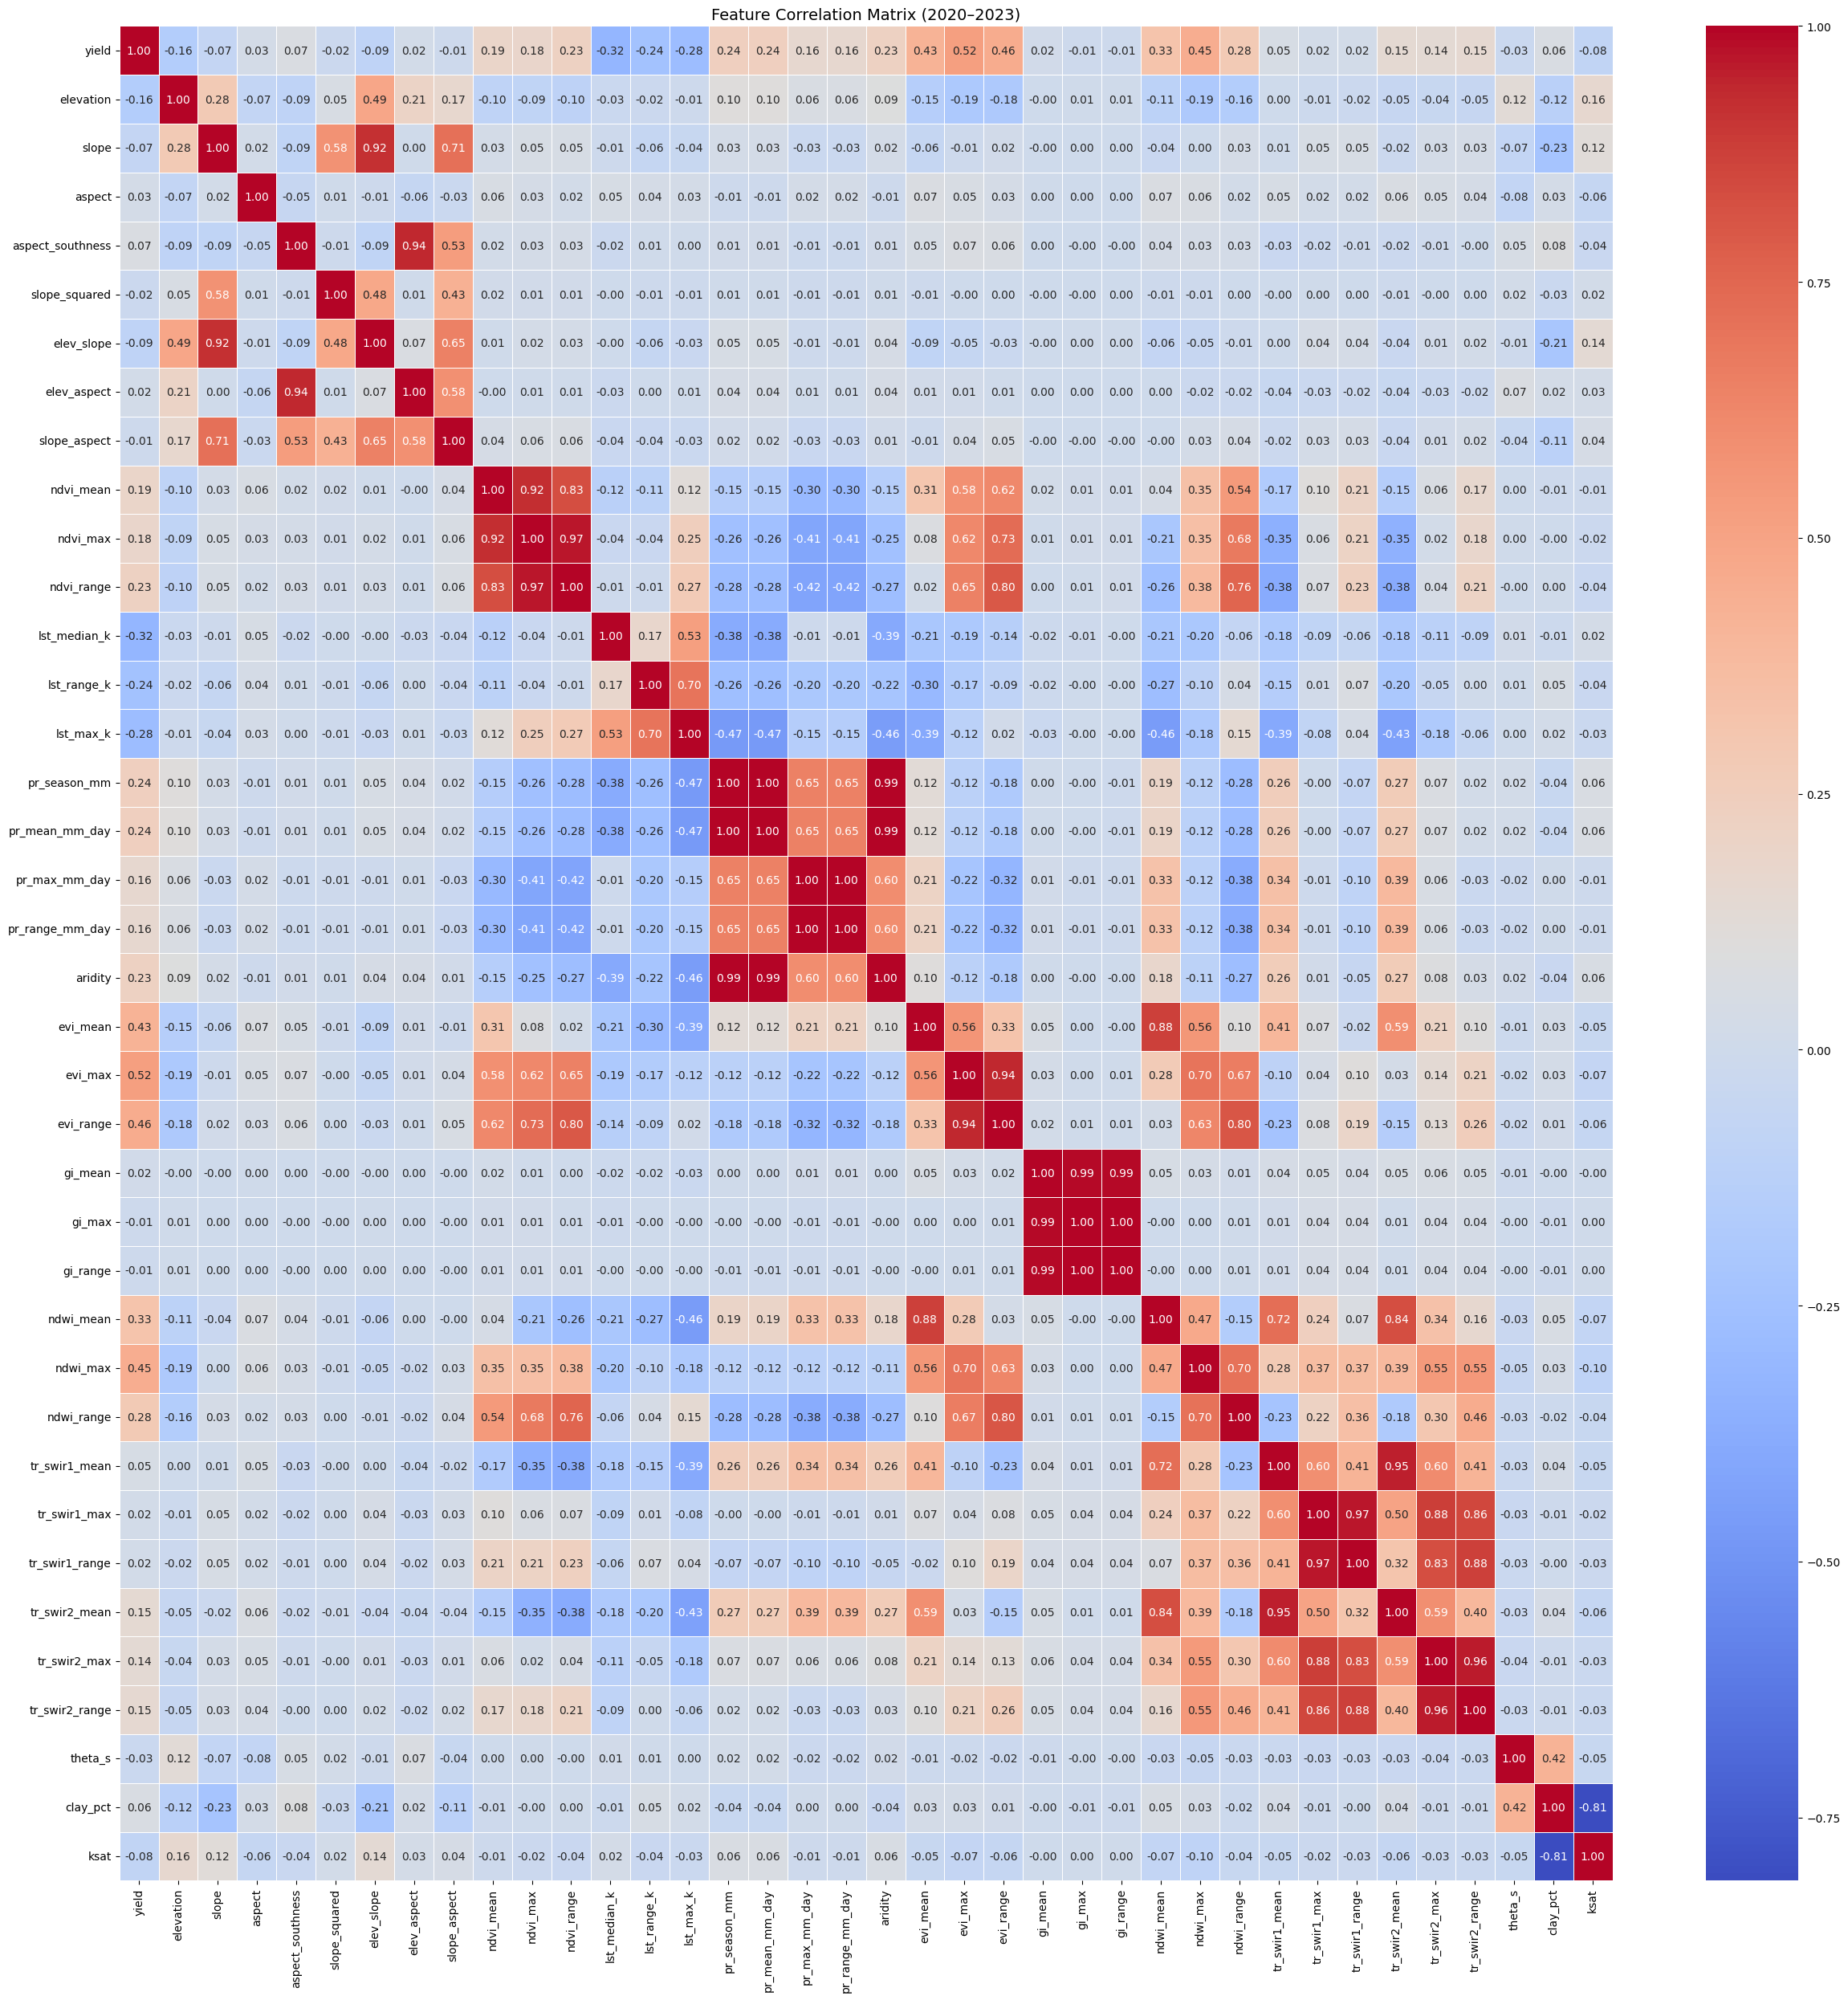

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ── choose your features ──────────────────────────────────────────
# corr_features = [
#     "elevation", "slope", "aspect",  "yield", "year", "slope_squared", "elevation_squared", "elev_slope", "elev_aspect", "ndvi_max", "ndvi_range",
#     "lst_mean_k", "lst_max_k", "lst_range_k", "pr_mean_mm_day", "pr_max_mm_day", "pr_range_mm_day",
#     "aspect_southness", "slope_aspect",
#     "ndvi_mean", "pr_season_mm", "aridity"
# ]

corr_features = ['yield', 'elevation', 'slope',
       'aspect', 'aspect_southness', 'slope_squared',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean',
       'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range', 'theta_s', 'clay_pct', 'ksat']

# ── select only those columns from the dataframe ─────────────────
df_features = df_map["2014-2024"][corr_features]

# ── compute correlation matrix ───────────────────────────────────
corr_matrix = df_features.corr()

# ── print raw numbers ────────────────────────────────────────────
print(corr_matrix)

# ── plot heatmap ─────────────────────────────────────────────────
plt.figure(figsize=(30, 30))
sns.heatmap(
    corr_matrix,
    annot=True,        # show correlation values
    cmap="coolwarm",   # color scheme
    fmt=".2f",         # format decimals
    linewidths=0.5
)
plt.title("Feature Correlation Matrix (2020–2023)", fontsize=14)
plt.show()


In [ ]:
list(range(2014,2024))

[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

In [ ]:
#Predicting on 2023 with 2020-2022

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# -------------------------------
# 0) Data & features
# -------------------------------
df = df_map["2014-2024"].copy()

features = ['elevation', 'slope',
       'aspect', 'aspect_southness', 'slope_squared',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean',
       'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range', 'theta_s', 'clay_pct', 'ksat'
]
target = "yield"

# Ensure year exists and is int-like

assert "year" in df.columns, "Missing 'year' column."
assert "field" in df.columns, "Missing 'field' column needed for grouping."

df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

# Basic NA handling
df = df.dropna(subset=features + [target, "year", "field"]).copy()

# sort by time (important for GroupTimeSeriesSplit)
df = df.sort_values(["year", "field"]).reset_index(drop=True)
# -------------------------------
# 1) Time-based split
# -------------------------------
mask_tr = df["year"].isin(list(range(2014,2021)))
mask_va = df["year"].isin(list(range(2021,2023)))
mask_te = df["year"].eq(2023)

X_tr = df.loc[mask_tr, features].to_numpy()
y_tr = df.loc[mask_tr, target].to_numpy()

X_va = df.loc[mask_va, features].to_numpy()
y_va = df.loc[mask_va, target].to_numpy()

X_te = df.loc[mask_te, features].to_numpy()
y_te = df.loc[mask_te, target].to_numpy()

print(f"Row counts | train: {X_tr.shape[0]}  val: {X_va.shape[0]}  test: {X_te.shape[0]}")

if X_tr.shape[0] == 0 or X_va.shape[0] == 0:
    raise ValueError("Train or Val split is empty. Check 'year' values and filters.")

# -------------------------------
# 2) DMatrices for XGBoost
# -------------------------------
dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=features)
dval   = xgb.DMatrix(X_va, label=y_va, feature_names=features)
dtest  = xgb.DMatrix(X_te, label=y_te, feature_names=features) if X_te.shape[0] > 0 else None

# -------------------------------
# 3) Regularized parameters
# -------------------------------
params = {
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "eta": 0.05,              # learning_rate
    "max_depth": 6,
    "min_child_weight": 10,
    "subsample": 0.7,
    "colsample_bytree": 0.8,
    "lambda": 2.0,            # L2
    "alpha": 0.01,            # L1
    "eval_metric": "rmse",
    "seed": 42,
    # "n_estimator" : 1000
}

num_boost_round = 2000
evals_result = {}

# -------------------------------
# 4) Train with early stopping on 2022
# -------------------------------
bst = xgb.train(
    params=params,
    # params={},
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=10,
    verbose_eval=False,
    evals_result=evals_result,
)

best_iter = bst.best_iteration
print(f"Best iteration: {best_iter} → using {best_iter + 1} trees")

# -------------------------------
# 5) Metrics helper (no 'squared=' kw)
# -------------------------------
def report(y_true, y_pred, label):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label:<6} R²: {r2: .3f}   MAE: {mae: .3f}   RMSE: {rmse: .3f}")

# Predict using best iteration
y_tr_pred = bst.predict(dtrain, iteration_range=(0, best_iter + 1))
y_va_pred = bst.predict(dval,   iteration_range=(0, best_iter + 1))

print("\n──── performance (yield units) ──────────────────────────")
report(y_tr, y_tr_pred, "Train")
report(y_va, y_va_pred, "Val")

if dtest is not None:
    y_te_pred = bst.predict(dtest, iteration_range=(0, best_iter + 1))
    report(y_te, y_te_pred, "Test")
else:
    print("Test   — skipped (no 2023 rows found).")

# -------------------------------
# 6) Feature importance (gain)
# -------------------------------
gain = bst.get_score(importance_type="gain")
imp = pd.Series(gain).reindex(features).fillna(0.0).sort_values(ascending=False)
print("\nTop feature importances (gain):\n", imp)


Row counts | train: 391247  val: 116707  test: 47743
Best iteration: 65 → using 66 trees

──── performance (yield units) ──────────────────────────
Train  R²:  0.792   MAE:  5.794   RMSE:  7.659
Val    R²:  0.315   MAE:  10.109   RMSE:  12.698
Test   R²:  0.097   MAE:  9.020   RMSE:  11.395

Top feature importances (gain):
 evi_max             1.326616e+06
aridity             4.932709e+05
pr_range_mm_day     2.610502e+05
pr_max_mm_day       2.484074e+05
gi_range            1.868868e+05
ndwi_max            1.755907e+05
pr_season_mm        1.527620e+05
ndvi_range          1.455007e+05
lst_range_k         1.366655e+05
pr_mean_mm_day      1.187635e+05
ndvi_max            8.246811e+04
lst_max_k           6.976605e+04
evi_range           6.777910e+04
gi_mean             6.329620e+04
tr_swir2_max        6.068281e+04
tr_swir1_mean       5.822815e+04
ndwi_mean           5.772839e+04
lst_median_k        5.461312e+04
gi_max              5.250103e+04
tr_swir2_mean       5.200501e+04
tr_swir2_range

In [5]:
df_map['2014-2024'].keys()

Index(['index', 'x', 'y', 'yield', 'field', 'year', 'elevation', 'slope',
       'aspect', 'aspect_southness', 'slope_squared', 'elevation_squared',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean',
       'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range', 'theta_s', 'clay_pct', 'ksat'],
      dtype='object')

2014
Fitting 10 folds for each of 80 candidates, totalling 800 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:59:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


Best params (CV, no ES): {'subsample': 0.7, 'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 400, 'min_child_weight': 6, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.7}


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [02:59:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [02:59:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [02:59:22] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is

++++++++++++++++++++++++++++++  2014 +++++++++++++++++++++++++++++++++++

Train R²: 0.7781436981332331
Test  R²: -2.011858700631535
Test  MAE: 22.6494202506218


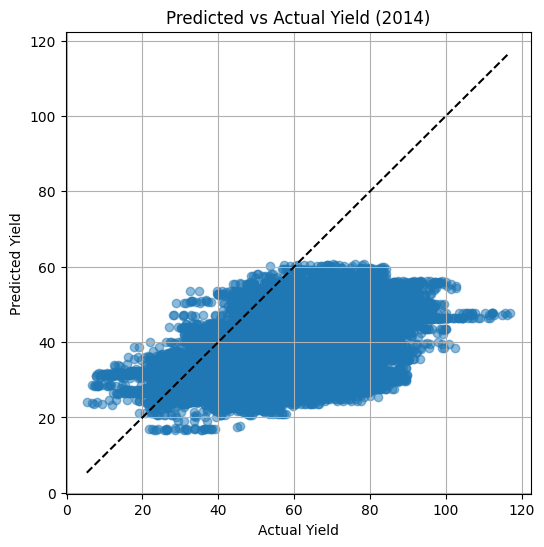

2015
Fitting 10 folds for each of 80 candidates, totalling 800 fits


In [ ]:
#-------------Light weight model training and testing on individual year prediction:--------------------------------

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

for year in range(2014,2025):
  test_year = year
  print ("==================================================================")
  print(test_year);
  target, year = "yield", "year"
  features =  ['elevation', 'slope',
        'aspect', 'aspect_southness', 'slope_squared', 'elevation_squared',
        'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max',
        'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
        'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
        'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
        'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean',
        'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
        'tr_swir2_range', 'theta_s', 'clay_pct', 'ksat'
  ]

  df       = df_map["2014-2024"].copy()
  train_df = df[df[year] != test_year]
  test_df  = df[df[year] == test_year]

  X_train, y_train, groups = train_df[features], train_df[target], train_df[year]
  X_test,  y_test          = test_df[features],  test_df[target]

  param_grid = {
      "n_estimators": [400, 600, 800, 1000, 1200],
      "max_depth": [4, 5, 6, 8],
      "learning_rate": [0.01, 0.03, 0.05, 0.1],
      "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
      "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
      "min_child_weight": [1, 3, 5, 6, 7],
      "gamma": [0, 0.1, 0.25, 0.5, 1.0],
      "reg_alpha": [0.0, 0.01, 0.1, 0.5, 1.0],
      "reg_lambda": [0.5, 1.0, 1.5, 2.0, 5.0],
      # optional: "max_bin": [256, 384, 512],
  }

  base = xgb.XGBRegressor(
      objective="reg:squarederror",
      tree_method="gpu_hist",
      n_jobs=-1,
      random_state=42,
      eval_metric="rmse",

      # NOTE: early_stopping_rounds will be used on the final refit only
  )

  cv = GroupKFold(n_splits=groups.nunique())

  # Use RandomizedSearch for speed; increase n_iter as budget allows
  grid = RandomizedSearchCV(
      estimator=base,
      param_distributions=param_grid,  # lists are fine; RS samples from them
      n_iter=80,                       # <-- tune budget
      scoring="r2",                    # or "neg_mean_absolute_error"
      cv=cv,
      n_jobs=-1,
      verbose=1,
      refit=True                       # <-- critical so best_estimator_ exists
  )

  grid.fit(X_train, y_train, groups=groups)
  print("Best params (CV, no ES):", grid.best_params_)

  # Final refit with EARLY STOPPING using a small internal validation slice
  last_train_year = sorted(groups.unique())[-1]
  val_mask = (train_df[year] == last_train_year)

  final_model = xgb.XGBRegressor(**grid.best_params_,
                                objective="reg:squarederror",
                                tree_method="hist",
                                 device= "cuda",
                                n_jobs=-1,
                                random_state=42,
                                eval_metric="rmse")
  final_model.set_params(early_stopping_rounds=250)

  final_model.fit(
      X_train[~val_mask], y_train[~val_mask],
      eval_set=[(X_train[val_mask], y_train[val_mask])],
      verbose=False
  )

  # Evaluate
  y_pred_train = final_model.predict(X_train)
  y_pred_test  = final_model.predict(X_test)


  print("++++++++++++++++++++++++++++++ ", test_year, "+++++++++++++++++++++++++++++++++++")
  print("\nTrain R²:", r2_score(y_train, y_pred_train))
  print("Test  R²:", r2_score(y_test, y_pred_test))
  print("Test  MAE:", mean_absolute_error(y_test, y_pred_test))
  # print("Test RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))


  plt.figure(figsize=(6,6))
  plt.scatter(y_test, y_pred_test, alpha=0.5)
  lims = [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())]
  plt.plot(lims, lims, 'k--')
  plt.xlabel("Actual Yield")
  plt.ylabel("Predicted Yield")
  plt.title(f"Predicted vs Actual Yield ({test_year})")
  plt.grid(True)
  plt.show()


In [ ]:
# very rigorous training and tuning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# -----------------------------
# Config
# -----------------------------
test_year = 2023   # change this to the year you want to hold out
target = "yield"
year = "year"
features = ['elevation', 'slope',
       'aspect', 'aspect_southness', 'slope_squared', 'elevation_squared',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean',
       'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range', 'theta_s', 'clay_pct', 'ksat'
]


# -----------------------------
# Train / Test Split
# -----------------------------
df = df_map["2014-2024"].copy()

train_df = df[df[year] != test_year]
test_df  = df[df[year] == test_year]

X_train, y_train, groups = train_df[features], train_df[target], train_df[year]
X_test,  y_test          = test_df[features], test_df[target]

# -----------------------------
# Grid Search CV with GroupKFold (group = year)
# -----------------------------

param_grid = {
    "n_estimators": [400, 600, 800, 1000,1200,1500, 2000],
    "max_depth": [4, 5, 6, 8],
    "learning_rate": [ 0.01, 0.03, 0.06, 0.1],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 3, 5, 6, 7],
    "gamma": [0, 0.1, 0.25, 0.5, 1.0],
    "reg_alpha": [0.0, 0.01, 0.1, 0.5, 1.0],
    "reg_lambda": [0.5, 1.0, 1.5, 2.0, 5.0],
}

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    tree_method="gpu_hist",
     predictor="gpu_predictor",
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=250,
    eval_metric="rmse"
)

cv = GroupKFold(n_splits=len(groups.unique()))  # one fold per year

grid = GridSearchCV(
    model,
    param_grid,
    scoring="r2",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train, groups=groups)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)

# -----------------------------
# Evaluate
# -----------------------------
y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

print("Year:")
print("\nTrain R²:", r2_score(y_train, y_pred_train))
print("Test  R²:", r2_score(y_test, y_pred_test))
print("Test  MAE:", mean_absolute_error(y_test, y_pred_test))
# print("Test RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))

# -----------------------------
# Plot Predicted vs Actual
# -----------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
lims = [min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())]
plt.plot(lims, lims, 'k--')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title(f"Predicted vs Actual Yield ({test_year})")
plt.grid(True)
plt.show()

Fitting 10 folds for each of 1750000 candidates, totalling 17500000 fits


PicklingError: Could not pickle the task to send it to the workers.


=== Leave-One-Year-Out CV (2014–2022) ===
 val_year  n_val        R2       MAE  best_rounds
     2014  28536 -0.925013 17.356956            1
     2015  61865 -0.189705 14.094394          377
     2016  50860  0.065560 13.597527           34
     2017  57168  0.412696  9.562424          961
     2018  53371  0.127572  9.825480          122
     2019  67031 -0.499875  9.786253          331
     2020  72416  0.189847 12.431212          244
     2021  54042  0.423650  7.955721          592

=== CV Summary ===
R2_mean: -0.04940844275812355
R2_median: 0.09656637646448779
MAE_mean: 11.826245801866172
MAE_median: 11.128346063248726
best_rounds_median: 287
best_rounds_mean: 332.75

=== Test on 2023 ===
Samples (2023): 47743
R2:   0.150345
MAE:  8.774771
{'elevation': 70527.1796875, 'aspect': 27013.380859375, 'aspect_southness': 19391.58984375, 'elev_slope': 29784.251953125, 'elev_aspect': 15839.42578125, 'slope_aspect': 20236.232421875, 'ndvi_mean': 88102.2890625, 'ndvi_range': 138618.28125, 

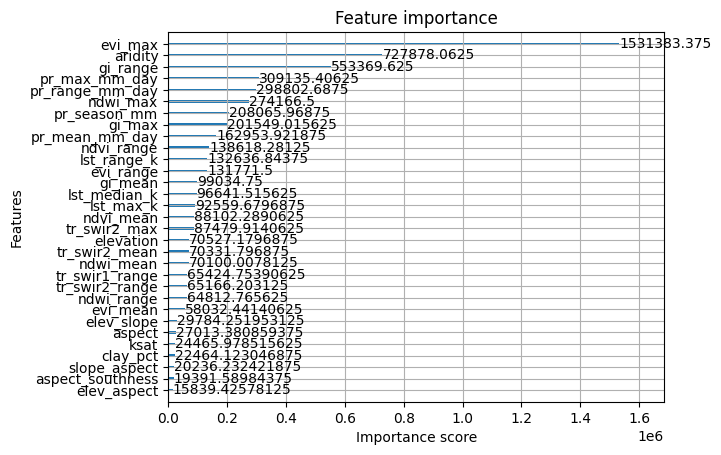

In [ ]:
# Let's try training remove each year once

# xgb_leave_one_year_out_2014_2022_then_test_2023.py
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

SEED       = 42
YEAR_COL   = "year"
TARGET_COL = "yield"

# --- 0) Take your combined frame and filter to 2014–2023 (drop 2024) ---
df = df_map["2014-2024"].copy()
df = df[df[YEAR_COL].between(2014, 2023)].reset_index(drop=True)

# --- 1) Build features ---
# Exclude target and year from raw feature set
exclude_cols = {YEAR_COL, TARGET_COL}
raw_feature_cols = [c for c in df.columns if c not in exclude_cols]

# One-hot encode any non-numeric columns (e.g., field) but keep column names stable across folds
df_features = pd.get_dummies(df[raw_feature_cols], drop_first=False)
df_all = pd.concat([df[[YEAR_COL, TARGET_COL]].reset_index(drop=True), df_features.reset_index(drop=True)], axis=1)

# Drop rows with missing features or target (simple & safe default)
df_all = df_all.dropna(subset=[TARGET_COL] + list(df_features.columns))

feature_cols = [
     'elevation',
       'aspect', 'aspect_southness',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range',
     'tr_swir1_range',
     'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range',
     'clay_pct',
          'ksat'
     ]


# --- 2) Base XGB params (same model each round; early stopping picks best trees) ---
BASE_PARAMS = dict(
    n_estimators=5000,       # high cap; trimmed by early stopping
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=SEED,
    eval_metric="rmse",
    n_jobs=-1,
    tree_method="hist",      # use "gpu_hist" if you have a GPU
    early_stopping_rounds=200
)

# --- 3) Leave-one-year-out CV on 2014–2022 ---
years_cv = list(range(2014, 2023))[:-1]  # -> 2014..2022
cv_records, best_iters = [], []

for y_val in years_cv:
    train_mask = df_all[YEAR_COL] != y_val
    val_mask   = df_all[YEAR_COL] == y_val

    X_train = df_all.loc[train_mask, feature_cols].values
    y_train = df_all.loc[train_mask, TARGET_COL].values

    X_val   = df_all.loc[val_mask, feature_cols].values
    y_val_a = df_all.loc[val_mask, TARGET_COL].values

    model = XGBRegressor(**BASE_PARAMS)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val_a)],


        verbose=False,
    )

    y_pred = model.predict(X_val)
    r2   = r2_score(y_val_a, y_pred)
    mae  = mean_absolute_error(y_val_a, y_pred)
    # rmse = mean_squared_error(y_val_a, y_pred, squared=False)

    best_rounds = getattr(model, "best_iteration", None)
    if best_rounds is not None:
        best_rounds = int(best_rounds) + 1
        best_iters.append(best_rounds)

    cv_records.append({
        "val_year": y_val,
        "n_val": int(val_mask.sum()),
        "R2": r2,
        # "RMSE": rmse,
        "MAE": mae,
        "best_rounds": best_rounds
    })

cv_df = pd.DataFrame(cv_records).sort_values("val_year")
print("\n=== Leave-One-Year-Out CV (2014–2022) ===")
print(cv_df.to_string(index=False))

# CV summary
cv_summary = {
    "R2_mean":  cv_df["R2"].mean(),
    "R2_median":cv_df["R2"].median(),
    # "RMSE_mean":cv_df["RMSE"].mean(),
    # "RMSE_median":cv_df["RMSE"].median(),
    "MAE_mean": cv_df["MAE"].mean(),
    "MAE_median":cv_df["MAE"].median(),
}
if len(best_iters):
    cv_summary["best_rounds_median"] = int(np.median(best_iters))
    cv_summary["best_rounds_mean"]   = float(np.mean(best_iters))

print("\n=== CV Summary ===")
for k, v in cv_summary.items():
    print(f"{k}: {v}")

# --- 4) Final train on 2014–2022, test on 2023 ---
train_mask = df_all[YEAR_COL].between(2014, 2021)
val_mask = df_all[YEAR_COL] == 2022
test_mask  = df_all[YEAR_COL] == 2023

X_train = df_all.loc[train_mask, feature_cols]
y_train = df_all.loc[train_mask, TARGET_COL]
X_val   = df_all.loc[val_mask, feature_cols]
y_val_a = df_all.loc[val_mask, TARGET_COL]
X_test  = df_all.loc[test_mask,  feature_cols]
y_test  = df_all.loc[test_mask,  TARGET_COL]

final_params = BASE_PARAMS.copy()
if len(best_iters):
    final_params["n_estimators"] = int(np.median(best_iters))
else:
    final_params["n_estimators"] = 2000  # fallback

final_model = XGBRegressor(**final_params)
final_model.fit(X_train, y_train, eval_set=[(X_val, y_val_a)], verbose=False)

y_pred_test = final_model.predict(X_test)
r2_test  = r2_score(y_test, y_pred_test)
# rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test  = mean_absolute_error(y_test, y_pred_test)

print("\n=== Test on 2023 ===")
print(f"Samples (2023): {X_test.shape[0]}")
print(f"R2:   {r2_test:.6f}")
# print(f"RMSE: {rmse_test:.6f}")
print(f"MAE:  {mae_test:.6f}")

from xgboost import plot_importance


importances = final_model.get_booster().get_score(importance_type="gain")
print(importances)
importance_df = (
    pd.DataFrame.from_dict(importances, orient="index", columns=["importance"])
    .sort_values("importance", ascending=False)
)
print(importance_df)

plot_importance(final_model, importance_type="gain")
plt.show()


In [ ]:
#get the 95 percentile of the yield
# print(df_map["2014-2023"]['yield'].quantile(0.05))

Five_percent = df_map["2014-2024"]['yield'].quantile(0.05)
Ninety_five_percent = df_map["2014-2024"]['yield'].quantile(0.95)

df_map['2014-2024'] = df_map['2014-2024'][(df_map["2014-2024"]['yield'] > Five_percent) & (df_map["2014-2024"]['yield'] < Ninety_five_percent) ]
# df_map['2014-2023'] = df_map['2014-2023'][df_map['2014-2023']['yield']<21.4].count()
# df_map['2014-2023'] = df_map['2014-2023'][df_map['2014-2023']['yield']<df_map["2014-2023"]['yield'].quantile(0.95)]
# df_map["2014-2023"]['yield'].describe()

In [ ]:
df_map['2014-2024'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 550105 entries, 0 to 611164
Data columns (total 44 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              550105 non-null  int64  
 1   x                  550105 non-null  float64
 2   y                  550105 non-null  float64
 3   yield              550105 non-null  float64
 4   field              550105 non-null  object 
 5   year               550105 non-null  int64  
 6   elevation          550105 non-null  float32
 7   slope              550105 non-null  float32
 8   aspect             550105 non-null  float32
 9   aspect_southness   550105 non-null  float32
 10  slope_squared      550105 non-null  float32
 11  elevation_squared  550105 non-null  float32
 12  elev_slope         550105 non-null  float32
 13  elev_aspect        550105 non-null  float32
 14  slope_aspect       550105 non-null  float32
 15  ndvi_mean          550105 non-null  float64
 16  ndvi_ma

In [ ]:
df_map["2014-2023Scaled"].to_parquet("/content/drive/MyDrive/Colab Notebooks/Data For Yield Prediction/Data/df_map_2014_2023Scaled.parquet")

In [ ]:
#Predicting on 2023 with 2020-2022 with hyperparameters tuning

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import random

# -------------------------------
# 0) Data & features
# -------------------------------
df = df_map["2014-2023"].copy()

# features = [
#     # 'elevation',
#           #  'slope',
#     # 'aspect',
#             'aspect_southness',
#             # 'slope_squared',
#             'elevation_squared',
#       #  'elev_slope', 'elev_aspect', 'slope_aspect',
#             # 'ndvi_mean',
#             'ndvi_max',
#     'ndvi_range',
#             'lst_mean_k',
#     'lst_max_k',
#             'lst_range_k',
#             'pr_season_mm',
#     'pr_mean_mm_day',
#     'pr_max_mm_day',
#     'pr_range_mm_day',
#             'aridity',
#             'ndvi_pr_interaction', 'lst_ndvi_interaction',
#        'elev_precip_interaction'
#     # 'theta_s'
#     # 'clay_pct'
#        ]

features = [
    "ndvi_max",              # vegetation vigor, strongest correlation
    "ndvi_mean",             # average vegetation signal, adds nuance
    "ndvi_pr_interaction",   # vegetation × precipitation interaction
    "pr_max_mm_day",         # precipitation extremes
    "elevation",             # terrain factor, moderately negative correlation
    "slope",                 # may interact with elevation
    "clay_pct",              # soil property
    "ksat",                   # soil permeability
    "pr_season_mm",
    "lst_max_k",
    "aspect_southness",
    # "aridity",
    "swir2_mean",
    # "swir_ndvi_interaction"
    "ndwi_mean",
    'ndwi_range',
    # 'ndwi_max',
    'gi_mean',
    # 'gi_max',
    # 'gi_range',
    'evi_mean',

    # 'evi_range',
    # 'evi_max'

]

# features = [
#     'ndvi_max', 'ndvi_range','lst_ndvi_interaction', 'pr_range_mm_day', 'aridity', 'swir2_range', 'elevation', 'slope', 'clay_pct'
# ]


target = "yield"

# Ensure year exists and is int-like

assert "year" in df.columns, "Missing 'year' column."
assert "field" in df.columns, "Missing 'field' column needed for grouping."

df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

# Basic NA handling
df = df.dropna(subset=features + [target, "year", "field"]).copy()

# sort by time (important for GroupTimeSeriesSplit)
df = df.sort_values(["year", "field"]).reset_index(drop=True)
# -------------------------------
# 1) Time-based split
# -------------------------------
mask_tr = ~df["year"].isin([2023,2022])
mask_va = df["year"].eq(2022)
mask_te = df["year"].eq(2023)

X_tr = df.loc[mask_tr, features].to_numpy()
y_tr = df.loc[mask_tr, target].to_numpy()

X_va = df.loc[mask_va, features].to_numpy()
y_va = df.loc[mask_va, target].to_numpy()

X_te = df.loc[mask_te, features].to_numpy()
y_te = df.loc[mask_te, target].to_numpy()

print(f"Row counts | train: {X_tr.shape[0]}  val: {X_va.shape[0]}  test: {X_te.shape[0]}")

if X_tr.shape[0] == 0 or X_va.shape[0] == 0:
    raise ValueError("Train or Val split is empty. Check 'year' values and filters.")

# -------------------------------
# 2) DMatrices for XGBoost
# -------------------------------
dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=features)
dval   = xgb.DMatrix(X_va, label=y_va, feature_names=features)
dtest  = xgb.DMatrix(X_te, label=y_te, feature_names=features) if X_te.shape[0] > 0 else None

# -------------------------------
# 3) Regularized parameters
# -------------------------------
params = {
    "objective": "reg:absoluteerror",
    "tree_method": "hist",
    "eta": 0.01,              # learning_rate
    # "max_depth": 6,
    "min_child_weight": 10,
    "subsample": 0.7,
    "colsample_bytree": 0.8,
    "lambda": 2.0,            # L2
    "alpha": 0.01,            # L1
    "eval_metric": "rmse",
    "seed": 42,

}

num_boost_round = 1000


#tuning the hyper parameters

evals_result = {}
def try_params(base_params, dtrain, dval, num_boost_round = 2000, esr = 50):
  evals_result = {}
  bst = xgb.train(base_params, dtrain, num_boost_round=num_boost_round, evals=[(dtrain, "train"), (dval, "val")], early_stopping_rounds=esr, verbose_eval=False, evals_result=evals_result)
  # print("Best Results", bst)
  best_iter = bst.best_iteration
  best_rmse = evals_result['val']['rmse'][best_iter]
  return best_rmse, best_iter, bst

rmse,it,model = try_params(params, dtrain, dval, num_boost_round = 2000, esr = 50)
print(f"[trial] best val RMSE = {rmse:.4f} at {it+1} tress")


def sample_params():
  # These are the fixed, safe defaults we’ll always include. We’ll add the tunable pieces (eta, max_depth, etc.) next, then return p.
  p = {
      "objective": "reg:squarederror",
      "tree_method": "hist",
      "seed": 42,
      "eval_metric": ["rmse", "mae"],
      # "booster" : "dart"
      }

  p["eta"] =10 ** random.uniform(-2, -1)
  p['max_depth'] = random.choice([1,2,3,4,5,6])
  p['min_child_weight'] = random.choice([1,2,5,10])
  p["subsample"] = random.uniform(0.6, 0.95)
  p["colsample_bytree"] = random.uniform(0.6, 0.95)
  p["lambda"] = 10 ** random.uniform(-2, 2)   # L2 regularization
  p["alpha"] = 10 ** random.uniform(-3, 0)   # L1 regularization

  return p

N_CANDIDATES = 25



best = {"rmse": float("inf"), "iter": None, "params": None}

for i in range(N_CANDIDATES):
  cand = sample_params()
  rmse, it, _ = try_params(cand, dtrain, dval)
  if rmse < best["rmse"]:
    best.update({"rmse": rmse, "iter": it, "params": cand})
  print(f"[{i+1}/{N_CANDIDATES}] val RMSE={rmse:.4f} at {it+1} trees")

print(f"[tuning] best val RMSE={best['rmse']:.4f} at {best['iter']+1} trees")
params.update(best["params"])

print("Best Params: ",params)

# -------------------------------
# 4) Train with early stopping on 2022
# -------------------------------
bst = xgb.train(
    params=params,

    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=10,
    verbose_eval=False,
    evals_result=evals_result,
)

best_iter = bst.best_iteration
print(f"Best iteration: {best_iter} → using {best_iter + 1} trees")

# -------------------------------
# 5) Metrics helper (no 'squared=' kw)
# -------------------------------
def report(y_true, y_pred, label):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label:<6} R²: {r2: .3f}   MAE: {mae: .3f}   RMSE: {rmse: .3f}")

# Predict using best iteration
y_tr_pred = bst.predict(dtrain, iteration_range=(0, best_iter + 1))
y_va_pred = bst.predict(dval,   iteration_range=(0, best_iter + 1))

print("\n──── performance (yield units) ──────────────────────────")
report(y_tr, y_tr_pred, "Train")
report(y_va, y_va_pred, "Val")

if dtest is not None:
    y_te_pred = bst.predict(dtest, iteration_range=(0, best_iter + 1))
    report(y_te, y_te_pred, "Test")
else:
    print("Test   — skipped (no 2023 rows found).")

# -------------------------------
# 6) Feature importance (gain)
# -------------------------------
gain = bst.get_score(importance_type="gain")
imp = pd.Series(gain).reindex(features).fillna(0.0).sort_values(ascending=False)
print("\nTop feature importances (gain):\n", imp)


Row counts | train: 399041  val: 55339  test: 42884
[trial] best val RMSE = 13.0528 at 45 tress
[1/25] val RMSE=11.9018 at 196 trees
[2/25] val RMSE=12.8805 at 8 trees
[3/25] val RMSE=12.0695 at 56 trees
[4/25] val RMSE=12.8648 at 15 trees
[5/25] val RMSE=12.4560 at 124 trees
[6/25] val RMSE=12.7771 at 121 trees
[7/25] val RMSE=13.2183 at 1 trees
[8/25] val RMSE=11.7120 at 184 trees
[9/25] val RMSE=13.2065 at 1 trees
[10/25] val RMSE=12.5212 at 107 trees
[11/25] val RMSE=11.8950 at 276 trees
[12/25] val RMSE=12.4005 at 15 trees
[13/25] val RMSE=12.3455 at 75 trees
[14/25] val RMSE=13.0479 at 8 trees
[15/25] val RMSE=13.2117 at 1 trees
[16/25] val RMSE=12.9387 at 15 trees
[17/25] val RMSE=12.9682 at 1 trees
[18/25] val RMSE=12.5906 at 73 trees
[19/25] val RMSE=13.2143 at 1 trees
[20/25] val RMSE=12.1984 at 394 trees
[21/25] val RMSE=11.6973 at 220 trees
[22/25] val RMSE=13.2119 at 8 trees
[23/25] val RMSE=11.6169 at 363 trees
[24/25] val RMSE=13.0965 at 8 trees
[25/25] val RMSE=13.0530 

In [ ]:
# df_map[2015].info()
df_map[2018]= df_map[2019].drop(columns=['swir1_mean',
       'swir1_max', 'swir1_min', 'swir1_range', 'swir2_mean', 'swir2_max',
       'swir2_min', 'swir2_range'])
df_map[2018].keys()

Index(['x', 'y', 'yield', 'field', 'year', 'elevation', 'slope', 'aspect',
       'aspect_southness', 'slope_squared', 'elevation_squared', 'elev_slope',
       'elev_aspect', 'slope_aspect', 'lst_mean_k', 'lst_max_k', 'lst_range_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'theta_s', 'clay_pct', 'ksat', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range'],
      dtype='object')

In [ ]:
# ============================
# Random Forest (Annelise-style)
# Train: 2020–2022 | Predict: 2023
# ============================

# 0) Imports & setup
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

SEED = 42
np.random.seed(SEED)

# OPTIONAL: Mount Drive if you want to save outputs there
# from google.colab import drive
# drive.mount('/content/drive')

# ─────────────────────────────────────────────────────────────────────────
# 1) Configuration — keep these aligned with Annelise's script
# ─────────────────────────────────────────────────────────────────────────

TARGET_COL = "yield"  # In Annelise's GEE, target is 'b1'. If your df uses 'yield', we'll alias.

# Exact predictor names used by Annelise (must exist in your dataframe after optional renaming)
PREDICTORS = [
    'evi_max', 'evi_mean', 'evi_range',
    'gi_max', 'gi_mean', 'gi_range',
    'lst_mean_k', 'lst_range_k',
    'ndvi_max', 'ndvi_mean', 'ndvi_range',
    'ndwi_max', 'ndwi_mean', 'ndwi_range',
    'swir1_max', 'swir1_mean', 'swir1_range',
    'swir2_min', 'swir2_max', 'swir2_range',
    'aspect', 'clay_pct', 'ksat', 'slope', 'theta_s', 'pr_season_mm', 'aridity'
]

# Train/predict years (edit if you truly have 2015–2022)
YEARS_TRAIN = [2014,2015,2016,2017,2018,2019,2020, 2021, 2022]
YEAR_PRED   = 2023

# Basic hygiene
df_all = df_map["2014-2023"].copy()
# Ensure 'year' is present
if "year" not in df_all.columns:
    raise ValueError("Your dataframe must contain a 'year' column to split by year.")

# If your target column isn't named 'b1', alias it to 'b1' to match Annelise
if TARGET_COL not in df_all.columns:
    # Common alias:
    if "yield" in df_all.columns:
        df_all[TARGET_COL] = df_all["yield"]
    else:
        raise ValueError("Target 'b1' not found and 'yield' not present to alias. Please set TARGET_COL appropriately.")


# Check missing predictors
missing = [c for c in PREDICTORS if c not in df_all.columns]
if len(missing) > 0:
    print("WARNING: These predictor columns are missing from your dataframe:")
    for m in missing:
        print("  -", m)
    print("\nPlease update RENAME_MAP or your data source so these columns exist.\nProceeding will drop rows with missing values, but "
          "completely missing columns must be provided to truly mirror Annelise's model.")
    # You may choose to raise an error instead:
    # raise KeyError(f"Missing predictors: {missing}")

# ─────────────────────────────────────────────────────────────────────────
# 4) Split by year exactly like GEE flow: train on 2020–2022, predict 2023
# ─────────────────────────────────────────────────────────────────────────
train_mask = df_all["year"].isin(YEARS_TRAIN)
test_mask  = df_all["year"] == YEAR_PRED

df_tr = df_all.loc[train_mask].copy()
df_te = df_all.loc[test_mask].copy()

# Drop rows with any NA in predictors or target
cols_needed = PREDICTORS + [TARGET_COL]
df_tr = df_tr.dropna(subset=cols_needed)
df_te = df_te.dropna(subset=PREDICTORS + [TARGET_COL])  # we also keep actual to score

X_tr = df_tr[PREDICTORS].values
y_tr = df_tr[TARGET_COL].values

X_te = df_te[PREDICTORS].values
y_te = df_te[TARGET_COL].values

print(f"Train shape: X={X_tr.shape}, y={y_tr.shape}")
print(f"Test  shape: X={X_te.shape}, y={y_te.shape}")

# ─────────────────────────────────────────────────────────────────────────
# 5) Train the Random Forest to match Annelise:
#    ee.Classifier.smileRandomForest(150).setOutputMode('REGRESSION')
#    → sklearn RandomForestRegressor(n_estimators=150)
#    No scaling needed for RF.
# ─────────────────────────────────────────────────────────────────────────
rf = RandomForestRegressor(
    n_estimators=150,
    random_state=SEED,
    n_jobs=-1,
    # Keep defaults close to Smile's general behavior; you can tune if desired:
    # max_features='auto' is deprecated; 'sqrt' is common for RF
    max_features='sqrt'
)

rf.fit(X_tr, y_tr)

# ─────────────────────────────────────────────────────────────────────────
# 6) Predict 2023 and evaluate (Obs vs Pred)
# ─────────────────────────────────────────────────────────────────────────
pred_te = rf.predict(X_te)

r2  = r2_score(y_te, pred_te)
mae = mean_absolute_error(y_te, pred_te)
# rmse = mean_squared_error(y_te, pred_te, squared=False)

print("\n=== 2023 Performance (Annelise-style RF) ===")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
# print(f"RMSE : {rmse:.4f}")

# Build Obs vs Pred dataframe (mirrors the Drive export Annelise does)
obs_vs_pred = pd.DataFrame({
    "actual_yield":    y_te,
    "predicted_yield": pred_te
})

# If you have a unique ID like 'system:index' from GEE in your local data, add it for traceability
# if 'system:index' in df_te.columns:
#     obs_vs_pred['system:index'] = df_te['system:index'].values

# Save to Colab runtime
# out_path = f"/content/Obs_v_Pred_{CROP}_train_{min(YEARS_TRAIN)}-{max(YEARS_TRAIN)}_pred_{YEAR_PRED}.csv"
# obs_vs_pred.to_csv(out_path, index=False)
# print(f"\nSaved: {out_path}")

# Optionally also save to Drive
# drive_path = f"/content/drive/MyDrive/{CROP}_Obs_v_Pred_{min(YEARS_TRAIN)}-{max(YEARS_TRAIN)}_to_{YEAR_PRED}.csv"
# obs_vs_pred.to_csv(drive_path, index=False)
# print(f"Saved to Drive: {drive_path}")


Train shape: X=(454380, 27), y=(454380,)
Test  shape: X=(42884, 27), y=(42884,)

=== 2023 Performance (Annelise-style RF) ===
R²   : -0.0445
MAE  : 9.2477


In [ ]:
df_map["2014-2024"].keys()

Index(['index', 'x', 'y', 'yield', 'field', 'year', 'elevation', 'slope',
       'aspect', 'aspect_southness', 'slope_squared', 'elevation_squared',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean',
       'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range', 'theta_s', 'clay_pct', 'ksat'],
      dtype='object')

In [ ]:
  # ──────────────────────────────────────────────────────────────
# Random Forest: Train on 2020–2022 → Predict 2023 yield
# ──────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# -------------------------------
# 0) Data prep
# -------------------------------
# features =[
#     "ndvi_max",              # vegetation vigor, strongest correlation
#     "ndvi_mean",             # average vegetation signal, adds nuance
#     "ndvi_pr_interaction",   # vegetation × precipitation interaction
#     "pr_max_mm_day",         # precipitation extremes
#     "elevation",             # terrain factor, moderately negative correlation
#     "slope",                 # may interact with elevation
#     "clay_pct",              # soil property
#     "ksat",                   # soil permeability
#     "pr_season_mm",
#     "lst_max_k",
#     "aspect_southness",
#     # "aridity",
#     "swir2_mean",
#     # "swir_ndvi_interaction"
#     "ndwi_mean",
#     'ndwi_range',
#     # 'ndwi_max',
#     'gi_mean',
#     # 'gi_max',
#     # 'gi_range',
#     'evi_mean',

#     # 'evi_range',
#     # 'evi_max'

# ]


# features =[
#     'evi_max', 'evi_mean', 'evi_range',
#     'gi_max', 'gi_mean', 'gi_range',
#     'lst_median_k', 'lst_range_k',
#     'ndvi_max', 'ndvi_mean', 'ndvi_range',
#     'ndwi_max', 'ndwi_mean', 'ndwi_range',
#     'tr_swir1_mean', 'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
#    'tr_swir2_range',
#     'aspect', 'clay_pct', 'ksat', 'slope', 'theta_s', 'pr_season_mm', 'aridity'
# ]



features = [
     'elevation',
       'aspect', 'aspect_southness',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range',
     'tr_swir1_range',
     'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range',
     'clay_pct',
          'ksat'
     ]




target = "yield"

df = df_map["2014-2024"]  # full data

# split train (2020–22) and test (2023)
train_mask = df["year"].isin([2014,2015,2016,2017,2018,2019,2020, 2021, 2022])
test_mask  = df["year"] == 2023

X_train = df.loc[train_mask, features].values
y_train = np.log1p(df.loc[train_mask, target].values)  # log-transform
X_test  = df.loc[test_mask, features].values
y_test  = np.log1p(df.loc[test_mask, target].values)

# -------------------------------
# 1) Model
# -------------------------------
rf = RandomForestRegressor(
    n_estimators=300,       # number of trees
    max_depth= 3,         # allow trees to grow deep
    n_jobs=-1,              # use all CPUs
    random_state=42
)

# -------------------------------
# 2) Train
# -------------------------------
rf.fit(X_train, y_train)

# -------------------------------
# 3) Evaluate
# -------------------------------
y_pred = rf.predict(X_test)

print("─── Random Forest Performance (log yield) ───")
print(f"Test R²:   {r2_score(y_test, y_pred):.3f}")
print(f"Test MAE:  {mean_absolute_error(y_test, y_pred):.3f}")
# print(f"Test RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")


─── Random Forest Performance (log yield) ───
Test R²:   0.056
Test MAE:  0.227


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import itertools, random

# -------------------------------
# 0) Data & features
# -------------------------------
df = df_map["2014-2024"].copy()

# features =  [
#     # 'elevation',
#           #  'slope','aspect',
#             'aspect_southness',
#             # 'slope_squared',
#             'elevation_squared',
#       #  'elev_slope', 'elev_aspect', 'slope_aspect',
#             # 'ndvi_mean',
#             'ndvi_max',
#     'ndvi_range',
#             'lst_mean_k',
#     'lst_max_k',
#             'lst_range_k',
#             'pr_season_mm',
#     'pr_mean_mm_day',
#     'pr_max_mm_day',
#     'pr_range_mm_day',
#             'aridity',
#             'ndvi_pr_interaction', 'lst_ndvi_interaction',
#        'elev_precip_interaction'
#        ]


# fatures = [
#     'evi_max', 'evi_mean', 'evi_range',
#     'gi_max', 'gi_mean', 'gi_range',
#     'lst_mean_k', 'lst_range_k',
#     'ndvi_max', 'ndvi_mean', 'ndvi_range',
#     'ndwi_max', 'ndwi_mean', 'ndwi_range',
#     'swir1_max', 'swir1_mean', 'swir1_range',
#     'swir2_min', 'swir2_max', 'swir2_range',
#     'aspect', 'clay_pct', 'ksat', 'slope', 'theta_s', 'pr_season_mm', 'aridity'
# ]



features = [
     'elevation',
       'aspect', 'aspect_southness',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range',
     'tr_swir1_range',
     'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range',
     'clay_pct',
          'ksat'
     ]

target = "yield"

assert "year" in df.columns, "Missing 'year' column."
assert "field" in df.columns, "Missing 'field' column needed for grouping."
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

# Basic NA handling
df = df.dropna(subset=features + [target, "year", "field"]).copy()
df = df.sort_values(["year", "field"]).reset_index(drop=True)

# -------------------------------
# 1) Time-based split
# -------------------------------
mask_tr = df["year"].isin([2020, 2021])
mask_va = df["year"].eq(2022)
mask_te = df["year"].eq(2023)

X_tr = df.loc[mask_tr, features].to_numpy()
y_tr = df.loc[mask_tr, target].to_numpy()
X_va = df.loc[mask_va, features].to_numpy()
y_va = df.loc[mask_va, target].to_numpy()
X_te = df.loc[mask_te, features].to_numpy()
y_te = df.loc[mask_te, target].to_numpy()

print(f"Row counts | train: {X_tr.shape[0]}  val: {X_va.shape[0]}  test: {X_te.shape[0]}")
if X_tr.shape[0] == 0 or X_va.shape[0] == 0:
    raise ValueError("Train or Val split is empty. Check 'year' values and filters.")

dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=features)
dval   = xgb.DMatrix(X_va, label=y_va, feature_names=features)
dtest  = xgb.DMatrix(X_te, label=y_te, feature_names=features) if X_te.shape[0] > 0 else None

# -------------------------------
# 2) Search space (your grid)
# -------------------------------
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [500, 1000, 1500],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [3, 5, 7],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 0.5, 1.0],
}

# -------------------------------
# 3) Randomized search over grid
# -------------------------------
GRID_ALL  = False   # set True to try the entire grid (slow)
N_TRIALS  = 60      # number of random combos to try
EARLY_ROUNDS = 50   # early stopping patience
BASE_PARAMS = {
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "eval_metric": "rmse",
    "seed": 42,
}

def grid_iter(grid, n_samples=None, shuffle=True):
    keys = list(grid.keys())
    all_combos = list(itertools.product(*[grid[k] for k in keys]))
    if shuffle:
        random.Random(42).shuffle(all_combos)
    if n_samples is not None:
        all_combos = all_combos[:n_samples]
    for combo in all_combos:
        yield dict(zip(keys, combo))

def to_xgb_params(combo):
    """Map sklearn-style names to native XGBoost param names."""
    params = BASE_PARAMS.copy()
    params.update({
        "max_depth": combo["max_depth"],
        "eta": combo["learning_rate"],
        "subsample": combo["subsample"],
        "colsample_bytree": combo["colsample_bytree"],
        "min_child_weight": combo["min_child_weight"],
        "gamma": combo["gamma"],
        "alpha": combo["reg_alpha"],
        "lambda": combo["reg_lambda"],
    })
    num_boost_round = combo["n_estimators"]  # cap; ES will pick best <= this
    return params, num_boost_round

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

best = {
    "score": np.inf,
    "combo": None,
    "num_trees": None
}

trial_count = 0
iterator = grid_iter(param_grid, None if GRID_ALL else N_TRIALS, shuffle=True)

print("── Hyperparameter search (randomized over your grid) ──")
for combo in iterator:
    trial_count += 1
    params, num_rounds = to_xgb_params(combo)

    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_rounds,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=EARLY_ROUNDS,
        verbose_eval=False,
    )

    best_iter = bst.best_iteration
    # Get validation RMSE at best iteration
    y_va_pred = bst.predict(dval, iteration_range=(0, best_iter + 1))
    val_rmse = rmse(y_va, y_va_pred)

    if val_rmse < best["score"]:
        best.update({"score": val_rmse, "combo": combo, "num_trees": best_iter + 1})

    if trial_count % 10 == 0:
        print(f" tried {trial_count} combos | current best Val RMSE={best['score']:.3f} "
              f"| trees={best['num_trees']}")

print("\nBest combo by Val RMSE:")
print(best["combo"])
print(f"Best trees (from ES): {best['num_trees']}  | Best Val RMSE: {best['score']:.3f}")

# -------------------------------
# 4) Refit best model and evaluate
# -------------------------------
best_params, best_rounds = to_xgb_params(best["combo"])
bst_best = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=best["combo"]["n_estimators"],
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=EARLY_ROUNDS,
    verbose_eval=False,
)
best_iter = bst_best.best_iteration

def report(y_true, y_pred, label):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rm  = rmse(y_true, y_pred)
    print(f"{label:<6} R²: {r2: .3f}   MAE: {mae: .3f}   RMSE: {rm: .3f}")

print("\n──── Final evaluation with best params (yield units) ─────────────────")
y_tr_pred = bst_best.predict(dtrain, iteration_range=(0, best_iter + 1))
y_va_pred = bst_best.predict(dval,   iteration_range=(0, best_iter + 1))
report(y_tr, y_tr_pred, "Train")
report(y_va, y_va_pred, "Val")

if dtest is not None:
    y_te_pred = bst_best.predict(dtest, iteration_range=(0, best_iter + 1))
    report(y_te, y_te_pred, "Test")
else:
    print("Test   — skipped (no 2023 rows found).")

# -------------------------------
# 5) Feature importance (gain)
# -------------------------------
gain = bst_best.get_score(importance_type="gain")
imp = pd.Series(gain).reindex(features).fillna(0.0).sort_values(ascending=False)
print("\nTop feature importances (gain):\n", imp.head(10))


Row counts | train: 126458  val: 62665  test: 47743
── Hyperparameter search (randomized over your grid) ──
 tried 10 combos | current best Val RMSE=12.153 | trees=64
 tried 20 combos | current best Val RMSE=11.875 | trees=74
 tried 30 combos | current best Val RMSE=11.866 | trees=87
 tried 40 combos | current best Val RMSE=11.866 | trees=87
 tried 50 combos | current best Val RMSE=11.801 | trees=88
 tried 60 combos | current best Val RMSE=11.801 | trees=88

Best combo by Val RMSE:
{'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 1500, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 7, 'gamma': 0.2, 'reg_alpha': 0.5, 'reg_lambda': 0.1}
Best trees (from ES): 88  | Best Val RMSE: 11.801

──── Final evaluation with best params (yield units) ─────────────────
Train  R²:  0.854   MAE:  4.521   RMSE:  6.022
Val    R²:  0.421   MAE:  9.458   RMSE:  11.801
Test   R²: -0.130   MAE:  10.223   RMSE:  12.748

Top feature importances (gain):
 gi_range           419667.437500
gi

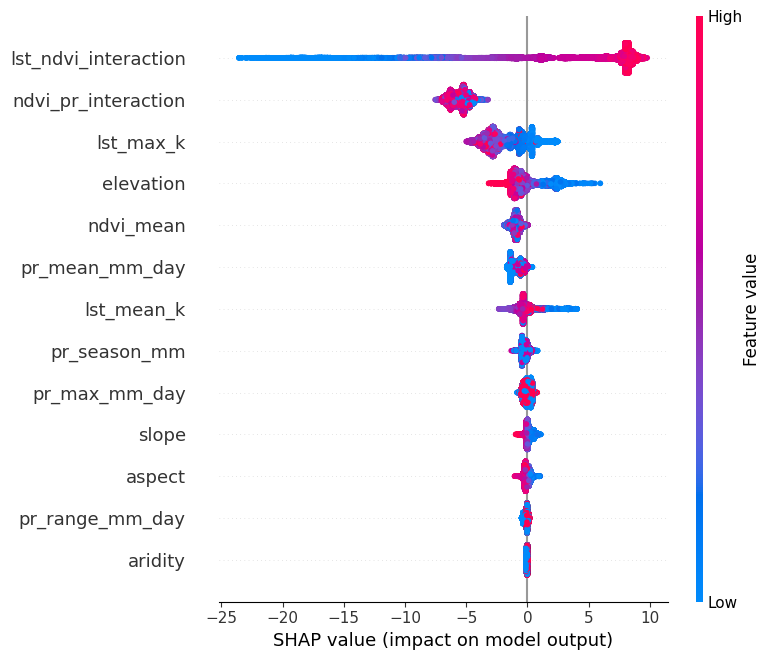

In [ ]:
import shap


# after training bst (XGBoost Booster)
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_te)  # SHAP values for test data

# summary plot (global importance)
shap.summary_plot(shap_values, X_te, feature_names=features)

# force plot (local explanation for one sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_te[0,:], feature_names=features)


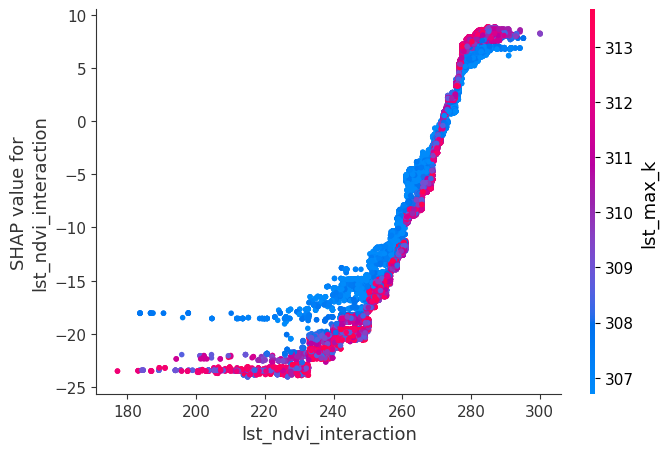

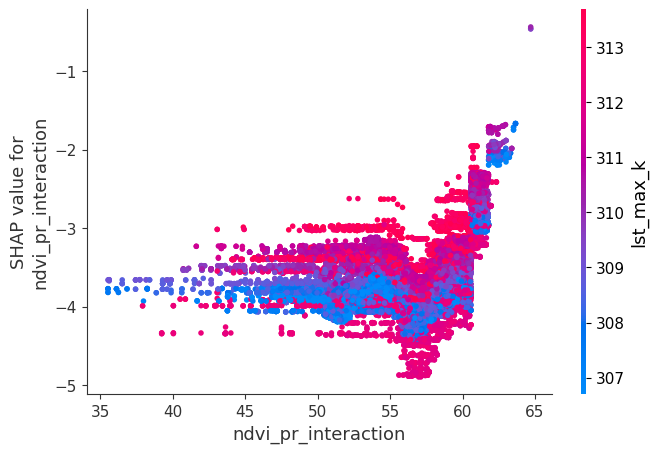

In [ ]:
import shap

# Create explainer for your trained booster
explainer = shap.TreeExplainer(bst)

# Get SHAP values for validation (or train+val)
shap_values = explainer.shap_values(X_va, y_va)

# Dependence plot for lst_ndvi_interaction
shap.dependence_plot(
    "lst_ndvi_interaction",
    shap_values,
    X_va,
    feature_names=features
)

# Dependence plot for ndvi_pr_interaction
shap.dependence_plot(
    "ndvi_pr_interaction",
    shap_values,
    X_va,
    feature_names=features
)


In [ ]:
#Predicting within year different field prediction

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# -------------------------------
# 0) Data & features
# -------------------------------
year = 2020
df = df_map["2020-2023"][df_map["2020-2023"]['year']==year].copy()

# features = [
#     # 'elevation',
#           #  'slope','aspect',
#             'aspect_southness',
#             # 'slope_squared',
#             'elevation_squared',
#       #  'elev_slope', 'elev_aspect', 'slope_aspect',
#             # 'ndvi_mean',
#             'ndvi_max',
#     'ndvi_range',
#             'lst_mean_k',
#     'lst_max_k',
#             'lst_range_k',
#             'pr_season_mm',
#     'pr_mean_mm_day',
#     'pr_max_mm_day',
#     'pr_range_mm_day',
#             'aridity',
#             'ndvi_pr_interaction', 'lst_ndvi_interaction',
#        'elev_precip_interaction'
#        ]


features = [
    'evi_max', 'evi_mean', 'evi_range',
    'gi_max', 'gi_mean', 'gi_range',
    'lst_mean_k', 'lst_range_k',
    'ndvi_max', 'ndvi_mean', 'ndvi_range',
    'ndwi_max', 'ndwi_mean', 'ndwi_range',
    'swir1_max', 'swir1_mean', 'swir1_range',
    'swir2_max', 'swir2_mean', 'swir2_range',
    'aspect', 'clay_pct', 'ksat', 'slope', 'theta_s',
    'pr_season_mm', 'aridity'
]
target = "yield"

# ensure required columns exist
assert "field" in df.columns, "Missing 'field' column for grouping"
df = df.dropna(subset=features + [target, "field"]).copy()

print("df: ", df.shape)


# -------------------------------
# 1) Field-wise split
# -------------------------------
fields = df["field"].unique()

train_fields, test_fields = train_test_split(fields, test_size=0.2, random_state=42)
train_fields, val_fields  = train_test_split(train_fields, test_size=0.25, random_state=42)

print(f"Fields: total={len(fields)}  train={len(train_fields)}  val={len(val_fields)}  test={len(test_fields)}")

# → 60% train, 20% val, 20% test

print(f"Fields: total={len(fields)}  train={len(train_fields)}  val={len(val_fields)}  test={len(test_fields)}")

# masks
mask_tr = df["field"].isin(train_fields)
mask_va = df["field"].isin(val_fields)
mask_te = df["field"].isin(test_fields)

X_tr, y_tr = df.loc[mask_tr, features].to_numpy(), df.loc[mask_tr, target].to_numpy()
X_va, y_va = df.loc[mask_va, features].to_numpy(), df.loc[mask_va, target].to_numpy()
X_te, y_te = df.loc[mask_te, features].to_numpy(), df.loc[mask_te, target].to_numpy()

print(f"Rows | train: {X_tr.shape[0]}  val: {X_va.shape[0]}  test: {X_te.shape[0]}")

# -------------------------------
# 2) DMatrix
# -------------------------------
dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=features)
dval   = xgb.DMatrix(X_va, label=y_va, feature_names=features)
dtest  = xgb.DMatrix(X_te, label=y_te, feature_names=features)

print("dtrain: \n", dtrain)

# -------------------------------
# 3) Base parameters
# -------------------------------
params = {
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "eta": 0.1,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "seed": 42,
    "alpha": 0.1,
    "lambda":2.0,
    "gamma": 0.5,
    "min_child_weight" : 3
}

# -------------------------------
# 4) Train with early stopping
# -------------------------------
num_boost_round = 1000
evals_result = {}

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds=50,
    verbose_eval=1,
    evals_result=evals_result,
)

# -------------------------------
# 5) Evaluate
# -------------------------------
def report(y_true, y_pred, label):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label:<6} R²: {r2: .3f}   MAE: {mae: .3f}   RMSE: {rmse: .3f}")

best_iter = bst.best_iteration
print(f"\nBest iteration: {best_iter}")

y_tr_pred = bst.predict(dtrain, iteration_range=(0, best_iter))
y_va_pred = bst.predict(dval, iteration_range=(0, best_iter))
y_te_pred = bst.predict(dtest, iteration_range=(0, best_iter))

print("\n──── Performance (yield units) ────")
report(y_tr, y_tr_pred, "Train")
report(y_va, y_va_pred, "Val")
report(y_te, y_te_pred, "Test")

# -------------------------------
# 6) Feature importance
# -------------------------------
importances = bst.get_score(importance_type="gain")
print("\nFeature Importances (gain):")
print(pd.Series(importances).sort_values(ascending=False))


df:  (70670, 50)
Fields: total=51  train=30  val=10  test=11
Fields: total=51  train=30  val=10  test=11
Rows | train: 46155  val: 13492  test: 11023
dtrain: 
[0]	train-rmse:14.68228	val-rmse:14.21063
[1]	train-rmse:13.69167	val-rmse:13.64486
[2]	train-rmse:12.81062	val-rmse:13.22479
[3]	train-rmse:12.01738	val-rmse:12.84114
[4]	train-rmse:11.32418	val-rmse:12.47562
[5]	train-rmse:10.71272	val-rmse:12.23313
[6]	train-rmse:10.17668	val-rmse:12.05114
[7]	train-rmse:9.70811	val-rmse:11.99008
[8]	train-rmse:9.28083	val-rmse:11.87622
[9]	train-rmse:8.91452	val-rmse:11.84798
[10]	train-rmse:8.59732	val-rmse:11.64611
[11]	train-rmse:8.26087	val-rmse:11.57507
[12]	train-rmse:8.01931	val-rmse:11.55158
[13]	train-rmse:7.75881	val-rmse:11.54914
[14]	train-rmse:7.53564	val-rmse:11.54822
[15]	train-rmse:7.33757	val-rmse:11.62135
[16]	train-rmse:7.17544	val-rmse:11.57117
[17]	train-rmse:7.03934	val-rmse:11.51867
[18]	train-rmse:6.91420	val-rmse:11.55390
[19]	train-rmse:6.80590	val-rmse:11.57464
[20]

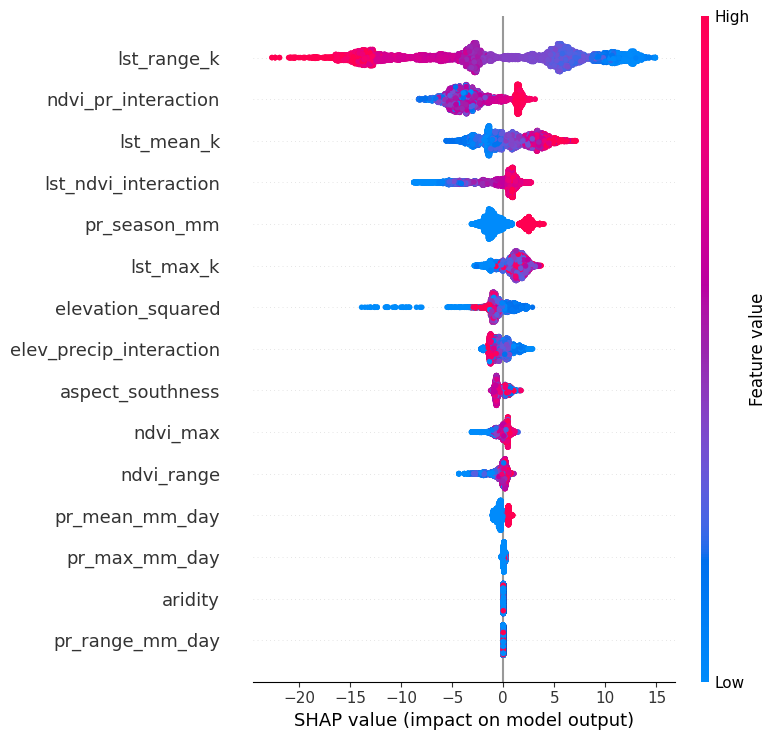

In [ ]:
import shap


# after training bst (XGBoost Booster)
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_te)  # SHAP values for test data

# summary plot (global importance)
shap.summary_plot(shap_values, X_te, feature_names=features)

# force plot (local explanation for one sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_te[0,:], feature_names=features)


In [ ]:
df_map["2014-2024"].keys()

Index(['index', 'x', 'y', 'yield', 'field', 'year', 'elevation', 'slope',
       'aspect', 'aspect_southness', 'slope_squared', 'elevation_squared',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean',
       'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range', 'theta_s', 'clay_pct', 'ksat'],
      dtype='object')

Data shape after cleaning: (610617, 38) rows
Split sizes → train: 427431, val: 91593, test: 91593

Performance:
 Train | R²=0.9971  MAE=0.5956  
 Valid | R²=0.9794  MAE=1.5869  
 Test  | R²=0.9792  MAE=1.5988  


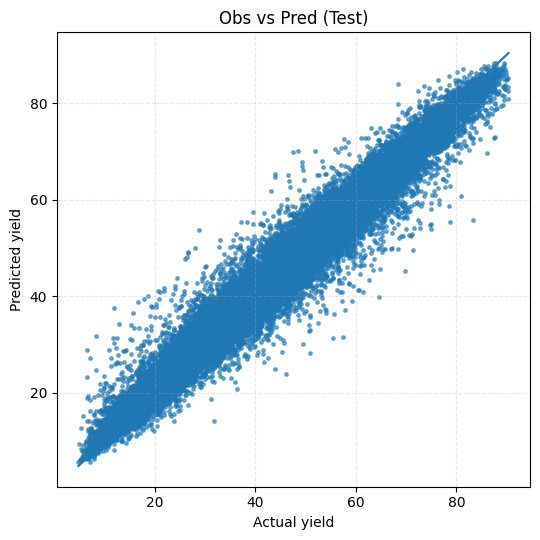

,importance
evi_max,0.093663
gi_max,0.065988
gi_range,0.065210
gi_mean,0.050151
ndwi_max,0.048035
pr_mean_mm_day,0.044684
aridity,0.044303
pr_max_mm_day,0.041378
pr_range_mm_day,0.040672
pr_season_mm,0.035641


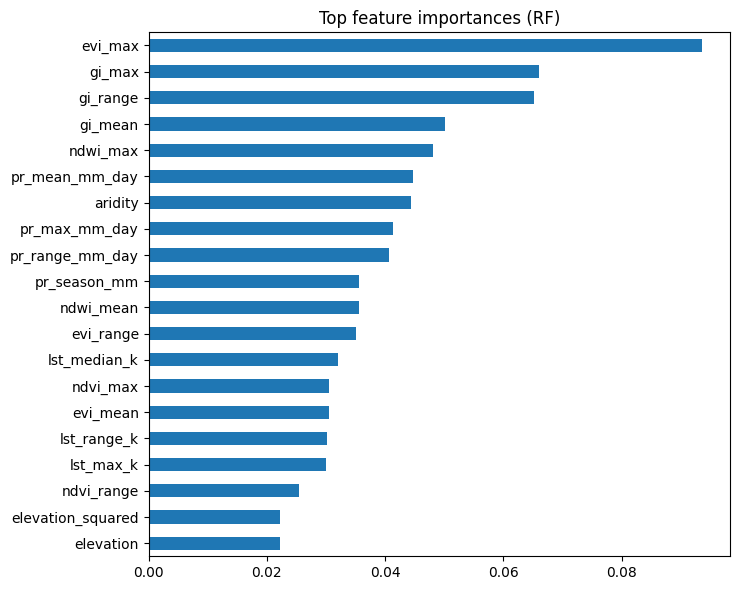

In [ ]:
# ===============================================
# Random split on all 2020–2023 (easier baseline)
# Train/Val/Test = 70% / 15% / 15% (random)
# Model: RandomForestRegressor (n_estimators=150)
# ===============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

SEED = 42
np.random.seed(SEED)


df_all = df_map["2014-2024"].copy()

# features = [
#     'evi_max', 'evi_mean', 'evi_range',
#     'gi_max', 'gi_mean', 'gi_range',
#     'lst_mean_k', 'lst_range_k',
#     'ndvi_max', 'ndvi_mean', 'ndvi_range',
#     'ndwi_max', 'ndwi_mean', 'ndwi_range',
#     'swir1_max', 'swir1_mean', 'swir1_range',
#     'swir2_max', 'swir2_mean', 'swir2_range',
#     'aspect', 'clay_pct', 'ksat', 'slope', 'theta_s',
#     'pr_season_mm', 'aridity'
# ]

features =[
    'elevation', 'slope',
       'aspect', 'aspect_southness', 'slope_squared', 'elevation_squared',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean',
       'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range', 'theta_s', 'clay_pct', 'ksat'
]


target = "yield"

# Keep only needed columns; drop rows with missing values
need = features + [target]
missing_cols = [c for c in features if c not in df_all.columns]
if missing_cols:
    raise KeyError(f"These features are missing from df_all: {missing_cols}")

df_use = df_all.dropna(subset=need).copy()

# Optional: basic outlier guard (adjust to your units)
# Remove non-positive yields and extreme top 0.1% that can destabilize training
df_use = df_use[(df_use[target] > 0)]
upper_cap = df_use[target].quantile(0.999)
df_use = df_use[df_use[target] <= upper_cap].copy()

X = df_use[features].values
y = df_use[target].values

print("Data shape after cleaning:", X.shape, "rows")

# -----------------------------------------------
# 2) Random split: 70/15/15
# -----------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED
)

print(f"Split sizes → train: {len(y_train)}, val: {len(y_val)}, test: {len(y_test)}")

# -----------------------------------------------
# 3) Train Random Forest (Annelise-style)
# -----------------------------------------------
rf = RandomForestRegressor(
    n_estimators=150,
    max_features='sqrt',
    random_state=SEED,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# -----------------------------------------------
# 4) Evaluate
# -----------------------------------------------
def metrics(y_true, y_pred, label):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    # rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{label:>6} | R²={r2:.4f}  MAE={mae:.4f}  ")
    return r2, mae

pred_tr = rf.predict(X_train)
pred_va = rf.predict(X_val)
pred_te = rf.predict(X_test)

print("\nPerformance:")
metrics(y_train, pred_tr, "Train")
metrics(y_val,   pred_va, "Valid")
metrics(y_test,  pred_te, "Test ")

# -----------------------------------------------
# 5) Obs vs Pred scatter (test set)
# -----------------------------------------------
plt.figure(figsize=(5.5, 5.5))
plt.scatter(y_test, pred_te, s=6, alpha=0.6)
lims = [min(y_test.min(), pred_te.min()), max(y_test.max(), pred_te.max())]
plt.plot(lims, lims)  # 1:1 line
plt.xlabel("Actual yield")
plt.ylabel("Predicted yield")
plt.title("Obs vs Pred (Test)")
plt.grid(True, ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# 6) Feature importance (Gini)
# -----------------------------------------------
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
display(importances.to_frame("importance").head(15))

plt.figure(figsize=(7.5, 6))
importances.head(20).iloc[::-1].plot(kind='barh')
plt.title("Top feature importances (RF)")
plt.tight_layout()
plt.show()

# -----------------------------------------------
# 7) Save obs-vs-pred (test) if you want
# -----------------------------------------------
obs_vs_pred = pd.DataFrame({
    "actual_yield": y_test,
    "predicted_yield": pred_te
})
# obs_vs_pred.to_csv("/content/obs_vs_pred_randomsplit_2020_2023.csv", index=False)
# print("Saved: /content/obs_vs_pred_randomsplit_2020_2023.csv")


In [ ]:
df_map

NameError: name 'df_map' is not defined

Data shape after cleaning: (610617, 38) rows
Split sizes → train: 427431, val: 91593, test: 91593

Performance (XGBoost):
 Train | R²=0.9531  MAE=2.7141 
 Valid | R²=0.9454  MAE=2.9122 
 Test  | R²=0.9457  MAE=2.9079 


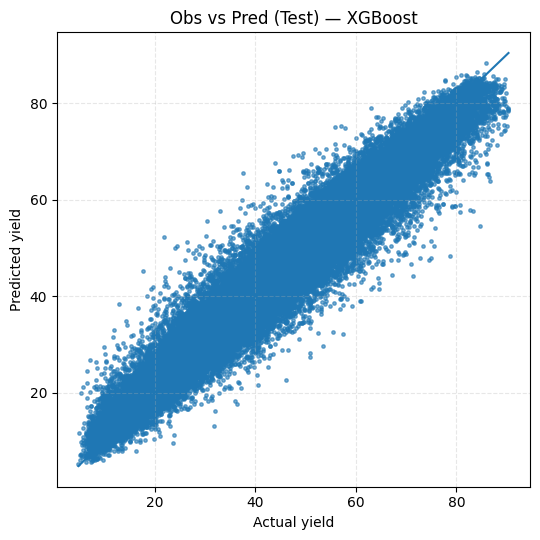

,gain_importance
aridity,88235.484375
evi_max,54150.449219
gi_max,37488.253906
pr_max_mm_day,35138.296875
gi_range,31401.349609
pr_season_mm,23681.462891
pr_range_mm_day,18564.812500
ndwi_max,15883.176758
pr_mean_mm_day,13064.312500
ndwi_mean,7128.990723


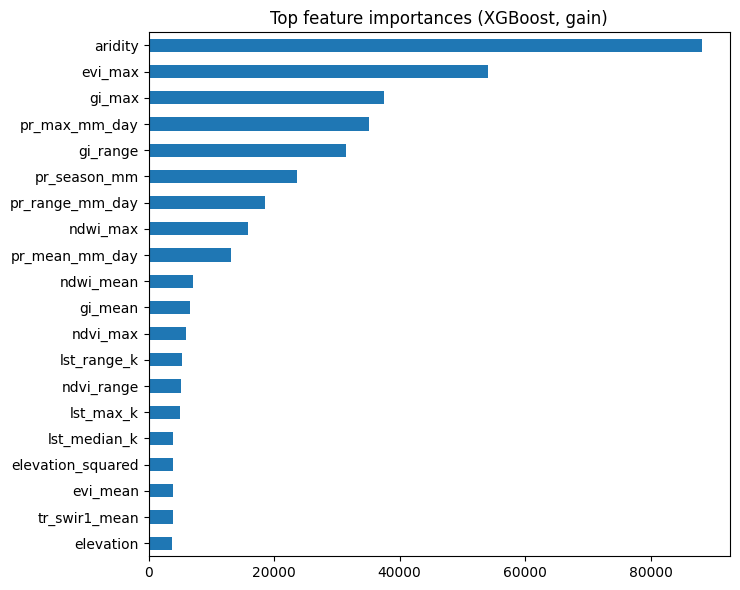

Best iteration (trees): 2000


In [ ]:
# ===============================================
# Random split on all 2020–2023 (baseline)
# Train/Val/Test = 70% / 15% / 15% (random)
# Model: XGBoost Regressor with early stopping (v1.x/v2.x safe)
# ===============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost.callback import EarlyStopping
SEED = 42
np.random.seed(SEED)

# 0) Load
df_all = df_map["2014-2024"].copy()

# Option _all[df_all["crop"].astype(str).str.strip().str.lower() == CROP.lower()].copy()

# 1) Features/target (same list you used)
# features = [
#     'evi_max', 'evi_mean', 'evi_range',
#     'gi_max', 'gi_mean', 'gi_range',
#     'lst_mean_k', 'lst_range_k',
#     'ndvi_max', 'ndvi_mean', 'ndvi_range',
#     'ndwi_max', 'ndwi_mean', 'ndwi_range',
#     'swir1_max', 'swir1_mean', 'swir1_range',
#     'swir2_max', 'swir2_mean', 'swir2_range',
#     'aspect', 'clay_pct', 'ksat', 'slope', 'theta_s',
#     'pr_season_mm', 'aridity'
# ]



features =[
    'elevation', 'slope',
       'aspect', 'aspect_southness', 'slope_squared', 'elevation_squared',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean', 'ndvi_max',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range', 'tr_swir1_mean',
       'tr_swir1_max', 'tr_swir1_range', 'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range', 'theta_s', 'clay_pct', 'ksat'
]

target = "yield"

need = features + [target]
missing_cols = [c for c in features if c not in df_all.columns]
if missing_cols:
    raise KeyError(f"These features are missing from df_all: {missing_cols}")

df_use = df_all.dropna(subset=need).copy()
df_use = df_use[df_use[target] > 0]
upper_cap = df_use[target].quantile(0.999)
df_use = df_use[df_use[target] <= upper_cap].copy()

X = df_use[features].astype(np.float32).values
y = df_use[target].astype(np.float32).values
print("Data shape after cleaning:", X.shape, "rows")

# 2) Random split 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=SEED)
print(f"Split sizes → train: {len(y_train)}, val: {len(y_val)}, test: {len(y_test)}")

# 3) XGBoost model (set eval_metric HERE, not in fit)
model = xgb.XGBRegressor(
    # Capacity + regularization
    n_estimators=2000,          # high cap; early stopping will pick best
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    # Objective & tree method
    objective="reg:squarederror",
    tree_method="hist",         # switch to "gpu_hist" if you enable a GPU in Colab
    # Reproducibility
    random_state=SEED,
    n_jobs=-1,
    # >>> v2-compatible: eval metric goes on the estimator, not in fit
    eval_metric="rmse",
    early_stopping_rounds=100
)

# 3b) Fit with version-safe early stopping callback
es = xgb.callback.EarlyStopping(
    rounds=100,
    save_best=True,             # keep the best iteration
    maximize=False              # RMSE: lower is better
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # tuples only (X, y)
    #  early_stopping_rounds=100,
    verbose=False
)

# Helper to use the best number of trees across XGB versions
def predict_best(m, X):
    # Prefer best_iteration if available
    it = getattr(m, "best_iteration", None)
    if it is not None:
        return m.predict(X, iteration_range=(0, it + 1))
    # Fallback to booster attr if needed
    try:
        it2 = m.get_booster().best_iteration
        if it2 is not None:
            return m.predict(X, iteration_range=(0, it2 + 1))
    except Exception:
        pass
    # Final fallback: default predict (no limit)
    return m.predict(X)

# 4) Evaluate
def metrics(y_true, y_pred, label):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    # rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{label:>6} | R²={r2:.4f}  MAE={mae:.4f} ")
    return r2, mae

pred_tr = predict_best(model, X_train)
pred_va = predict_best(model, X_val)
pred_te = predict_best(model, X_test)

print("\nPerformance (XGBoost):")
metrics(y_train, pred_tr, "Train")
metrics(y_val,   pred_va, "Valid")
metrics(y_test,  pred_te, "Test ")

# 5) Obs vs Pred scatter (test)
plt.figure(figsize=(5.5, 5.5))
plt.scatter(y_test, pred_te, s=6, alpha=0.6)
lims = [min(y_test.min(), pred_te.min()), max(y_test.max(), pred_te.max())]
plt.plot(lims, lims)
plt.xlabel("Actual yield")
plt.ylabel("Predicted yield")
plt.title("Obs vs Pred (Test) — XGBoost")
plt.grid(True, ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 6) Feature importance (gain)
booster = model.get_booster()
gain = booster.get_score(importance_type="gain")
name_map = {f"f{i}": feat for i, feat in enumerate(features)}
gain_series = pd.Series({name_map.get(k, k): v for k, v in gain.items()}).sort_values(ascending=False)

display(gain_series.to_frame("gain_importance").head(20))
plt.figure(figsize=(7.5, 6))
gain_series.head(20).iloc[::-1].plot(kind='barh')
plt.title("Top feature importances (XGBoost, gain)")
plt.tight_layout()
plt.show()

# Optional: print best iteration used
best_it = getattr(model, "best_iteration", None)
print("Best iteration (trees):", None if best_it is None else best_it + 1)


In [ ]:
df_map['2014-2023'].describe()

,index,x,y,yield,year,elevation,slope,aspect,aspect_southness,slope_squared,...,swir1_min,swir1_range,swir2_mean,swir2_max,swir2_min,swir2_range,ndvi_pr_interaction,lst_ndvi_interaction,elev_precip_interaction,swir_ndvi_interaction
count,561775.000000,561775.000000,5.617750e+05,561775.000000,561775.000000,561775.000000,561775.000000,561775.000000,561775.000000,561775.000000,...,561775.000000,561775.000000,561775.000000,561775.000000,561775.000000,561775.000000,561775.000000,552516.000000,561775.000000,561775.000000
mean,109721.084409,337115.892681,4.321352e+06,47.723718,2018.865516,38.355396,2.397662,191.130371,0.506180,9.149408,...,0.152241,0.228877,0.164160,0.276886,0.073609,0.203277,50.014266,228.065575,32000.140646,0.697872
std,100264.145098,2676.304318,8.658241e+02,16.136702,2.639194,7.142519,1.843913,102.311531,0.288204,76.725929,...,0.053207,0.090332,0.029243,0.064063,0.028285,0.074936,17.781287,63.622250,8513.914057,0.223814
min,0.000000,330929.234646,4.318631e+06,4.826442,2014.000000,0.000000,0.003039,0.011794,0.000020,0.000009,...,0.021100,0.000000,0.043524,0.062075,0.009500,0.000000,9.981824,49.679805,0.000000,0.178426
25%,28334.000000,336010.385510,4.320611e+06,36.032711,2017.000000,32.839787,1.203946,107.876854,0.256217,1.449486,...,0.118120,0.158400,0.148272,0.233977,0.056800,0.149958,40.315368,158.634619,25456.031976,0.518256
50%,60514.000000,336714.180938,4.321353e+06,47.118073,2019.000000,38.124916,2.066088,199.318893,0.515120,4.268718,...,0.165173,0.225900,0.167196,0.280500,0.077900,0.202400,47.448601,268.132106,30861.980226,0.638331
75%,190796.500000,338590.397562,4.321997e+06,59.406702,2021.000000,42.872803,3.239356,279.628937,0.753761,10.493427,...,0.191900,0.293000,0.182884,0.324900,0.090428,0.257100,60.297369,278.876958,37397.608015,0.858447
max,332490.000000,342733.656286,4.323242e+06,116.790192,2023.000000,80.984177,82.644829,359.996460,0.999995,6830.167969,...,0.403542,0.812700,0.289885,1.348000,0.289885,1.313800,95.832004,300.477277,91155.787244,1.971289


Data shape after cleaning: (610617, 31) rows; unique fields: 108
Split sizes → train: 395371, val: 126965, test: 88281
Fields per split: 
  train: 74 
  val  : 17 
  test : 17

Performance (field-wise holdout):
 Train | R²=0.9978  MAE=0.5351  
 Valid | R²=0.5730  MAE=7.7656  
 Test  | R²=0.5613  MAE=8.4192  


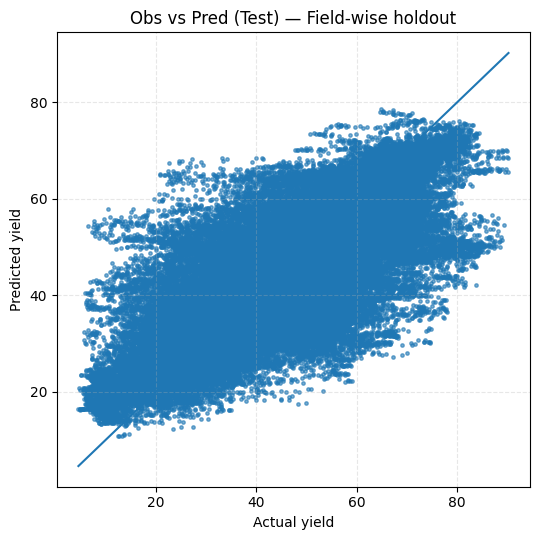

,importance
gi_max,0.080280
evi_max,0.073730
gi_range,0.068734
gi_mean,0.065159
ndwi_max,0.049325
aridity,0.049041
pr_mean_mm_day,0.047930
pr_season_mm,0.047841
evi_mean,0.046382
ndwi_mean,0.037549


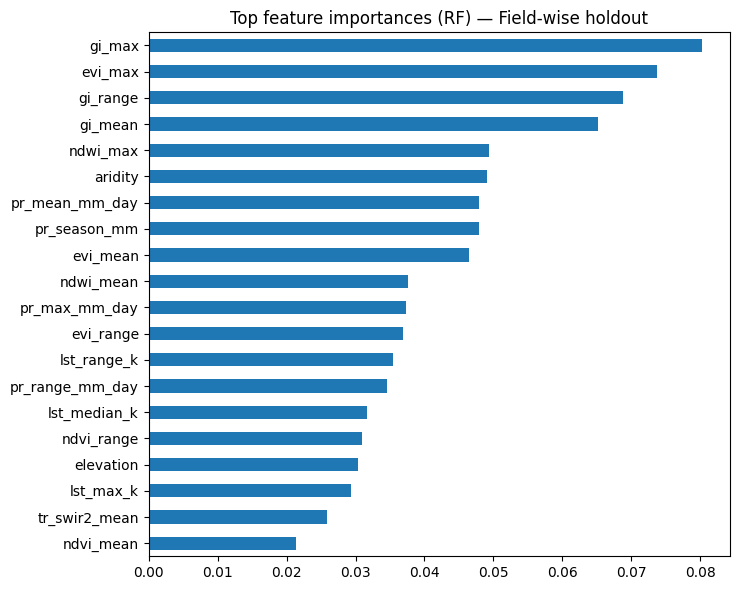

,n,r2,mae
field,,,
APU_1,10089,0.473118,7.719892
APU_5,6677,0.525902,5.556265
Central Farm_1-14B,8964,0.233095,9.894481
Central Farm_1-14C,8349,-0.216815,10.632229
Central Farm_1-2B,6400,0.484466,6.640668
Central Farm_2-32C,3019,-2.152800,8.476800
Central Farm_4-7,5880,0.339222,11.754706
East Farm_5-3C2,599,0.692510,5.245300
East Farm_5-45D,5083,-0.258376,10.658686


Per-field rows: 17


In [ ]:
# ===============================================
# Field-wise split on all 2020–2023 (spatial holdout)
# Train/Val/Test = ~70% / 15% / 15% by FIELD (all years mixed)
# Model: RandomForestRegressor (n_estimators=150)
# ===============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

SEED = 42
np.random.seed(SEED)

# -----------------------------------------------
# 0) Load / pick data
# -----------------------------------------------
# if "2020-2023" not in df_map:
#     years = [2020, 2021, 2022, 2023]
#     parts = []
#     for y in years:
#         if y in df_map:
#             parts.append(df_map[y])
#         else:
#             raise ValueError(f"Missing df_map[{y}]")
#     df_all = pd.concat(parts, ignore_index=True)
# else:
df_all = df_map["2014-2024"].copy()

# Optional: focus on a single crop
# CROP = "Soybean"  # "Corn", "Soybean", "Wheat"
# if "crop" in df_all.columns:
#     df_all = df_all[df_all["crop"].astype(str).str.strip().str.lower() == CROP.lower()].copy()

# -----------------------------------------------
# 1) Identify FIELD column (try common names)
# -----------------------------------------------
field_candidates = [
    "field", "field_name", "Field", "Field_Name",
    "fieldID", "field_id", "usda_field", "USDA_field"
]
field_col = next((c for c in field_candidates if c in df_all.columns), None)
if field_col is None:
    raise KeyError(f"Could not find a field identifier column. "
                   f"Tried: {field_candidates}. Please rename your field column accordingly.")

# -----------------------------------------------
# 2) Define features & target (edit as needed)
# -----------------------------------------------
# features = [
#     'evi_max', 'evi_mean', 'evi_range',
#     'gi_max', 'gi_mean', 'gi_range',
#     'lst_median_k', 'lst_range_k',
#     'ndvi_max', 'ndvi_mean', 'ndvi_range',
#     'ndwi_max', 'ndwi_mean', 'ndwi_range',
#     'tr_swir1_max', 'tr_swir1_mean', 'tr_swir1_range',
#     'tr_swir2_max', 'tr_swir2_mean', 'tr_swir2_range',
#     'aspect', 'clay_pct', 'ksat', 'slope', 'theta_s',
#     'pr_season_mm', 'aridity'
# ]

features = [
     'elevation',
       'aspect', 'aspect_southness',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range',
     'tr_swir1_range',
     'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range',
     'clay_pct',
          'ksat'
     ]



target = "yield"  # or 'b1' if that's your target

missing_cols = [c for c in features if c not in df_all.columns]
if missing_cols:
    raise KeyError(f"These features are missing from df_all: {missing_cols}")
if target not in df_all.columns:
    raise KeyError(f"Target '{target}' not found in df_all.")

# -----------------------------------------------
# 3) Clean data (drop NA; basic outlier guard)
# -----------------------------------------------
need = features + [target, field_col]
df_use = df_all.dropna(subset=need).copy()
# Remove non-positive yields and extreme high outliers (adjust to your units)
df_use = df_use[df_use[target] > 0]
upper_cap = df_use[target].quantile(0.999)
df_use = df_use[df_use[target] <= upper_cap].copy()

# -----------------------------------------------
# 4) Build arrays & groups (fields)
# -----------------------------------------------
X = df_use[features].values
y = df_use[target].values
groups = df_use[field_col].astype(str).values  # group by field

print("Data shape after cleaning:", X.shape, "rows; unique fields:", df_use[field_col].nunique())

# -----------------------------------------------
# 5) Field-wise split: ~70/15/15 by field
#    First split off test fields, then split train into train/val by field.
# -----------------------------------------------
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_val_idx, test_idx = next(gss1.split(X, y, groups=groups))

X_train_val, y_train_val = X[train_val_idx], y[train_val_idx]
groups_train_val = groups[train_val_idx]

X_test, y_test = X[test_idx], y[test_idx]
groups_test = groups[test_idx]

# Now split train_val into train/val (val ≈ 15% of all data → 0.15/0.85 ≈ 0.176 of train_val)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.176, random_state=SEED)
train_idx, val_idx = next(gss2.split(X_train_val, y_train_val, groups=groups_train_val))

X_train, y_train = X_train_val[train_idx], y_train_val[train_idx]
X_val,   y_val   = X_train_val[val_idx],   y_train_val[val_idx]

print(f"Split sizes → train: {len(y_train)}, val: {len(y_val)}, test: {len(y_test)}")
print("Fields per split:",
      "\n  train:", len(np.unique(groups_train_val[train_idx])),
      "\n  val  :", len(np.unique(groups_train_val[val_idx])),
      "\n  test :", len(np.unique(groups_test)))

# -----------------------------------------------
# 6) Train model
# -----------------------------------------------
rf = RandomForestRegressor(
    n_estimators=150,
    max_features='sqrt',
    random_state=SEED,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# -----------------------------------------------
# 7) Evaluate
# -----------------------------------------------
def metrics(y_true, y_pred, label):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    # rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{label:>6} | R²={r2:.4f}  MAE={mae:.4f}  ")
    return r2, mae

pred_tr = rf.predict(X_train)
pred_va = rf.predict(X_val)
pred_te = rf.predict(X_test)

print("\nPerformance (field-wise holdout):")
metrics(y_train, pred_tr, "Train")
metrics(y_val,   pred_va, "Valid")
metrics(y_test,  pred_te, "Test ")

# -----------------------------------------------
# 8) Obs vs Pred scatter (test set)
# -----------------------------------------------
plt.figure(figsize=(5.5, 5.5))
plt.scatter(y_test, pred_te, s=6, alpha=0.6)
lims = [min(y_test.min(), pred_te.min()), max(y_test.max(), pred_te.max())]
plt.plot(lims, lims)
plt.xlabel("Actual yield")
plt.ylabel("Predicted yield")
plt.title("Obs vs Pred (Test) — Field-wise holdout")
plt.grid(True, ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# 9) Feature importance
# -----------------------------------------------
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
display(importances.to_frame("importance").head(20))

plt.figure(figsize=(7.5, 6))
importances.head(20).iloc[::-1].plot(kind='barh')
plt.title("Top feature importances (RF) — Field-wise holdout")
plt.tight_layout()
plt.show()

# -----------------------------------------------
# 10) Optional: per-field summary on TEST (how well do we do per field?)
# -----------------------------------------------
test_df = df_use.iloc[test_idx].copy()
test_df = test_df.assign(pred=pred_te, err=pred_te - y_test, abs_err=np.abs(pred_te - y_test))
by_field = test_df.groupby(field_col).agg(
    n=("yield","size"),
    r2=("yield", lambda s: r2_score(s, test_df.loc[s.index, "pred"]) if s.size > 1 else np.nan),
    mae=("abs_err","mean")
    # rmse=("err",  lambda s: np.sqrt(np.mean(s**2)))
)

display(by_field.head(10))
print("Per-field rows:", by_field.shape[0])


In [ ]:
df_map['2014-2023'].describe()

,index,x,y,yield,year,elevation,slope,aspect,aspect_southness,slope_squared,...,swir1_min,swir1_range,swir2_mean,swir2_max,swir2_min,swir2_range,ndvi_pr_interaction,lst_ndvi_interaction,elev_precip_interaction,swir_ndvi_interaction
count,561775.000000,561775.000000,5.617750e+05,561775.000000,561775.000000,561775.000000,561775.000000,561775.000000,561775.000000,561775.000000,...,561775.000000,561775.000000,561775.000000,561775.000000,561775.000000,561775.000000,561775.000000,552516.000000,561775.000000,561775.000000
mean,109721.084409,337115.892681,4.321352e+06,47.723718,2018.865516,0.001169,-0.014542,-0.003180,0.017600,-0.002993,...,-0.044631,0.076755,0.058817,0.071491,-0.037108,0.075603,-0.040303,0.066412,-0.093585,0.061446
std,100264.145098,2676.304318,8.658241e+02,16.136702,2.639194,0.976703,0.984376,0.991857,0.996973,0.957229,...,1.008308,1.012764,0.994942,1.004880,1.005438,1.011383,0.966013,0.986799,1.010123,0.987355
min,0.000000,330929.234646,4.318631e+06,4.826442,2014.000000,-5.243211,-1.292799,-1.855876,-1.733204,-0.116989,...,-2.529844,-2.489318,-4.045574,-3.297975,-2.315950,-2.667951,-2.215165,-2.700403,-3.890202,-2.230085
25%,28334.000000,336010.385510,4.320611e+06,36.032711,2017.000000,-0.752987,-0.651751,-0.810236,-0.847018,-0.098930,...,-0.691242,-0.713407,-0.481737,-0.601561,-0.634599,-0.644034,-0.567220,-1.010482,-0.870003,-0.730929
50%,60514.000000,336714.180938,4.321353e+06,47.118073,2019.000000,-0.030345,-0.191537,0.076200,0.048523,-0.063803,...,0.200438,0.043373,0.162136,0.128177,0.115432,0.063761,-0.179689,0.687855,-0.228621,-0.201220
75%,190796.500000,338590.397562,4.321997e+06,59.406702,2021.000000,0.618840,0.434758,0.854722,0.873981,0.013753,...,0.706944,0.795668,0.695857,0.824623,0.560741,0.802025,0.518352,0.854511,0.546790,0.769821
max,332490.000000,342733.656286,4.323242e+06,116.790192,2023.000000,5.829854,42.821649,1.633802,1.725704,84.983251,...,4.717728,6.622314,4.336352,16.872679,7.650761,15.063886,2.448860,1.189538,6.924862,5.679120


Data after cleaning: (610617, 31) rows; unique fields: 108
Split sizes → train: 395371, val: 126965, test: 88281
Fields per split: 
  train: 74 
  val  : 17 
  test : 17

Performance (XGBoost, field-wise holdout):
 Train | R²=0.8445  MAE=5.1800  
 Valid | R²=0.5532  MAE=7.8794  
 Test  | R²=0.5374  MAE=8.6695  


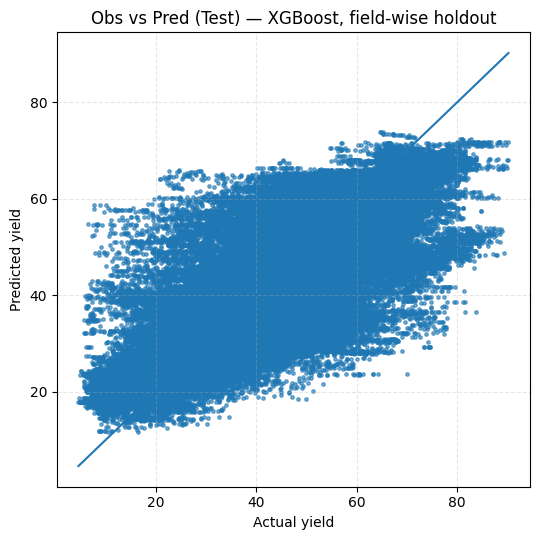

,gain_importance
gi_max,391386.437500
evi_max,336488.906250
aridity,298358.031250
pr_season_mm,161184.546875
gi_range,118461.695312
pr_max_mm_day,108910.906250
pr_range_mm_day,107793.773438
gi_mean,91032.179688
ndwi_max,74493.304688
pr_mean_mm_day,56448.414062


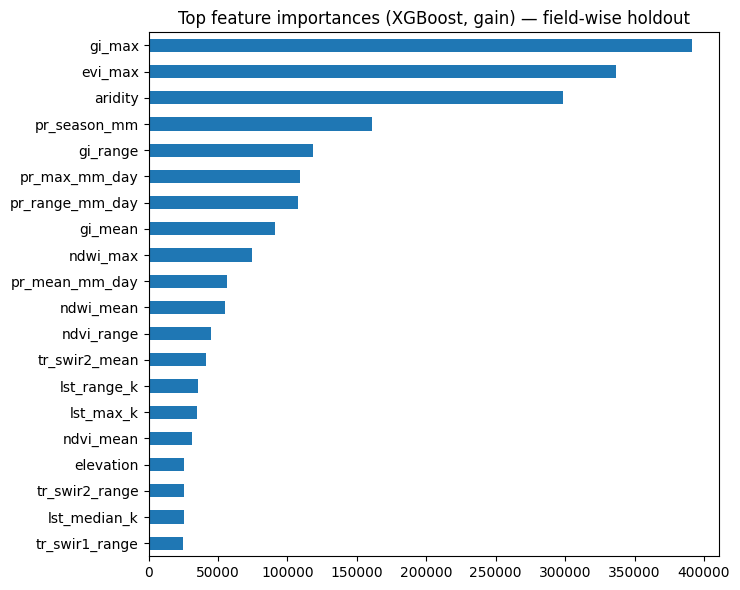

,n,r2,mae
field,,,
APU_1,10089,0.393851,8.269415
APU_5,6677,0.527887,5.386961
Central Farm_1-14B,8964,0.107347,10.971133
Central Farm_1-14C,8349,-0.297074,11.240377
Central Farm_1-2B,6400,0.363011,7.576067
Central Farm_2-32C,3019,-1.883559,7.815729
Central Farm_4-7,5880,0.269905,12.362950
East Farm_5-3C2,599,0.592512,5.973867
East Farm_5-45D,5083,-0.204181,10.564591


Per-field rows: 17
Best iteration (trees): 102


In [ ]:
# ===============================================
# Field-wise split on all 2020–2023 (spatial holdout)
# Train/Val/Test ≈ 70% / 15% / 15% by FIELD (all years mixed)
# Model: XGBRegressor (early-stopping if supported)
# ===============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

SEED = 42
np.random.seed(SEED)

# ----------------------------
# 0) Load / pick data
# ----------------------------
# if "2020-2023" not in df_map:
#     years = [2020, 2021, 2022, 2023]
#     parts = []
#     for y in years:
#         if y in df_map: parts.append(df_map[y])
#         else: raise ValueError(f"Missing df_map[{y}]")
#     df_all = pd.concat(parts, ignore_index=True)
# else:
df_all = df_map["2014-2024"].copy()

# Optional: focus on a single crop
# CROP = "Soybean"  # "Corn", "Soybean", "Wheat"
# if "crop" in df_all.columns:
#     df_all = df_all[df_all["crop"].astype(str).str.strip().str.lower() == CROP.lower()].copy()

# ----------------------------
# 1) Identify FIELD column
# ----------------------------
field_candidates = ["field","field_name","Field","Field_Name","fieldID","field_id","usda_field","USDA_field"]
field_col = next((c for c in field_candidates if c in df_all.columns), None)
if field_col is None:
    raise KeyError(f"Could not find a field identifier column. Tried: {field_candidates}")

# ----------------------------
# 2) Features & target
# ----------------------------
features = [
     'elevation',
       'aspect', 'aspect_southness',
       'elev_slope', 'elev_aspect', 'slope_aspect', 'ndvi_mean',
       'ndvi_range', 'lst_median_k', 'lst_range_k', 'lst_max_k',
       'pr_season_mm', 'pr_mean_mm_day', 'pr_max_mm_day', 'pr_range_mm_day',
       'aridity', 'evi_mean', 'evi_max', 'evi_range', 'gi_mean', 'gi_max',
       'gi_range', 'ndwi_mean', 'ndwi_max', 'ndwi_range',
     'tr_swir1_range',
     'tr_swir2_mean', 'tr_swir2_max',
       'tr_swir2_range',
     'clay_pct',
          'ksat'
     ]
target = "yield"

missing_cols = [c for c in features if c not in df_all.columns]
if missing_cols: raise KeyError(f"Missing features: {missing_cols}")
if target not in df_all.columns: raise KeyError(f"Target '{target}' not found.")

# ----------------------------
# 3) Clean data
# ----------------------------
need = features + [target, field_col]
df_use = df_all.dropna(subset=need).copy()
df_use = df_use[df_use[target] > 0]
upper_cap = df_use[target].quantile(0.999)
df_use = df_use[df_use[target] <= upper_cap].copy()

X = df_use[features].astype(np.float32).values
y = df_use[target].astype(np.float32).values
groups = df_use[field_col].astype(str).values

print("Data after cleaning:", X.shape, "rows; unique fields:", df_use[field_col].nunique())

# ----------------------------
# 4) Field-wise split (70/15/15)
# ----------------------------
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_val_idx, test_idx = next(gss1.split(X, y, groups=groups))

X_train_val, y_train_val = X[train_val_idx], y[train_val_idx]
groups_train_val = groups[train_val_idx]

X_test, y_test = X[test_idx], y[test_idx]
groups_test = groups[test_idx]

# val ≈ 15% overall → 0.15 / 0.85 ≈ 0.176 of train_val
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.176, random_state=SEED)
train_idx, val_idx = next(gss2.split(X_train_val, y_train_val, groups=groups_train_val))

X_train, y_train = X_train_val[train_idx], y_train_val[train_idx]
X_val,   y_val   = X_train_val[val_idx],   y_train_val[val_idx]

print(f"Split sizes → train: {len(y_train)}, val: {len(y_val)}, test: {len(y_test)}")
print("Fields per split:",
      "\n  train:", len(np.unique(groups_train_val[train_idx])),
      "\n  val  :", len(np.unique(groups_train_val[val_idx])),
      "\n  test :", len(np.unique(groups_test)))

# ----------------------------
# 5) XGBRegressor (robust early stopping handling)
# ----------------------------
model = xgb.XGBRegressor(
    n_estimators=2000,         # large cap; early stopping will select best
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    objective="reg:squarederror",
    tree_method="hist",        # "gpu_hist" if GPU is enabled
    random_state=SEED,
    early_stopping_rounds=100,
    n_jobs=-1,
    eval_metric="rmse"         # set on estimator (v2+ friendly)
)

# Try different early-stopping APIs depending on xgboost version
best_iter = None

# Old API path (still works in many setups)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],

    verbose=False
)
best_iter = getattr(model, "best_iteration", None)


def predict_best(m, X_):
    it = getattr(m, "best_iteration", None)
    if it is not None:
        return m.predict(X_, iteration_range=(0, it + 1))
    # booster-based fallback
    try:
        it2 = m.get_booster().best_iteration
        if it2 is not None:
            return m.predict(X_, iteration_range=(0, it2 + 1))
    except Exception:
        pass
    return m.predict(X_)

# ----------------------------
# 6) Evaluate
# ----------------------------
def metrics(y_true, y_pred, label):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    # rmse = mean_squared_error(y_true, y_pred, squared=False)
    print(f"{label:>6} | R²={r2:.4f}  MAE={mae:.4f}  ")
    return r2, mae

pred_tr = predict_best(model, X_train)
pred_va = predict_best(model, X_val)
pred_te = predict_best(model, X_test)

print("\nPerformance (XGBoost, field-wise holdout):")
metrics(y_train, pred_tr, "Train")
metrics(y_val,   pred_va, "Valid")
metrics(y_test,  pred_te, "Test ")

# ----------------------------
# 7) Obs vs Pred (test)
# ----------------------------
plt.figure(figsize=(5.5, 5.5))
plt.scatter(y_test, pred_te, s=6, alpha=0.6)
lims = [min(y_test.min(), pred_te.min()), max(y_test.max(), pred_te.max())]
plt.plot(lims, lims)
plt.xlabel("Actual yield")
plt.ylabel("Predicted yield")
plt.title("Obs vs Pred (Test) — XGBoost, field-wise holdout")
plt.grid(True, ls='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------
# 8) Feature importance (gain)
# ----------------------------
booster = model.get_booster()
gain = booster.get_score(importance_type="gain")  # keys like 'f0','f1',...
name_map = {f"f{i}": feat for i, feat in enumerate(features)}
gain_series = pd.Series({name_map.get(k, k): v for k, v in gain.items()}).sort_values(ascending=False)

display(gain_series.to_frame("gain_importance").head(20))
plt.figure(figsize=(7.5, 6))
gain_series.head(20).iloc[::-1].plot(kind='barh')
plt.title("Top feature importances (XGBoost, gain) — field-wise holdout")
plt.tight_layout()
plt.show()

# ----------------------------
# 9) Per-field summary on TEST
# ----------------------------
test_df = df_use.iloc[test_idx].copy()
test_df = test_df.assign(pred=pred_te, err=pred_te - y_test, abs_err=np.abs(pred_te - y_test))
by_field = test_df.groupby(field_col).agg(
    n=(target, "size"),
    r2=(target, lambda s: r2_score(s, test_df.loc[s.index, "pred"]) if s.size > 1 else np.nan),
    mae=("abs_err","mean")
    # rmse=("err",  lambda s: np.sqrt(np.mean(s**2)))
)

display(by_field.head(10))
print("Per-field rows:", by_field.shape[0])
if best_iter is not None:
    print("Best iteration (trees):", best_iter + 1)


TypeError: 'RangeIndex' object is not callable